## 필요한 라이브러리 불러오기

In [1]:
import platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import load_dataset

In [2]:
# OS 자동 감지 및 한글 폰트 설정
system = platform.system()

if system == 'Windows':
    # Windows: 맑은 고딕 사용
    plt.rcParams['font.family'] = 'Malgun Gothic'
    
elif system == 'Darwin':  # Darwin = macOS
    # macOS: 애플 고딕 사용
    plt.rcParams['font.family'] = 'AppleGothic'
    
elif system == 'Linux':
    # Linux: 나눔 고딕 사용 (사전 설치 필요)
    # 터미널: sudo apt-get install -y fonts-nanum
    plt.rcParams['font.family'] = 'NanumGothic'
    
else:
    print(f"알 수 없는 OS: {system}")

# 모든 OS 공통: 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print(f"OS: {system}, 설정된 폰트: {plt.rcParams['font.family']}")

OS: Linux, 설정된 폰트: ['NanumGothic']


In [3]:
games_season2022 = load_dataset('games_regular', 2022)

## 패작인지?

In [4]:
# ===== 설정 =====
DET_KEYWORD = 'detroit'  # 팀명 매칭(대소문자 무시)
BLOWOUT = 20             # 대패 기준: -20점 이하
MIN_GAMES = 5            # 하위팀 상대 최소 표본수
MIN_DIFF = 0.20          # 하위 vs 베이스 대패률 차이가 20%p 이상이면 의심
MULTIPLIER = 2.0         # 하위 대패률이 베이스의 2배 이상이면 의심
MIN_RATE = 0.50          # 하위 대패률 자체가 50% 이상이면 의심

# ===== 0) 준비 =====
df = games_season2022.copy()
need = ['HOME_TEAM','VISITOR_TEAM','HOME_TEAM_LVL','VISITOR_TEAM_LVL','PTS_home','PTS_away']
miss = [c for c in need if c not in df.columns]
if miss:
    raise KeyError(f"필수 컬럼 누락: {miss}")

# 디트로이트가 나온 경기만
det = df[df['HOME_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False) |
         df['VISITOR_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False)].copy()
if det.empty:
    raise ValueError("디트로이트 경기 없음")

# 숫자화
det['PTS_home'] = pd.to_numeric(det['PTS_home'], errors='coerce')
det['PTS_away'] = pd.to_numeric(det['PTS_away'], errors='coerce')
det = det.dropna(subset=['PTS_home','PTS_away','HOME_TEAM_LVL','VISITOR_TEAM_LVL'])

# ===== 1) 상대(opp) 등급 만들기 (홈/원정 모두 정확히) =====
lvl_map = {'상위팀':'top','중위팀':'mid','하위팀':'low',
           'top':'top','mid':'mid','middle':'mid','low':'low','bottom':'low'}
is_home = det['HOME_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False)
opp_lvl = np.where(
    is_home,
    det['VISITOR_TEAM_LVL'].astype(str).str.strip().str.lower().map(lambda x: lvl_map.get(x, x)),
    det['HOME_TEAM_LVL'].astype(str).str.strip().str.lower().map(lambda x: lvl_map.get(x, x))
)
opp_lvl = pd.Series(opp_lvl, index=det.index)

# ===== 2) 디트로이트 관점 마진/대패 여부 =====
det_pts = np.where(is_home, det['PTS_home'], det['PTS_away'])
opp_pts = np.where(is_home, det['PTS_away'], det['PTS_home'])
margin = pd.Series(det_pts - opp_pts, index=det.index)
bl = margin <= -BLOWOUT  # 20+ 대패 여부

# ===== 3) 하위팀 vs 그 외 비율 비교 (단일 규칙 판정) =====
low_mask = opp_lvl.eq('low')
n_low  = int(low_mask.sum())
k_low  = int((bl & low_mask).sum())
rate_low  = k_low / n_low if n_low > 0 else np.nan

base_mask = ~low_mask
n_base = int(base_mask.sum())
k_base = int((bl & base_mask).sum())
rate_base = k_base / n_base if n_base > 0 else np.nan

suspicious = False
reason = ""
if n_low >= MIN_GAMES and np.isfinite(rate_low) and np.isfinite(rate_base) and n_base > 0:
    if (rate_low - rate_base) >= MIN_DIFF:
        suspicious, reason = True, f"하위팀 상대 대패률이 베이스 대비 {(rate_low-rate_base)*100:.1f}%p 높음(≥{MIN_DIFF*100:.0f}%p)."
    if (rate_low >= MIN_RATE) and (rate_low >= rate_base * MULTIPLIER):
        suspicious = True
        reason = (reason + f" 하위팀 {rate_low*100:.1f}% vs 베이스 {rate_base*100:.1f}% (≥{MULTIPLIER:.1f}배, 자체 {MIN_RATE*100:.0f}% 이상).").strip()
elif n_low < MIN_GAMES:
    reason = f"하위팀 상대 표본 부족: n_low={n_low} < {MIN_GAMES}"
else:
    reason = "베이스라인 계산 불가(비-하위팀 표본 부족 등)."

# ===== 4) 결과 =====
print("=== 디트로이트(홈+원정) 기준: 상대가 '하위팀'일 때 20+ 대패 비율 비교 ===")
print(f"하위팀 표본: {n_low}경기, 20+ 대패: {k_low}경기, 대패률: {rate_low*100:.1f}%" if n_low>0 else "하위팀 표본 없음")
print(f"베이스(비-하위팀): {n_base}경기, 20+ 대패: {k_base}경기, 대패률: {rate_base*100:.1f}%" if n_base>0 else "베이스 표본 없음")
print("판정:", "의심(규칙 충족)" if suspicious else "의심약함/불충분")
print("근거:", reason)


=== 디트로이트(홈+원정) 기준: 상대가 '하위팀'일 때 20+ 대패 비율 비교 ===
하위팀 표본: 35경기, 20+ 대패: 2경기, 대패률: 5.7%
베이스(비-하위팀): 219경기, 20+ 대패: 29경기, 대패률: 13.2%
판정: 의심약함/불충분
근거: 


## 보완점?

In [5]:
# 세팅
DET = 'detroit'  # 팀명 키워드(대소문자 무시)
METRICS = ['PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB']

# 1) 디트로이트 경기만 추출
cols = ['HOME_TEAM','VISITOR_TEAM',
        'PTS_home','PTS_away','FG_PCT_home','FG_PCT_away','FT_PCT_home','FT_PCT_away',
        'FG3_PCT_home','FG3_PCT_away','AST_home','AST_away','REB_home','REB_away']
g = games_season2022.loc[:, cols].copy()

is_home = g['HOME_TEAM'].astype(str).str.contains(DET, case=False, na=False)
is_away = g['VISITOR_TEAM'].astype(str).str.contains(DET, case=False, na=False)
g = g[is_home | is_away].copy()
if g.empty:
    raise ValueError("디트로이트 경기 없음")

# 숫자화(퍼센트/숫자 섞여 있어도 최대한 처리)
to_num = lambda s: pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce')
for c in cols[2:]:
    g[c] = to_num(g[c])

# 2) 팀 관점으로 홈/원정 합치기 (새 DF; 원본은 변경 없음)
team = pd.DataFrame(index=g.index)
team['PTS']     = np.where(is_home.loc[g.index], g['PTS_home'],     g['PTS_away'])
team['FG_PCT']  = np.where(is_home.loc[g.index], g['FG_PCT_home'],  g['FG_PCT_away'])
team['FT_PCT']  = np.where(is_home.loc[g.index], g['FT_PCT_home'],  g['FT_PCT_away'])
team['FG3_PCT'] = np.where(is_home.loc[g.index], g['FG3_PCT_home'], g['FG3_PCT_away'])
team['AST']     = np.where(is_home.loc[g.index], g['AST_home'],     g['AST_away'])
team['REB']     = np.where(is_home.loc[g.index], g['REB_home'],     g['REB_away'])

# 3) 팀 자체 특성(시즌 평균) + 홈/원정 차이
profile = team[METRICS].mean().round(3)

home_mean = team.loc[is_home.loc[g.index], METRICS].mean().round(3)
away_mean = team.loc[is_away.loc[g.index], METRICS].mean().round(3)
venue_gap = (home_mean - away_mean).rename('Home-Away').round(3)

print("=== 팀 시즌 프로필(평균) ===")
print(profile)
print("\n=== 홈 vs 원정 평균 ===")
print(pd.concat([home_mean.rename('Home'), away_mean.rename('Away'), venue_gap], axis=1))

# 4) 득점과의 내부 상관(뭐가 득점을 움직이나?)
corr = team[METRICS].corr()['PTS'].sort_values(ascending=False).round(3)
print("\n=== PTS와의 상관(내부) ===")
print(corr)

# 5) 득점 상/하위 구간 비교(상위25% vs 하위25%) → 차이가 큰 항목 = 레버리지 포인트
q25, q75 = team['PTS'].quantile([0.25, 0.75])
hi = team[team['PTS'] >= q75]
lo = team[team['PTS'] <= q25]
if hi.empty or lo.empty:  # 표본 적을 때 median 스플릿로 대체
    med = team['PTS'].median()
    hi = team[team['PTS'] >= med]
    lo = team[team['PTS'] <  med]

delta = (hi[METRICS].mean() - lo[METRICS].mean()).drop('PTS').sort_values(ascending=False).round(3)
print("\n=== 득점 상하위 25% 비교: 지표 차이(상위 - 하위) ===")
print(delta)

# 6) 추천 전략 & 보완 포인트(간단 룰: 상위-하위 차이 큰 상위 3개 지표)
tips_map = {
    'FG_PCT':  "샷퀄리티 개선: 미드레인지↓, 페인트 터치·코너3↑, C&S 중심",
    'FG3_PCT': "오픈3 창출: 플레어/해머 액션, 드라이브→킥",
    'FT_PCT':  "자유투 관리: 루틴 고정·멘탈 케어, 클러치 고 FT% 기용",
    'AST':     "볼무브 강화: 0.5초 룰, DHO/쇼트롤로 세컨더리 패스",
    'REB':     "리바운드 규율: 전원 박스아웃·가드 크랙백·OREB 크래시",
}
top3 = delta.abs().sort_values(ascending=False).head(3).index.tolist()

print("\n=== 추천 전략 / 보완할 점 ===")
for m in top3:
    direction = "↑키우면 득점↑ 경향" if delta[m] > 0 else "↓줄이면 득점↑ 경향"
    print(f"- {m}: {direction} → {tips_map.get(m, '해당 지표 집중 개선')}")


=== 팀 시즌 프로필(평균) ===
PTS        106.756
FG_PCT       0.447
FT_PCT       0.765
FG3_PCT      0.347
AST         23.630
REB         42.567
dtype: float64

=== 홈 vs 원정 평균 ===
            Home     Away  Home-Away
PTS      107.079  106.438      0.641
FG_PCT     0.451    0.443      0.008
FT_PCT     0.762    0.768     -0.006
FG3_PCT    0.348    0.346      0.002
AST       23.587   23.672     -0.085
REB       42.802   42.336      0.466

=== PTS와의 상관(내부) ===
PTS        1.000
FG_PCT     0.735
AST        0.649
FG3_PCT    0.580
FT_PCT     0.116
REB        0.038
Name: PTS, dtype: float64

=== 득점 상하위 25% 비교: 지표 차이(상위 - 하위) ===
AST        7.962
REB        0.365
FG3_PCT    0.119
FG_PCT     0.094
FT_PCT     0.042
dtype: float64

=== 추천 전략 / 보완할 점 ===
- AST: ↑키우면 득점↑ 경향 → 볼무브 강화: 0.5초 룰, DHO/쇼트롤로 세컨더리 패스
- REB: ↑키우면 득점↑ 경향 → 리바운드 규율: 전원 박스아웃·가드 크랙백·OREB 크래시
- FG3_PCT: ↑키우면 득점↑ 경향 → 오픈3 창출: 플레어/해머 액션, 드라이브→킥


## 득실차분포

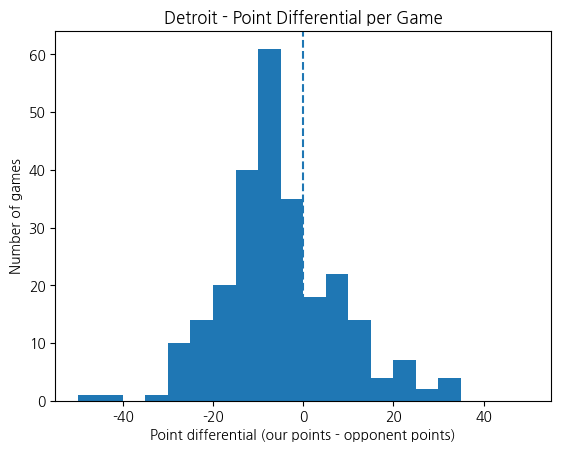

=== 요약 통계 ===
경기 수: 254
평균 득실차: -5.65  |  중앙값: -7.00  |  표준편차: 13.11
대승(≥+20): 13 경기  |  대패(≤-20): 31 경기
클러치 범위(±5점): 57 경기  |  그중 근소 패(-5~-1): 35 경기
홈 평균 득실차: -4.00  |  원정 평균 득실차: -7.28

=== 전략 제안(득실차 분포 기반) ===
1. 근소 패 다수: ATO(타임아웃 후) 플랜, 클러치 FT 라인업, 마지막 2분 턴오버 규칙(첫 패스 안전/핸드오프)
2. 원정 열세: 플레이북 단순화·세컨더리 액션 축소, 초반 얼리오펜스로 리듬 찾기, 원정 첫 타임아웃 빠르게
3. 화력 격차: 코너3/페인트 터치 KPI 지정, 슈터 그린라이트 확대, 수비 매치업 교환 최소화로 실점 런 차단


In [6]:
# =========================
# 설정
# =========================
TEAM_NAME = "Detroit"      # 예: "Detroit", "Detroit Pistons" 아무거나 포함되면 매칭
BINS = range(-50, 51, 5)   # 히스토그램 구간(점수차 -50~+50, 5점 간격)

# =========================
# 0) 사용 컬럼 확인(이름 다를 수 있어 대비)
# =========================
df = games_season2022.copy()

def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"다음 중 하나가 필요합니다: {candidates}")

HOME_TEAM = pick_col(["HOME_TEAM", "HOME_TEAM_NAME", "HomeTeam", "HOME"])
AWAY_TEAM = pick_col(["VISITOR_TEAM", "VISITOR_TEAM_NAME", "AWAY_TEAM", "AwayTeam", "AWAY"])
PTS_HOME  = pick_col(["PTS_home", "PTS_Home", "PTS_HOME", "HOME_PTS"])
PTS_AWAY  = pick_col(["PTS_away", "PTS_Away", "PTS_AWAY", "AWAY_PTS"])

# =========================
# 1) 디트로이트 경기만 추출(홈/원정 모두)
# =========================
pat = r"\b" + TEAM_NAME.lower() + r"\b"  # 단어 경계 포함(느슨하게 쓰고 싶으면 \b 제거)
is_home_team = df[HOME_TEAM].astype(str).str.lower().str.contains(pat, na=False)
is_away_team = df[AWAY_TEAM].astype(str).str.lower().str.contains(pat, na=False)
g = df.loc[is_home_team | is_away_team, [HOME_TEAM, AWAY_TEAM, PTS_HOME, PTS_AWAY]].copy()

# 점수 숫자화
g[PTS_HOME] = pd.to_numeric(g[PTS_HOME], errors="coerce")
g[PTS_AWAY] = pd.to_numeric(g[PTS_AWAY], errors="coerce")

# =========================
# 2) 득실차 계산(우리점수 - 상대점수)
# =========================
is_home = g[HOME_TEAM].astype(str).str.lower().str.contains(pat, na=False)
our_pts = np.where(is_home, g[PTS_HOME], g[PTS_AWAY])
opp_pts = np.where(is_home, g[PTS_AWAY], g[PTS_HOME])
margin = pd.Series(our_pts - opp_pts, index=g.index, name="margin").dropna()

# =========================
# 3) 히스토그램 그리기
# =========================
plt.figure()
plt.hist(margin, bins=BINS)
plt.axvline(0, linestyle="--")  # 0: 승/패 경계
plt.title(f"{TEAM_NAME} - Point Differential per Game")
plt.xlabel("Point differential (our points - opponent points)")
plt.ylabel("Number of games")
plt.show()

# =========================
# 4) 빠른 요약/해석
# =========================
mean_m = margin.mean()
med_m  = margin.median()
std_m  = margin.std()
blowout_win  = (margin >= 20).sum()
blowout_loss = (margin <= -20).sum()
close_games  = (margin.abs() <= 5).sum()
close_losses = ((margin <= -1) & (margin >= -5)).sum()

print("=== 요약 통계 ===")
print(f"경기 수: {margin.size}")
print(f"평균 득실차: {mean_m:.2f}  |  중앙값: {med_m:.2f}  |  표준편차: {std_m:.2f}")
print(f"대승(≥+20): {blowout_win} 경기  |  대패(≤-20): {blowout_loss} 경기")
print(f"클러치 범위(±5점): {close_games} 경기  |  그중 근소 패(-5~-1): {close_losses} 경기")

# 홈/원정 분리 평균(원본 컬럼 추가 없이 계산)
home_margin = margin[is_home.loc[margin.index]]
away_margin = margin[~is_home.loc[margin.index]]
if not home_margin.empty and not away_margin.empty:
    print(f"홈 평균 득실차: {home_margin.mean():.2f}  |  원정 평균 득실차: {away_margin.mean():.2f}")

# =========================
# 5) 규칙 기반 전략 제안(득실차 분포로 간단 도출)
# =========================
recs = []

# 전반 체감 성능
if mean_m <= -8:
    recs += ["전반적 열세: 페이스 안정화(불필요한 빠른 슛/턴오버 억제) + 수비리바/실점 런 차단 타임아웃 운용"]

# 대패가 많으면: 바닥 안정화
if margin.size and (blowout_loss / margin.size) >= 0.20:
    recs += ["대패 빈도↑: 전원 박스아웃/가드 크랙백 규율, 라이브볼 턴오버 감축, 러닝타임 내 세트오펜스 단순화"]

# 근소 패가 잦으면: 클러치 개선
if close_losses >= max(3, 0.25 * close_games):
    recs += ["근소 패 다수: ATO(타임아웃 후) 플랜, 클러치 FT 라인업, 마지막 2분 턴오버 규칙(첫 패스 안전/핸드오프)"]

# 원정이 특히 나쁘면: 원정 전용 전술
if not home_margin.empty and not away_margin.empty and away_margin.mean() + 3 < home_margin.mean():
    recs += ["원정 열세: 플레이북 단순화·세컨더리 액션 축소, 초반 얼리오펜스로 리듬 찾기, 원정 첫 타임아웃 빠르게"]

# 대승 거의 없고 대패가 많으면: 슈팅/스페이싱·로테이션
if blowout_win < 0.5 * blowout_loss:
    recs += ["화력 격차: 코너3/페인트 터치 KPI 지정, 슈터 그린라이트 확대, 수비 매치업 교환 최소화로 실점 런 차단"]

# 결과 출력
print("\n=== 전략 제안(득실차 분포 기반) ===")
if recs:
    for i, r in enumerate(dict.fromkeys(recs), 1):  # 중복 제거하며 순서 유지
        print(f"{i}. {r}")
else:
    print("특이 패턴이 크지 않습니다. 현재 기조 유지 + 미세조정 권장.")


## 경기 내 슛효율 비교(상대팀과 비교)

In [7]:
# ==== 설정 ====
DET = 'detroit'    # 팀명 키워드(대소문자 무시)
TH_BIG = 0.03      # "크게" 음수로 보는 기준(3%p)
TH_CLOSE = 0.01    # "비슷"한 FG% 격차 기준(±1%p)
MIN_GAMES = 5      # 최소 표본

# 필요한 칼럼만
cols = ['HOME_TEAM','VISITOR_TEAM',
        'FG_PCT_home','FG_PCT_away','FG3_PCT_home','FG3_PCT_away',
        'FT_PCT_home','FT_PCT_away']
g = games_season2022.loc[:, cols].copy()

# 디트로이트 경기만
is_home = g['HOME_TEAM'].astype(str).str.contains(DET, case=False, na=False)
is_away = g['VISITOR_TEAM'].astype(str).str.contains(DET, case=False, na=False)
g = g[is_home | is_away].copy()
if g.empty:
    raise ValueError("디트로이트 경기가 없습니다.")

# 숫자화(+ 퍼센트 문자열 제거)
to_num = lambda s: pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce')
for c in cols[2:]:
    g[c] = to_num(g[c])

# 팀/상대 슛 지표 만들기(홈/원정 자동 분기)
idx = g.index
fg_t  = np.where(is_home.loc[idx], g['FG_PCT_home'],  g['FG_PCT_away'])
fg_o  = np.where(is_home.loc[idx], g['FG_PCT_away'],  g['FG_PCT_home'])
fg3_t = np.where(is_home.loc[idx], g['FG3_PCT_home'], g['FG3_PCT_away'])
fg3_o = np.where(is_home.loc[idx], g['FG3_PCT_away'], g['FG3_PCT_home'])
ft_t  = np.where(is_home.loc[idx], g['FT_PCT_home'],  g['FT_PCT_away'])
ft_o  = np.where(is_home.loc[idx], g['FT_PCT_away'],  g['FT_PCT_home'])

# 0~100 스케일이면 0~1로 변환
def scale01(a):
    a = pd.to_numeric(a, errors='coerce')
    return a/100.0 if np.nanmax(a) > 1.001 else a

fg_t, fg_o = scale01(fg_t), scale01(fg_o)
fg3_t, fg3_o = scale01(fg3_t), scale01(fg3_o)
ft_t, ft_o = scale01(ft_t), scale01(ft_o)

# 격차(우리-상대) 계산
fg_gap  = fg_t  - fg_o
fg3_gap = fg3_t - fg3_o
ft_gap  = ft_t  - ft_o

n = len(g)
if n < MIN_GAMES:
    print(f"[알림] 표본이 적습니다: {n} < {MIN_GAMES}")

# 요약 테이블(평균 격차와 음수 비율)
summary = pd.DataFrame({
    '평균격차(our-opp, %p)': [fg_gap.mean()*100, fg3_gap.mean()*100, ft_gap.mean()*100],
    '음수비율(우리<상대)': [(fg_gap<0).mean()*100, (fg3_gap<0).mean()*100, (ft_gap<0).mean()*100]
}, index=['FG%','3P%','FT%']).round(1)
print("=== 슛 성공률 격차 요약 ===")
print(summary)

# 규칙 기반 전략 제안
recs = []

# 1) 3P% 격차 크게 음수 → 외곽 수비/스페이싱
if (fg3_gap.mean() <= -TH_BIG) or ((fg3_gap < -TH_BIG).mean() >= 0.5):
    recs += ["3P% 격차 크게 음수 → 외곽 수비/스페이싱 보완: 풀업3 억제, 드라이브→킥으로 오픈3 창출, 코너 스페이싱 강화"]

# 2) FT% 격차 크게 음수 → 자유투
if (ft_gap.mean() <= -TH_BIG) or ((ft_gap < -TH_BIG).mean() >= 0.5):
    recs += ["FT% 격차 크게 음수 → 자유투 성공률 향상: 루틴 고정·멘탈 코칭, 파울 유도 후 마무리 훈련, 클러치 고 FT% 기용"]

# 3) FG% 비슷 & 3P%만 밀림 → 셀렉션/전술
if (abs(fg_gap.mean()) <= TH_CLOSE) and (fg3_gap.mean() < -TH_BIG):
    recs += ["FG%는 비슷하지만 3P%만 밀림 → 슛 셀렉션/전술 보정: 미드레인지 비중↓, 페인트 터치 뒤 킥아웃, 플레어/해머 액션"]

# FG%가 크게 음수일 때도 처방 내기
if (fg_gap.mean() <= -TH_BIG) or ((fg_gap <= -TH_BIG).mean() >= 0.5):
    recs += ["FG% 격차 크게 음수 → 샷퀄리티/피니시 개선: 미드레인지↓, 페인트 터치↑, 림 시도↑, 드라이브→킥, PnR 롤러 타깃팅, 컷인 활성화"]

print("\n=== 전략 제안 ===")
print("\n".join(f"- {r}" for r in recs) if recs else "뚜렷한 격차 기반 이슈 없음: 현 전략 유지 + 세부 조정")


=== 슛 성공률 격차 요약 ===
     평균격차(our-opp, %p)  음수비율(우리<상대)
FG%               -3.1         67.7
3P%               -1.5         55.5
FT%               -0.7         52.8

=== 전략 제안 ===
- FG% 격차 크게 음수 → 샷퀄리티/피니시 개선: 미드레인지↓, 페인트 터치↑, 림 시도↑, 드라이브→킥, PnR 롤러 타깃팅, 컷인 활성화


In [8]:
TEAM_NAME = "Detroit"  # "Detroit" 또는 "Detroit Pistons"

df = games_season2022.copy()
# 우리 팀이 홈/원정인 경기만 고르기
m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
g = df.loc[m_home | m_away, ['HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()
# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 우리/상대 값 만들기(홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# 패한 경기만
valid = ~np.isnan(our_pts) & ~np.isnan(opp_pts) & ~np.isnan(our_ast) & ~np.isnan(opp_ast) & ~np.isnan(our_reb) & ~np.isnan(opp_reb)
lost = valid & (our_pts < opp_pts)

ast_diff = our_ast[lost] - opp_ast[lost]   # (팀AST - 상대AST)
reb_diff = our_reb[lost] - opp_reb[lost]   # (팀REB - 상대REB)

# --- 결과 요약(숫자 몇 개면 끝!) ---
print(f"패한 경기 수: {lost.sum()}")
print(f"어시스트 차이 평균(팀-상대): {pd.Series(ast_diff).mean():.2f}")
print(f"리바운드 차이 평균(팀-상대): {pd.Series(reb_diff).mean():.2f}")
print(f"어시스트가 밀린 패배 비율: {(ast_diff < 0).mean():.0%}")
print(f"리바운드가 밀린 패배 비율: {(reb_diff < 0).mean():.0%}")

# 한 줄 전략(아주 간단)
msg = []
if pd.Series(ast_diff).mean() < -2 or (ast_diff < 0).mean() > 0.6:
    msg.append("AST 개선(0.5초 룰·드라이브→킥)")
if pd.Series(reb_diff).mean() < -2 or (reb_diff < 0).mean() > 0.6:
    msg.append("REB 개선(박스아웃·가드 크랙백)")
print("전략:", ", ".join(msg) if msg else "뚜렷한 약점 없음")


패한 경기 수: 183
어시스트 차이 평균(팀-상대): -3.37
리바운드 차이 평균(팀-상대): -4.50
어시스트가 밀린 패배 비율: 71%
리바운드가 밀린 패배 비율: 69%
전략: AST 개선(0.5초 룰·드라이브→킥), REB 개선(박스아웃·가드 크랙백)


/tmp/ipykernel_194227/3307707244.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AST_DIFF, REB_DIFF], labels=['AST_DIFF', 'REB_DIFF'])


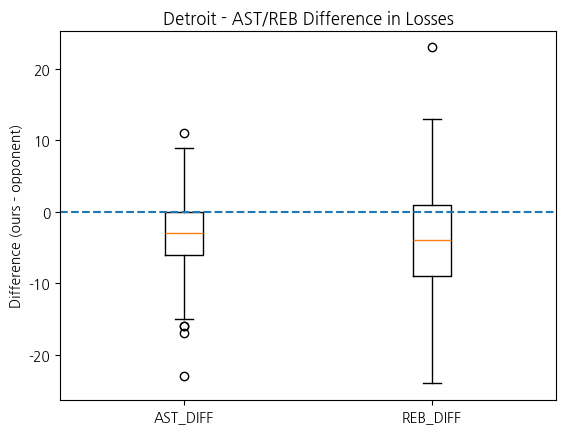


=== 패배 경기: AST/REB 차이 통계 요약 ===
          count   mean  median     var    std  min   q1   q3   iqr  max  \
AST_DIFF    183 -3.366    -3.0  28.211  5.311  -23 -6.0  0.0   6.0   11   
REB_DIFF    183 -4.497    -4.0  62.977  7.936  -24 -9.0  1.0  10.0   23   

          neg_ratio  
AST_DIFF      0.710  
REB_DIFF      0.694  


In [9]:
TEAM_NAME = "Detroit"  # 또는 "Detroit Pistons"

df = games_season2022.copy()

# 우리 팀 경기만(홈/원정 모두)
m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
g = df.loc[m_home | m_away, ['HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()

# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 팀 관점 값(홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# 패한 경기만
lost = (our_pts < opp_pts)
AST_DIFF = pd.Series(our_ast[lost] - opp_ast[lost], name='AST_DIFF').dropna()
REB_DIFF = pd.Series(our_reb[lost] - opp_reb[lost], name='REB_DIFF').dropna()


# 상자그림(음수 쪽이면 열세)
plt.figure()
plt.boxplot([AST_DIFF, REB_DIFF], labels=['AST_DIFF', 'REB_DIFF'])
plt.axhline(0, linestyle='--')
plt.title(f'{TEAM_NAME} - AST/REB Difference in Losses')
plt.ylabel('Difference (ours - opponent)')
plt.show()

stats = pd.DataFrame({
    "count":   [AST_DIFF.size,            REB_DIFF.size],
    "mean":    [AST_DIFF.mean(),          REB_DIFF.mean()],          # 평균(중심값)
    "median":  [AST_DIFF.median(),        REB_DIFF.median()],        # 중앙값(박스 가운데 선)
    "var":     [AST_DIFF.var(ddof=1),     REB_DIFF.var(ddof=1)],     # 분산(표본분산)
    "std":     [AST_DIFF.std(ddof=1),     REB_DIFF.std(ddof=1)],     # 표준편차
    "min":     [AST_DIFF.min(),           REB_DIFF.min()],
    "q1":      [AST_DIFF.quantile(0.25),  REB_DIFF.quantile(0.25)],  # 1사분위(Q1)
    "q3":      [AST_DIFF.quantile(0.75),  REB_DIFF.quantile(0.75)],  # 3사분위(Q3)
    "iqr":     [AST_DIFF.quantile(0.75)-AST_DIFF.quantile(0.25),
                REB_DIFF.quantile(0.75)-REB_DIFF.quantile(0.25)],    # IQR=Q3-Q1
    "max":     [AST_DIFF.max(),           REB_DIFF.max()],
    "neg_ratio":[(AST_DIFF < 0).mean(),   (REB_DIFF < 0).mean()]     # 음수(열세) 비율
}, index=["AST_DIFF","REB_DIFF"])

print("\n=== 패배 경기: AST/REB 차이 통계 요약 ===")
print(stats.round(3))


In [10]:
games_details_regular = load_dataset('games_details_regular', 2022)

/tmp/ipykernel_194227/2921427133.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AST_DIFF, REB_DIFF, TOV_DIFF], labels=['AST_DIFF','REB_DIFF','TOV_DIFF'])


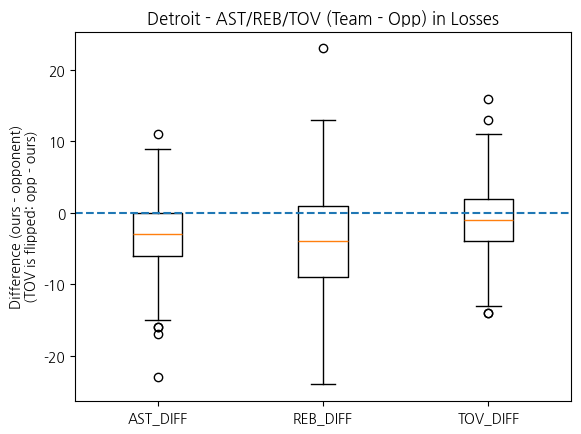

패배 경기 수(유효): 183
평균 차이: {'AST_DIFF': -3.37, 'REB_DIFF': -4.5, 'TOV_DIFF(opp-ours)': -0.89}


In [11]:
# =========================
# 0) 설정
# =========================
TEAM_NAME = "Detroit"  # 약칭만 있다면 "DET"로 바꾸세요

# =========================
# 1) 우리 팀 경기 추출 (games_season2022에서)
# =========================
df = games_season2022.copy()

m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)

# GAME_ID 포함해서 가져옵니다!
g = df.loc[m_home | m_away, ['GAME_ID','HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()

# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 우리/상대 점수·어시스트·리바운드 (홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# =========================
# 2) games_details_regular.csv에서 경기별/팀별 턴오버 합계 만들기
# =========================
gd = load_dataset('games_details_regular', 2022)

# 컬럼 이름 추정 (팀 라벨과 턴오버 컬럼을 찾습니다)
team_col_candidates = ['TEAM_NAME','TEAM','TEAM_CITY','TEAM_ABBREVIATION']
to_col_candidates   = ['TO','TOV','TURNOVERS']

TEAM_COL = next((c for c in team_col_candidates if c in gd.columns), None)
TO_COL   = next((c for c in to_col_candidates   if c in gd.columns), None)
if TEAM_COL is None or TO_COL is None:
    raise KeyError("games_details_regular.csv에 TEAM(=TEAM_NAME/TEAM_CITY/TEAM_ABBREVIATION) 또는 TO/TOV 컬럼이 필요합니다.")

gd[TEAM_COL] = gd[TEAM_COL].astype(str)
gd[TO_COL]   = pd.to_numeric(gd[TO_COL], errors='coerce')

# (A) 우리 팀 턴오버: 팀명이 TEAM_NAME을 포함한 행만 모아서 GAME_ID별 합계
our_tov_by_game = (gd[gd[TEAM_COL].str.contains(TEAM_NAME, case=False, na=False)]
                   .groupby('GAME_ID')[TO_COL].sum()
                  ).rename('OUR_TOV')

# (B) 경기 전체 턴오버 합계 → 상대 턴오버 = 전체 - 우리
total_tov_by_game = gd.groupby('GAME_ID')[TO_COL].sum().rename('TOTAL_TOV')
opp_tov_by_game   = (total_tov_by_game - our_tov_by_game).rename('OPP_TOV')

# (C) GAME_ID로 조인
g = (g.merge(our_tov_by_game, on='GAME_ID', how='left')
       .merge(opp_tov_by_game, on='GAME_ID', how='left'))

# =========================
# 3) 패배 경기만 선택 + 차이값 계산
# =========================
lost = (our_pts < opp_pts) & g['OUR_TOV'].notna() & g['OPP_TOV'].notna()

AST_DIFF = pd.Series(our_ast[lost] - opp_ast[lost], name='AST_DIFF').dropna()
REB_DIFF = pd.Series(our_reb[lost] - opp_reb[lost], name='REB_DIFF').dropna()
# 턴오버는 적을수록 좋으므로, 해석 통일을 위해 "상대 - 우리"로 뒤집습니다(음수=우리 약점).
TOV_DIFF = pd.Series(g.loc[lost, 'OPP_TOV'] - g.loc[lost, 'OUR_TOV'], name='TOV_DIFF').dropna()

# =========================
# 4) 상자그림: AST / REB / TOV 나란히
# =========================
plt.figure()
plt.boxplot([AST_DIFF, REB_DIFF, TOV_DIFF], labels=['AST_DIFF','REB_DIFF','TOV_DIFF'])
plt.axhline(0, linestyle='--')
plt.title(f'{TEAM_NAME} - AST/REB/TOV (Team - Opp) in Losses')
plt.ylabel('Difference (ours - opponent)\n(TOV is flipped: opp - ours)')
plt.show()

# (선택) 간단 숫자 요약
print("패배 경기 수(유효):", int(lost.sum()))
print("평균 차이:", pd.Series({
    'AST_DIFF': AST_DIFF.mean(),
    'REB_DIFF': REB_DIFF.mean(),
    'TOV_DIFF(opp-ours)': TOV_DIFF.mean()
}).round(2).to_dict())

## 유림님 시각화

In [12]:
# ===== 사용자 설정 =====
TEAM_KEY = "detroit"
TARGET_SEASONS = ["2019-20","2020-21","2021-22","2022-23"]
games = load_dataset("games_regular", season="2022")  # 2022 폴더 안에 있는 파일 불러오기

# ===== 데이터 불러오기 =====
# games = load_dataset("games_regular")   # 자동으로 csv 읽고 parse_dates 처리
ranking = load_dataset("ranking_regular", season="2022")
  # 티어 산출에 쓰려면

In [13]:
# games_details_regular.csv 불러오기
games_details = load_dataset("games_details_regular", 2022)

display(games_details)


,DATE,GAME_ID,SEASON,TEAM,TEAM_LVL,PLAYER_ID,START_POSITION,MIN,FGM,FGA,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,2019-10-22,21900002,2019,L.A. Clippers,상위팀,202695,F,31.550000,10,19,...,1,5.0,6,5,2,1,6,5,30,5
1,2019-10-22,21900002,2019,L.A. Clippers,상위팀,101150,SUB,36.716667,8,14,...,1,4.0,5,7,1,0,2,0,21,13
2,2019-10-22,21900002,2019,L.A. Clippers,상위팀,1626149,SUB,38.366667,7,11,...,2,5.0,7,4,1,1,3,3,17,15
3,2019-10-22,21900002,2019,L.A. Clippers,상위팀,201976,G,31.350000,1,7,...,2,8.0,10,6,0,1,2,4,2,13
4,2019-10-22,21900002,2019,L.A. Clippers,상위팀,1629013,G,26.450000,3,8,...,0,3.0,3,2,0,0,0,1,8,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87373,2022-12-22,22200478,2022,Washington,중위팀,201959,SUB,25.033333,3,3,...,0,4.0,4,1,1,0,0,3,6,-3
87374,2022-12-22,22200478,2022,Washington,중위팀,1628420,G,30.266667,2,5,...,0,4.0,4,4,0,0,2,1,5,3
87375,2022-12-22,22200478,2022,Washington,중위팀,203078,G,31.083333,13,20,...,1,4.0,5,5,0,0,2,2,30,4
87376,2022-12-22,22200478,2022,Utah,상위팀,1631117,C,32.383333,5,7,...,5,9.0,14,1,0,2,1,2,12,16


In [14]:
# 0) 시즌 컬럼 확보: 있으면 쓰고, 없으면 대체/생성
cand_season = ["SEASON", "SEASON_YEAR", "SEASON_ID", "YEAR"]
cand_date   = ["DATE", "GAME_DATE", "GAME_DATE_EST"]

def first_col(games_details, cands):
    for c in cands:
        if c in games_details.columns: 
            return c
    return None

season_col = first_col(games_details, cand_season)

if season_col is None:
    date_col = first_col(games_details, cand_date)
    if date_col is not None:
        # 날짜에서 '연도'로 시즌 대체 (사용자 요청: 그냥 2019, 2020 …로 보기)
        games_details[date_col] = pd.to_datetime(games_details[date_col], errors="coerce")
        games_details["SEASON"] = games_details[date_col].dt.year
        season_col = "SEASON"
    else:
        raise KeyError("시즌/날짜 컬럼을 찾지 못했습니다. df.columns를 확인해주세요.")

# 1) 경기 단위 FG% 계산
games_details["FG%"] = pd.to_numeric(games_details["FGM"], errors="coerce") / pd.to_numeric(games_details["FGA"], errors="coerce") * 100

# 2) 시즌별 평균 FG% 확인
print(games_details.groupby(season_col)["FG%"].mean().sort_index())


SEASON
2019    44.778193
2020    45.326485
2021    45.018898
2022    46.287044
Name: FG%, dtype: float64


In [15]:
games_details["FG%"] = games_details["FGM"] / games_details["FGA"] * 100
print(games_details.groupby("SEASON")["FG%"].mean())


SEASON
2019    44.778193
2020    45.326485
2021    45.018898
2022    46.287044
Name: FG%, dtype: float64


로딩 완료: (87378, 27)
컬럼 미리보기: ['DATE', 'GAME_ID', 'SEASON', 'TEAM', 'TEAM_LVL', 'PLAYER_ID', 'START_POSITION', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB']
상위팀 19-21: {'FG%': np.float64(47.24), '3P%': np.float64(37.0), 'FT%': np.float64(78.98), 'eFG%': np.float64(54.64), 'TS%': np.float64(58.18)}
디트로이트 19-21: {'FG%': np.float64(44.57), '3P%': np.float64(34.6), 'FT%': np.float64(76.29), 'eFG%': np.float64(51.24), 'TS%': np.float64(54.89)}
상위팀 22-23: {'FG%': np.float64(47.04), '3P%': np.float64(36.84), 'FT%': np.float64(77.69), 'eFG%': np.float64(54.44), 'TS%': np.float64(57.9)}
디트로이트 22-23: {'FG%': np.float64(44.94), '3P%': np.float64(34.55), 'FT%': np.float64(77.5), 'eFG%': np.float64(51.46), 'TS%': np.float64(55.81)}


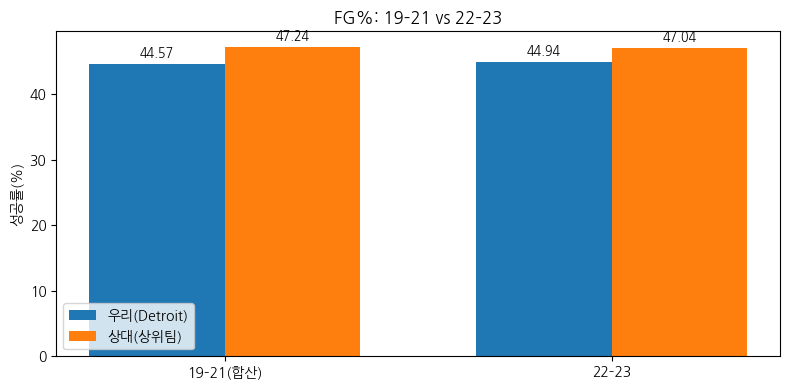

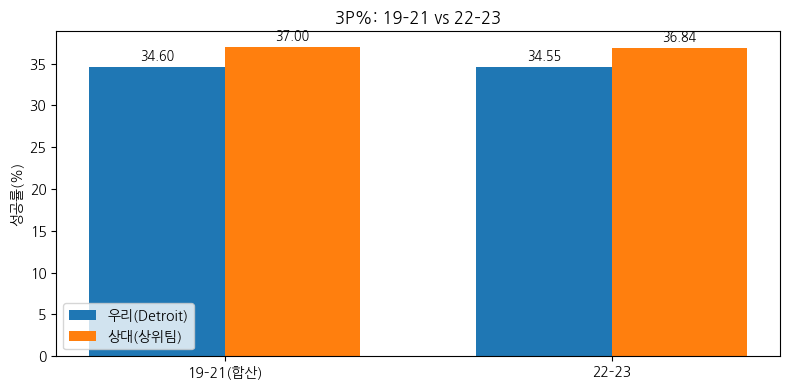

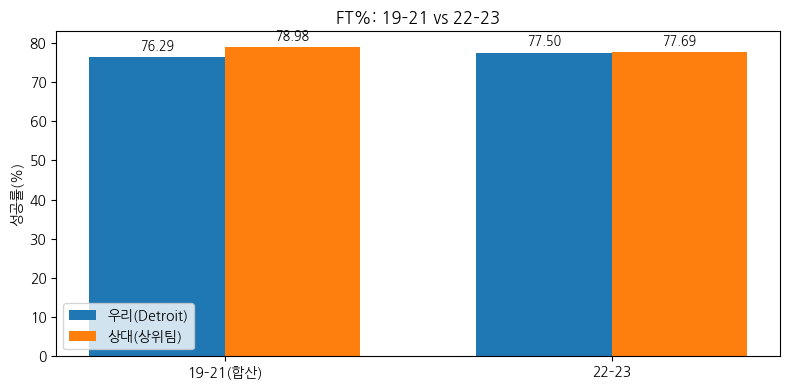

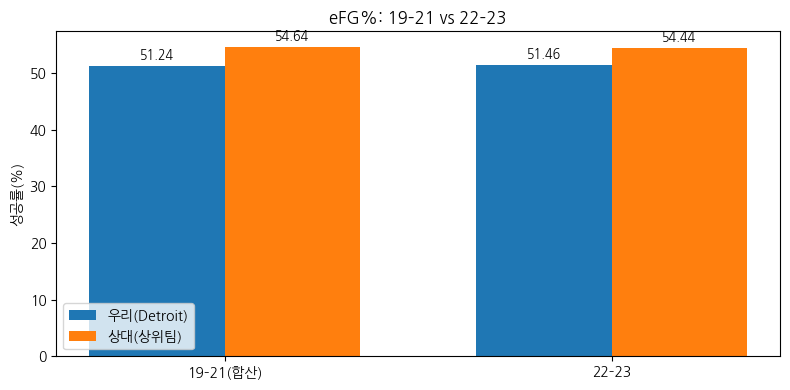

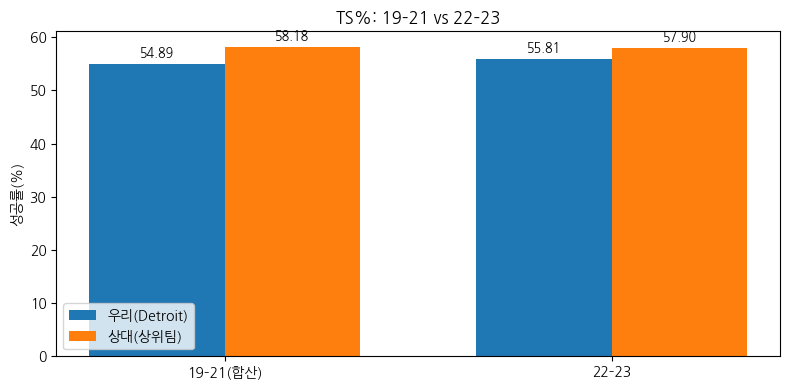

In [16]:
# ─────────────────────────────────────────────────────────────
# 0) 라이브러리 & 데이터 로드 (load_dataset 사용)
# ─────────────────────────────────────────────────────────────
# 1) 데이터 불러오기 (이제 절대경로 필요 없음)
games_details = load_dataset("games_details_regular", 2022)
print("로딩 완료:", games_details.shape)
print("컬럼 미리보기:", list(games_details.columns)[:20])

# ─────────────────────────────────────────────────────────────
# 1-1) 컬럼명 후보 정리(환경마다 다를 수 있어서 자동 매핑)
# ─────────────────────────────────────────────────────────────
CANDIDATES = {
    "TEAM" : ["TEAM", "TEAM_NAME"],
    "SEASON" : ["SEASON", "SEASON_YEAR"],
    "TEAM_LVL" : ["TEAM_LVL", "TEAM_LEVEL", "TEAM_TIER"],

    "FGM" : ["FGM", "FG"],
    "FGA" : ["FGA", "FGAtt"],

    "FG3M": ["FG3M", "3PM", "FG3"],
    "FG3A": ["FG3A", "3PA"],

    "FTM" : ["FTM", "FT"],
    "FTA" : ["FTA"],

    "PTS" : ["PTS", "POINTS"],
}

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"다음 후보 중 컬럼을 찾지 못함: {candidates}")

COL = {k: pick_col(games_details, v) for k,v in CANDIDATES.items()}

# ─────────────────────────────────────────────────────────────
# 2) 필요한 컬럼만 추리고 숫자 변환
# ─────────────────────────────────────────────────────────────
use_cols = [COL["TEAM"], COL["SEASON"], COL["TEAM_LVL"],
            COL["FGM"], COL["FGA"], COL["FG3M"], COL["FG3A"],
            COL["FTM"], COL["FTA"], COL["PTS"]]
df = games_details.loc[:, use_cols].copy()

num_cols = [COL["FGM"], COL["FGA"], COL["FG3M"], COL["FG3A"], COL["FTM"], COL["FTA"], COL["PTS"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ─────────────────────────────────────────────────────────────
# 3) 조건 만들기
#    - 상위팀: TEAM_LVL == "상위팀"
#    - 디트로이트: TEAM == "Detroit"   (※ 만약 'Detroit Pistons'라면 문자열 바꿔줘)
#    - 2019~2021 / 2022(=22-23 시즌)
# ─────────────────────────────────────────────────────────────
cond_upper = (df[COL["TEAM_LVL"]] == "상위팀")
cond_det   = (df[COL["TEAM"]] == "Detroit")  # 필요시 "Detroit Pistons" 등으로 변경

cond_19_21 = df[COL["SEASON"]].isin([2019, 2020, 2021])
cond_22    = (df[COL["SEASON"]] == 2022)     # 22-23 시즌

# ─────────────────────────────────────────────────────────────
# 4) 합계 → 효율(%) 계산 함수
# ─────────────────────────────────────────────────────────────
def _sum_box(d):
    return {
        "FGM": d[COL["FGM"]].sum(skipna=True),
        "FGA": d[COL["FGA"]].sum(skipna=True),
        "FG3M": d[COL["FG3M"]].sum(skipna=True),
        "FG3A": d[COL["FG3A"]].sum(skipna=True),
        "FTM": d[COL["FTM"]].sum(skipna=True),
        "FTA": d[COL["FTA"]].sum(skipna=True),
        "PTS": d[COL["PTS"]].sum(skipna=True),
    }

def _safe_div(a, b):
    if b is None or pd.isna(b) or b == 0:
        return np.nan
    return a / b

def calc_rates(sumd):
    FGM, FGA = sumd["FGM"], sumd["FGA"]
    FG3M, FG3A = sumd["FG3M"], sumd["FG3A"]
    FTM, FTA = sumd["FTM"], sumd["FTA"]
    PTS = sumd["PTS"]

    FG  = _safe_div(FGM, FGA)
    TP  = _safe_div(FG3M, FG3A)
    FT  = _safe_div(FTM, FTA)
    eFG = _safe_div(FGM + 0.5*FG3M, FGA)
    TS  = _safe_div(PTS, 2*(FGA + 0.44*FTA))

    return {
        "FG%":  None if pd.isna(FG)  else round(FG*100, 2),
        "3P%":  None if pd.isna(TP)  else round(TP*100, 2),
        "FT%":  None if pd.isna(FT)  else round(FT*100, 2),
        "eFG%": None if pd.isna(eFG) else round(eFG*100, 2),
        "TS%":  None if pd.isna(TS)  else round(TS*100, 2),
    }

# ─────────────────────────────────────────────────────────────
# 5) 4가지 경우 계산
#    A. 상위팀 19-21   B. 디트로이트 19-21
#    C. 상위팀 22-23   D. 디트로이트 22-23
# ─────────────────────────────────────────────────────────────
rate_upper_19_21 = calc_rates(_sum_box(df[cond_upper & cond_19_21]))
rate_det_19_21   = calc_rates(_sum_box(df[cond_det   & cond_19_21]))
rate_upper_22     = calc_rates(_sum_box(df[cond_upper & cond_22]))
rate_det_22       = calc_rates(_sum_box(df[cond_det   & cond_22]))

print("상위팀 19-21:", rate_upper_19_21)
print("디트로이트 19-21:", rate_det_19_21)
print("상위팀 22-23:", rate_upper_22)
print("디트로이트 22-23:", rate_det_22)

# ─────────────────────────────────────────────────────────────
# 6) 막대그래프(초간단)
#    x축: 19-21 vs 22-23 / 막대: 우리(Detroit), 상대(상위팀)
#    ※ 색상 지정 안 함(기본값)
# ─────────────────────────────────────────────────────────────
def draw_two_group_bar(title, det_early, opp_early, det_recent, opp_recent):
    labels = ["19–21(합산)", "22–23"]
    our = [det_early, det_recent]
    opp = [opp_early, opp_recent]

    x = np.arange(len(labels))
    w = 0.35

    fig, ax = plt.subplots(figsize=(8,4))
    r1 = ax.bar(x - w/2, our, width=w, label="우리(Detroit)")
    r2 = ax.bar(x + w/2, opp, width=w, label="상대(상위팀)")

    ax.set_title(f"{title}: 19–21 vs 22–23")
    ax.set_xticks(x, labels)
    ax.set_ylabel("성공률(%)")
    ax.legend()

    # 값 라벨
    for rects in [r1, r2]:
        for r in rects:
            h = r.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(r.get_x()+r.get_width()/2, h),
                        xytext=(0,3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

# 5개 지표 그리기
draw_two_group_bar("FG%",  rate_det_19_21["FG%"],  rate_upper_19_21["FG%"],  rate_det_22["FG%"],  rate_upper_22["FG%"])
draw_two_group_bar("3P%",  rate_det_19_21["3P%"],  rate_upper_19_21["3P%"],  rate_det_22["3P%"],  rate_upper_22["3P%"])
draw_two_group_bar("FT%",  rate_det_19_21["FT%"],  rate_upper_19_21["FT%"],  rate_det_22["FT%"],  rate_upper_22["FT%"])
draw_two_group_bar("eFG%", rate_det_19_21["eFG%"], rate_upper_19_21["eFG%"], rate_det_22["eFG%"], rate_upper_22["eFG%"])
draw_two_group_bar("TS%",  rate_det_19_21["TS%"],  rate_upper_19_21["TS%"],  rate_det_22["TS%"],  rate_upper_22["TS%"])


/tmp/ipykernel_194227/3125529600.py:51: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/yeeun/anaconda3/envs/sparta/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


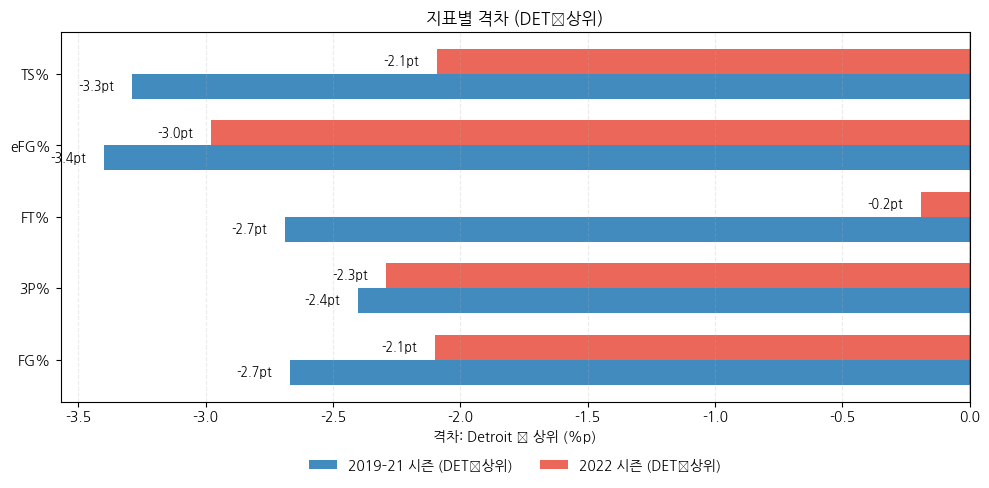

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 지표와 격차(DET − 상위) 계산
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

diff_19_21 = {m: (rate_det_19_21[m] - rate_upper_19_21[m]) for m in metrics}
diff_22     = {m: (rate_det_22[m]     - rate_upper_22[m])     for m in metrics}

# (옵션) 22 시즌 격차가 큰 순으로 정렬하고 싶으면 True
sort_by_recent = False
if sort_by_recent:
    order = sorted(metrics, key=lambda m: diff_22[m], reverse=True)
else:
    order = metrics

vals_19_21 = [diff_19_21[m] for m in order]
vals_22    = [diff_22[m]    for m in order]

# 2) 시각화
y = np.arange(len(order)); h = 0.35
fig, ax = plt.subplots(figsize=(10,5))

b1 = ax.barh(y - h/2, vals_19_21, h, color="#1f77b4", alpha=0.85, label="2019–21 시즌 (DET−상위)")
b2 = ax.barh(y + h/2, vals_22,    h, color="#e74c3c", alpha=0.85, label="2022 시즌 (DET−상위)")

# 기준선/격자/축
ax.axvline(0, color="black", lw=1)
ax.grid(axis="x", linestyle="--", alpha=0.25)
ax.set_yticks(y); ax.set_yticklabels(order)
ax.set_xlabel("격차: Detroit − 상위 (%p)")
ax.set_title("지표별 격차 (DET−상위)" + (" — 2022에서 큰 순 정렬" if sort_by_recent else ""))

# 막대 바깥에 값 라벨(퍼센트포인트)
def annotate_outside(bars):
    xmin, xmax = ax.get_xlim(); pad = 0.02*(xmax-xmin or 1)
    for bar in bars:
        w  = bar.get_width()
        yc = bar.get_y() + bar.get_height()/2
        if np.isnan(w): 
            continue
        if w >= 0:
            ax.annotate(f"{w:+.1f}pt", (w + pad, yc), ha="left",  va="center", fontsize=9)
        else:
            ax.annotate(f"{w:+.1f}pt", (w - pad, yc), ha="right", va="center", fontsize=9)

annotate_outside(b1)
annotate_outside(b2)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


In [18]:
# 조건
cond_upper = (df["TEAM_LVL"] == "상위팀")
cond_det   = (df["TEAM"] == "Detroit")   # 필요시 "Detroit Pistons"

cond_early  = df["SEASON"].isin([2019,2020,2021])
cond_recent = (df["SEASON"] == 2022)

# 합산 & 효율 함수
def safe_div(a,b): return np.nan if (b is None or b==0 or pd.isna(b)) else a/b

def sum_box(d):
    return {
        "FGM": d["FGM"].sum(),
        "FGA": d["FGA"].sum(),
        "FG3M": d["FG3M"].sum(),
        "FG3A": d["FG3A"].sum(),
        "FTM": d["FTM"].sum(),
        "FTA": d["FTA"].sum(),
        "PTS": d["PTS"].sum(),
    }

def calc_rates(s):
    FGM,FGA,FG3M,FG3A,FTM,FTA,PTS = s["FGM"],s["FGA"],s["FG3M"],s["FG3A"],s["FTM"],s["FTA"],s["PTS"]
    FG  = safe_div(FGM,FGA)
    TP  = safe_div(FG3M,FG3A)
    FT  = safe_div(FTM,FTA)
    eFG = safe_div(FGM+0.5*FG3M,FGA)
    TS  = safe_div(PTS,2*(FGA + 0.44*FTA))
    to_pct = lambda x: None if pd.isna(x) else round(x*100,2)
    return {"FG%":to_pct(FG),"3P%":to_pct(TP),"FT%":to_pct(FT),"eFG%":to_pct(eFG),"TS%":to_pct(TS)}

# 계산
rate_upper_early  = calc_rates(sum_box(df[cond_upper & cond_early]))
rate_det_early    = calc_rates(sum_box(df[cond_det   & cond_early]))
rate_upper_recent = calc_rates(sum_box(df[cond_upper & cond_recent]))
rate_det_recent   = calc_rates(sum_box(df[cond_det   & cond_recent]))

print("상위팀 19-21:", rate_upper_early)
print("디트로이트 19-21:", rate_det_early)
print("상위팀 22:", rate_upper_recent)
print("디트로이트 22:", rate_det_recent)


상위팀 19-21: {'FG%': np.float64(47.24), '3P%': np.float64(37.0), 'FT%': np.float64(78.98), 'eFG%': np.float64(54.64), 'TS%': np.float64(58.18)}
디트로이트 19-21: {'FG%': np.float64(44.57), '3P%': np.float64(34.6), 'FT%': np.float64(76.29), 'eFG%': np.float64(51.24), 'TS%': np.float64(54.89)}
상위팀 22: {'FG%': np.float64(47.04), '3P%': np.float64(36.84), 'FT%': np.float64(77.69), 'eFG%': np.float64(54.44), 'TS%': np.float64(57.9)}
디트로이트 22: {'FG%': np.float64(44.94), '3P%': np.float64(34.55), 'FT%': np.float64(77.5), 'eFG%': np.float64(51.46), 'TS%': np.float64(55.81)}


In [19]:
# 전체 시즌 조건
cond_upper_all = (df["TEAM_LVL"] == "상위팀")
cond_det_all   = (df["TEAM"] == "Detroit")   # 필요시 'Detroit Pistons'

# 합산 → 효율 계산
rate_upper_all = calc_rates(sum_box(df[cond_upper_all]))
rate_det_all   = calc_rates(sum_box(df[cond_det_all]))

print("상위팀 전체 시즌:", rate_upper_all)
print("디트로이트 전체 시즌:", rate_det_all)


상위팀 전체 시즌: {'FG%': np.float64(47.22), '3P%': np.float64(36.98), 'FT%': np.float64(78.84), 'eFG%': np.float64(54.62), 'TS%': np.float64(58.15)}
디트로이트 전체 시즌: {'FG%': np.float64(44.62), '3P%': np.float64(34.59), 'FT%': np.float64(76.48), 'eFG%': np.float64(51.27), 'TS%': np.float64(55.01)}


In [20]:
print(df["SEASON"].value_counts().sort_index())


SEASON
2019    24097
2020    25053
2021    28045
2022    10183
Name: count, dtype: int64


상위팀 전체 시즌: {'FG%': np.float64(47.22), '3P%': np.float64(36.98), 'FT%': np.float64(78.84), 'eFG%': np.float64(54.62), 'TS%': np.float64(58.15)}
디트로이트 전체 시즌: {'FG%': np.float64(44.62), '3P%': np.float64(34.59), 'FT%': np.float64(76.48), 'eFG%': np.float64(51.27), 'TS%': np.float64(55.01)}


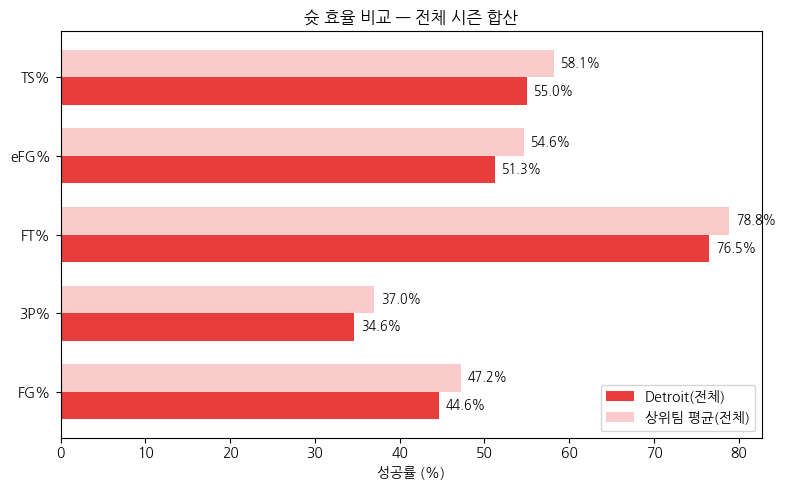

In [21]:
# ── 0) 데이터 로드 ─────────────────────────────────────────

df = load_dataset("games_details_regular", 2022)

# 필요한 컬럼만 (이름이 다르면 맞춰서 바꿔줘)
use = ["TEAM","TEAM_LVL","FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]
df = df.loc[:, use].copy()

for c in ["FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ── 1) 합산 → 효율 함수 ───────────────────────────────────
def _safe_div(a,b): 
    return np.nan if (b is None or pd.isna(b) or b==0) else a/b

def sum_box(d):
    return {
        "FGM": d["FGM"].sum(), "FGA": d["FGA"].sum(),
        "FG3M": d["FG3M"].sum(), "FG3A": d["FG3A"].sum(),
        "FTM": d["FTM"].sum(), "FTA": d["FTA"].sum(),
        "PTS": d["PTS"].sum(),
    }

def calc_rates(s):
    FGM,FGA,FG3M,FG3A,FTM,FTA,PTS = s["FGM"],s["FGA"],s["FG3M"],s["FG3A"],s["FTM"],s["FTA"],s["PTS"]
    FG  = _safe_div(FGM, FGA)
    TP  = _safe_div(FG3M, FG3A)
    FT  = _safe_div(FTM, FTA)
    eFG = _safe_div(FGM + 0.5*FG3M, FGA)
    TS  = _safe_div(PTS, 2*(FGA + 0.44*FTA))
    to_pct = lambda x: None if pd.isna(x) else round(x*100,2)
    return {"FG%":to_pct(FG), "3P%":to_pct(TP), "FT%":to_pct(FT), "eFG%":to_pct(eFG), "TS%":to_pct(TS)}

# ── 2) 전체 시즌: 상위팀 vs Detroit ────────────────────────
cond_upper_all = (df["TEAM_LVL"] == "상위팀")
cond_det_all   = (df["TEAM"] == "Detroit")  # 필요시 'Detroit Pistons'로 변경

rate_upper_all = calc_rates(sum_box(df[cond_upper_all]))
rate_det_all   = calc_rates(sum_box(df[cond_det_all]))

print("상위팀 전체 시즌:", rate_upper_all)
print("디트로이트 전체 시즌:", rate_det_all)

# ── 3) (옵션) 한 장 요약 그래프 ───────────────────────────
metrics = ["FG%","3P%","FT%","eFG%","TS%"]
det_vals   = [rate_det_all[m]   for m in metrics]
upper_vals = [rate_upper_all[m] for m in metrics]

y = np.arange(len(metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(8,5))
b1 = ax.barh(y - h/2, det_vals,   h, label="Detroit(전체)", color="#e73d3d")
b2 = ax.barh(y + h/2, upper_vals, h, label="상위팀 평균(전체)", color="#f7b9b9bc")

ax.set_title("슛 효율 비교 — 전체 시즌 합산")
ax.set_xlabel("성공률 (%)")
ax.set_yticks(y); ax.set_yticklabels(metrics)
ax.legend()

for bars in [b1,b2]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%", (w, bar.get_y()+bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points", va="center", fontsize=9)

plt.tight_layout(); plt.show()



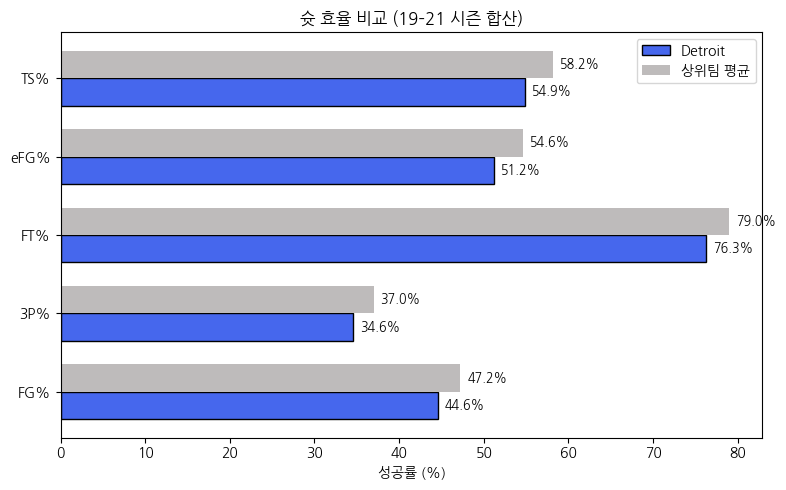

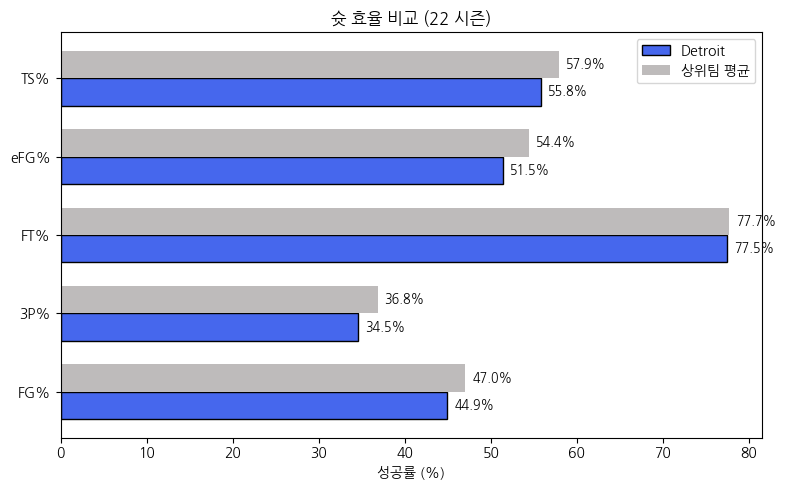

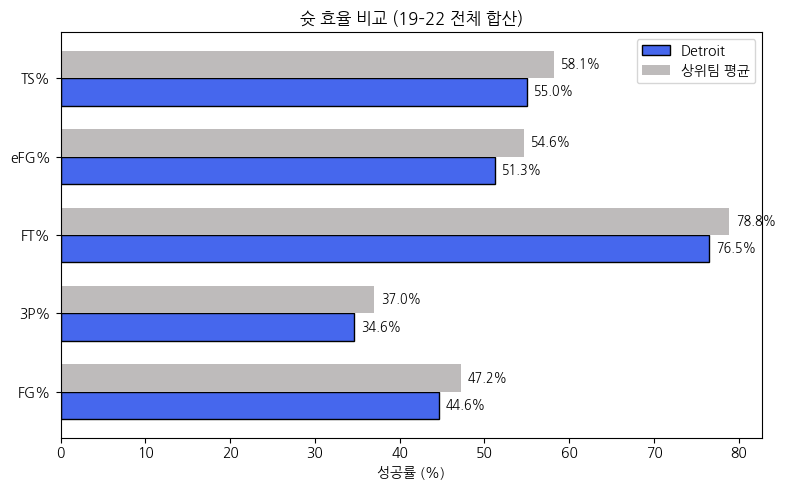

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 공통 지표
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

def draw_two_group_barh(title, det_dict, upper_dict):
    """Detroit vs 상위팀 한 장 그래프 (가로 막대, 값 라벨 포함)"""
    det_vals   = [det_dict[m]   for m in metrics]
    upper_vals = [upper_dict[m] for m in metrics]

    y = np.arange(len(metrics))
    h = 0.35  # 막대 높이

    fig, ax = plt.subplots(figsize=(8,5))
    bars1 = ax.barh(y - h/2, det_vals,   h, label="Detroit",       color="#4667ed", edgecolor="black")
    bars2 = ax.barh(y + h/2, upper_vals, h, label="상위팀 평균",    color="#bebbbb")

    ax.set_title(title)
    ax.set_xlabel("성공률 (%)")
    ax.set_yticks(y)
    ax.set_yticklabels(metrics)
    ax.legend()

    # 값 라벨
    for bars in [bars1, bars2]:
        for bar in bars:
            w = bar.get_width()
            ax.annotate(f"{w:.1f}%",
                        xy=(w, bar.get_y()+bar.get_height()/2),
                        xytext=(5, 0),
                        textcoords="offset points",
                        va="center", fontsize=9)
    plt.tight_layout()
    plt.show()

# 1) 19–21 시즌 합산
draw_two_group_barh("슛 효율 비교 (19–21 시즌 합산)",
                    rate_det_early, rate_upper_early)

# 2) 22 시즌
draw_two_group_barh("슛 효율 비교 (22 시즌)",
                    rate_det_recent, rate_upper_recent)

# 3) 19–22 (cond_early ∪ cond_recent, 합집합 전체)
draw_two_group_barh("슛 효율 비교 (19–22 전체 합산)",
                    rate_det_all, rate_upper_all)


상위팀 19–21: {'FG%': np.float64(47.24), '3P%': np.float64(37.0), 'FT%': np.float64(78.98), 'eFG%': np.float64(54.64), 'TS%': np.float64(58.18)}
디트로이트 19–21: {'FG%': np.float64(44.57), '3P%': np.float64(34.6), 'FT%': np.float64(76.29), 'eFG%': np.float64(51.24), 'TS%': np.float64(54.89)}
상위팀 22: {'FG%': np.float64(47.04), '3P%': np.float64(36.84), 'FT%': np.float64(77.69), 'eFG%': np.float64(54.44), 'TS%': np.float64(57.9)}
디트로이트 22: {'FG%': np.float64(44.94), '3P%': np.float64(34.55), 'FT%': np.float64(77.5), 'eFG%': np.float64(51.46), 'TS%': np.float64(55.81)}


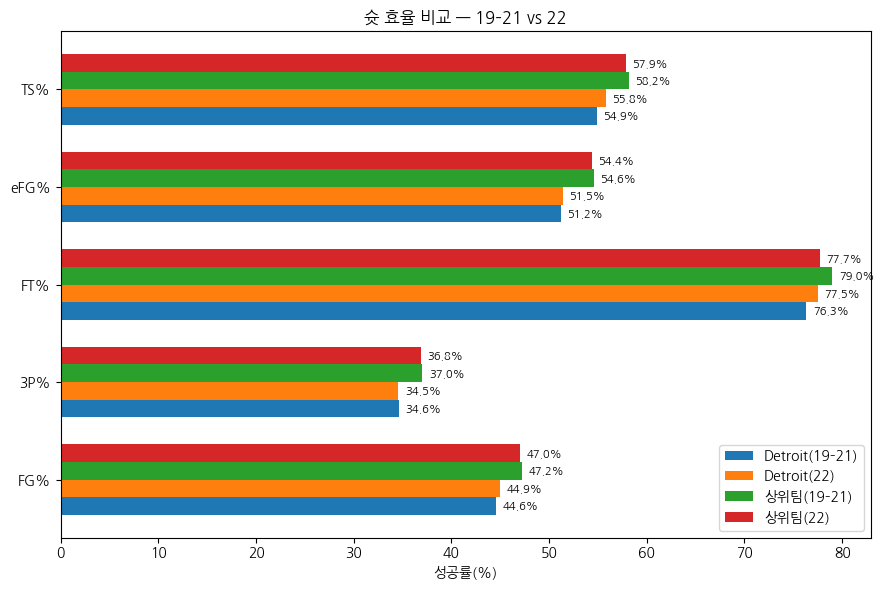

In [23]:
df = load_dataset('games_details_regular', '2022')

# ── 4) 기간 조건 만들기 (안전 버전) ────────────────────────
# 4-1) 시즌/날짜 컬럼 찾기
season_candidates = ["SEASON", "SEASON_YEAR", "SEASON_ID", "YEAR"]
date_candidates   = ["DATE", "GAME_DATE", "GAME_DATE_EST"]

def first_col(df, cands
              ):
    for c in cands:
        if c in df.columns:
            return c
    return None

season_col = first_col(df, season_candidates)

if season_col is None:
    date_col = first_col(df, date_candidates)
    if date_col is None:
        raise KeyError("SEASON/DATE 컬럼이 없어 기간 조건을 만들 수 없어요.")
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["SEASON_TMP"] = df[date_col].dt.year
    season_col = "SEASON_TMP"

# 4-2) 기간 조건
cond_early  = df[season_col].isin([2019, 2020, 2021])
cond_recent = (df[season_col] == 2022)

# ── 5) 4가지 케이스 효율 계산 ─────────────────────────────
rate_upper_early  = calc_rates(sum_box(df[(df["TEAM_LVL"]=="상위팀") & cond_early]))
rate_det_early    = calc_rates(sum_box(df[(df["TEAM"]=="Detroit") & cond_early]))   # 필요시 "Detroit Pistons"
rate_upper_recent = calc_rates(sum_box(df[(df["TEAM_LVL"]=="상위팀") & cond_recent]))
rate_det_recent   = calc_rates(sum_box(df[(df["TEAM"]=="Detroit") & cond_recent]))

print("상위팀 19–21:", rate_upper_early)
print("디트로이트 19–21:", rate_det_early)
print("상위팀 22:", rate_upper_recent)
print("디트로이트 22:", rate_det_recent)

# ── 6) (옵션) 한 장에 비교 그래프 ─────────────────────────
import numpy as np
import matplotlib.pyplot as plt

metrics = ["FG%","3P%","FT%","eFG%","TS%"]
det_early_vals   = [rate_det_early[m]    for m in metrics]
det_recent_vals  = [rate_det_recent[m]   for m in metrics]
upper_early_vals = [rate_upper_early[m]  for m in metrics]
upper_recent_vals= [rate_upper_recent[m] for m in metrics]

y = np.arange(len(metrics)); h = 0.18
fig, ax = plt.subplots(figsize=(9,6))
b1 = ax.barh(y - 1.5*h, det_early_vals,   h, label="Detroit(19–21)")
b2 = ax.barh(y - 0.5*h, det_recent_vals,  h, label="Detroit(22)")
b3 = ax.barh(y + 0.5*h, upper_early_vals, h, label="상위팀(19–21)")
b4 = ax.barh(y + 1.5*h, upper_recent_vals,h, label="상위팀(22)")

ax.set_title("슛 효율 비교 — 19–21 vs 22")
ax.set_xlabel("성공률(%)")
ax.set_yticks(y); ax.set_yticklabels(metrics)
ax.legend(loc="lower right")

for bars in [b1,b2,b3,b4]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%", (w, bar.get_y()+bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", fontsize=8)

plt.tight_layout(); plt.show()


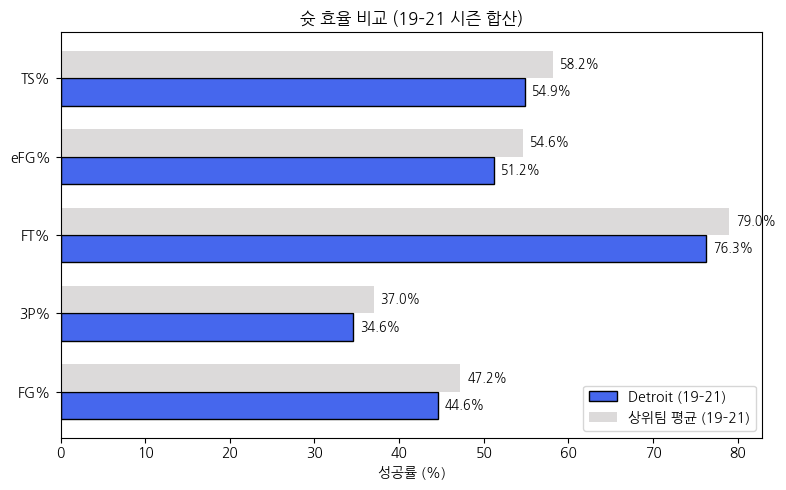

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 지표 이름
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 디트로이트 & 상위팀 값 (19–21)
det_values  = [rate_det_early[m]   for m in metrics]
upper_values= [rate_upper_early[m] for m in metrics]

# 그래프 설정
y = np.arange(len(metrics))  # y축 위치
h = 0.35  # 막대 높이

fig, ax = plt.subplots(figsize=(8,5))

# Detroit = 빨간색, 상위팀 = 회색
bars1 = ax.barh(y - h/2, det_values, h, edgecolor="black", label="Detroit (19–21)", color="#4667ed")
bars2 = ax.barh(y + h/2, upper_values, h, label="상위팀 평균 (19–21)", color="#bebbbb89")

# 라벨/타이틀
ax.set_xlabel("성공률 (%)")
ax.set_title("슛 효율 비교 (19–21 시즌 합산)")
ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.legend()

# 값 라벨 표시
for bars in [bars1, bars2]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%",
                    xy=(w, bar.get_y() + bar.get_height()/2),
                    xytext=(5,0),
                    textcoords="offset points",
                    va="center", fontsize=9)

plt.tight_layout()
plt.show()


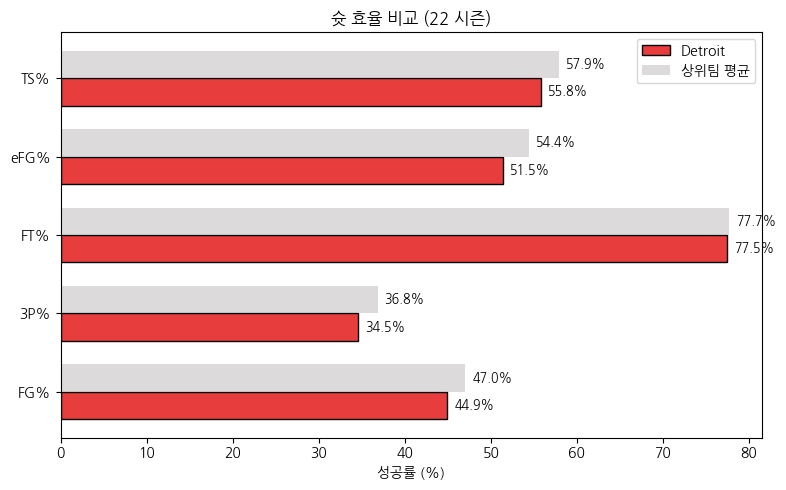

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 지표 이름
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 디트로이트 & 상위팀 값 (19–21 vs 22)
# 여기서는 예시로 이전 단계에서 계산한 rate_* dict을 사용
det_values  = [rate_det_recent[m]   for m in metrics]
upper_values= [rate_upper_recent[m] for m in metrics]

# 그래프 설정
y = np.arange(len(metrics))  # y축 위치
h = 0.35  # 막대 높이

fig, ax = plt.subplots(figsize=(8,5))

# Detroit = 파란색, 상위팀 = 회색
bars1 = ax.barh(y - h/2, det_values, h, edgecolor="black", label="Detroit", color="#e73d3d")
bars2 = ax.barh(y + h/2, upper_values, h, label="상위팀 평균", color="#bebbbb89")

# 라벨/타이틀
ax.set_xlabel("성공률 (%)")
ax.set_title("슛 효율 비교 (22 시즌)")
ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.legend()

# 값 라벨 표시
for bars in [bars1, bars2]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%",
                    xy=(w, bar.get_y() + bar.get_height()/2),
                    xytext=(5,0),
                    textcoords="offset points",
                    va="center", fontsize=9)

plt.tight_layout()
plt.show()


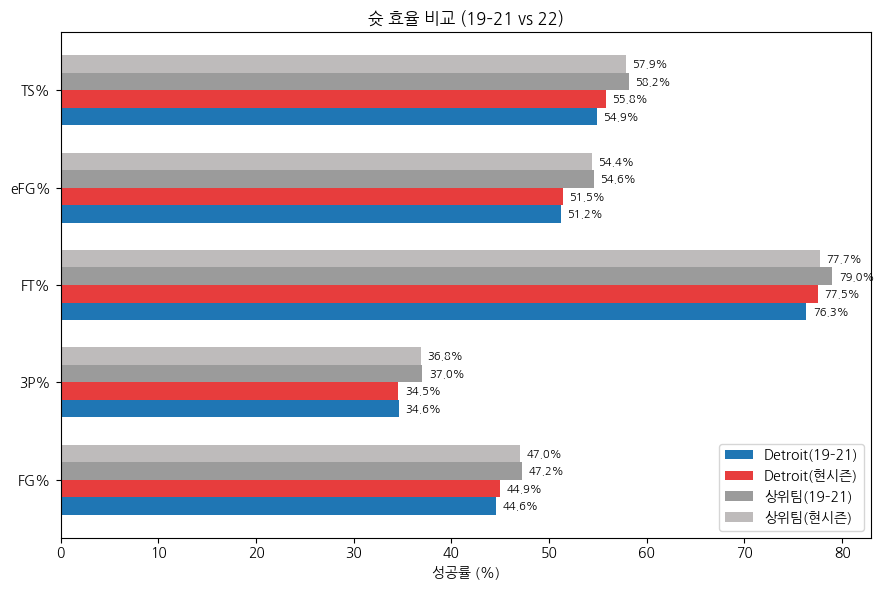

In [26]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 네 가지 값 준비
det_early   = [rate_det_early[m]    for m in metrics]   # 디트로이트 19~21
det_recent  = [rate_det_recent[m]   for m in metrics]   # 디트로이트 22
upper_early = [rate_upper_early[m]  for m in metrics]   # 상위팀 19~21
upper_recent= [rate_upper_recent[m] for m in metrics]   # 상위팀 22

y = np.arange(len(metrics))   # 지표 갯수
h = 0.18                      # 막대 두께

fig, ax = plt.subplots(figsize=(9,6))

# 네 가지 막대
bars1 = ax.barh(y - h*1.5, det_early,   h, label="Detroit(19–21)", color="#1f76b4ff")
bars2 = ax.barh(y - h/2,  det_recent,  h, label="Detroit(현시즌)",     color="#e73d3dff")
bars3 = ax.barh(y + h/2,  upper_early, h, label="상위팀(19–21)",  color="#7f7f7fc6")
bars4 = ax.barh(y + h*1.5,upper_recent,h, label="상위팀(현시즌)",     color="#bebbbb")

# 라벨/제목
ax.set_xlabel("성공률 (%)")
ax.set_title("슛 효율 비교 (19–21 vs 22)")
ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.legend(loc="lower right")

# 값 표시 함수
def add_labels(bars):
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%",
                    xy=(w, bar.get_y()+bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", fontsize=8)

for b in [bars1,bars2,bars3,bars4]:
    add_labels(b)

plt.tight_layout()
plt.show()


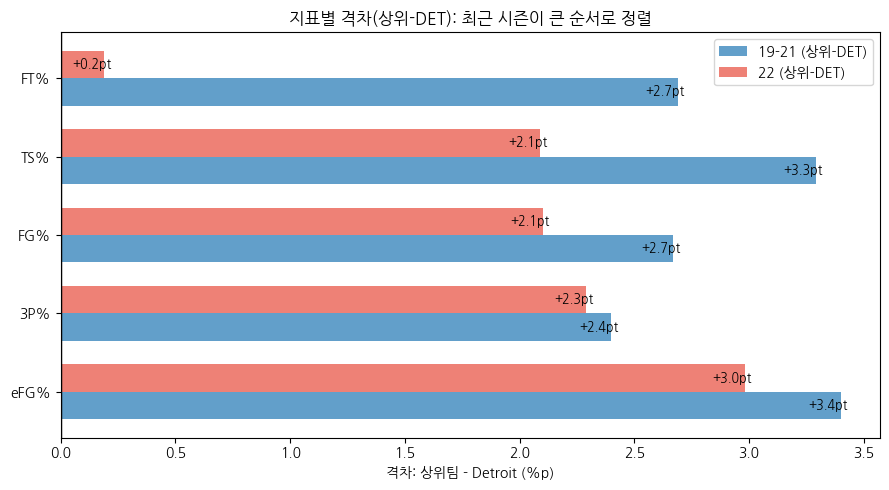

In [27]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 차이 계산
diff_early  = {m: (rate_upper_early[m]  - rate_det_early[m])  for m in metrics}
diff_recent = {m: (rate_upper_recent[m] - rate_det_recent[m]) for m in metrics}

# 최근 시즌 격차 큰 순서로 정렬
sorted_metrics = sorted(metrics, key=lambda m: diff_recent[m], reverse=True)
diff_e = [diff_early[m]  for m in sorted_metrics]
diff_r = [diff_recent[m] for m in sorted_metrics]

y = np.arange(len(sorted_metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(9,5))

# ───────────────────────────────
# 색상 명확히 구분
# ───────────────────────────────
b1 = ax.barh(y - h/2, diff_e, h, color="#1f77b4", alpha=0.7, label="19-21 (상위-DET)")
b2 = ax.barh(y + h/2, diff_r, h, color="#e74c3c", alpha=0.7, label="22 (상위-DET)")

ax.axvline(0, color="black", lw=1)
ax.set_yticks(y); ax.set_yticklabels(sorted_metrics)
ax.set_xlabel("격차: 상위팀 - Detroit (%p)")
ax.set_title("지표별 격차(상위-DET): 최근 시즌이 큰 순서로 정렬")
ax.legend(loc="upper right")
# xmax = max(max(diff_e), max(diff_r))
# ax.set_xlim(0, xmax*1.3)

# 값 라벨
for bars in [b1, b2]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:+.1f}pt",
                    (w, bar.get_y() + bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", ha="right", fontsize=9)

plt.tight_layout()
plt.show()


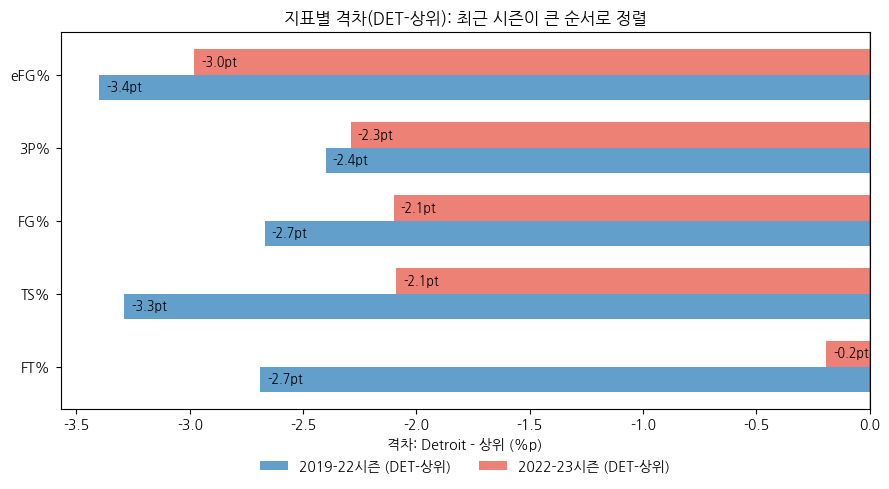

In [28]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

cond_early  = df["SEASON"].isin([2019, 2020, 2021])  # 19–21
cond_recent = (df["SEASON"] == 2022)                 # 22

# 차이 계산
diff_early  = {m: (rate_det_early[m]  - rate_upper_early[m])  for m in metrics}
diff_recent = {m: (rate_det_recent[m] - rate_upper_recent[m]) for m in metrics}

# 최근 시즌 격차 큰 순서로 정렬
sorted_metrics = sorted(metrics, key=lambda m: diff_recent[m], reverse=True)
diff_e = [diff_early[m]  for m in sorted_metrics]
diff_r = [diff_recent[m] for m in sorted_metrics]

y = np.arange(len(sorted_metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(9,5))

# ───────────────────────────────
# 색상 명확히 구분
# ───────────────────────────────
b1 = ax.barh(y - h/2, diff_e, h, color="#1f77b4", alpha=0.7, label="2019-22시즌 (DET-상위)")
b2 = ax.barh(y + h/2, diff_r, h, color="#e74c3c", alpha=0.7, label="2022-23시즌 (DET-상위)")

ax.axvline(0, color="black", lw=1)
ax.set_yticks(y); ax.set_yticklabels(sorted_metrics)
ax.set_xlabel("격차: Detroit - 상위 (%p)")
ax.set_title("지표별 격차(DET-상위): 최근 시즌이 큰 순서로 정렬")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1),
          ncol=2, frameon=False)

# 값 라벨
for bars in [b1, b2]:
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:+.1f}pt",
                    (w, bar.get_y() + bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [29]:
details = load_dataset("games_details_regular", 2022)
print(details.columns.tolist())  # 컬럼 실제 확인


['DATE', 'GAME_ID', 'SEASON', 'TEAM', 'TEAM_LVL', 'PLAYER_ID', 'START_POSITION', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS']


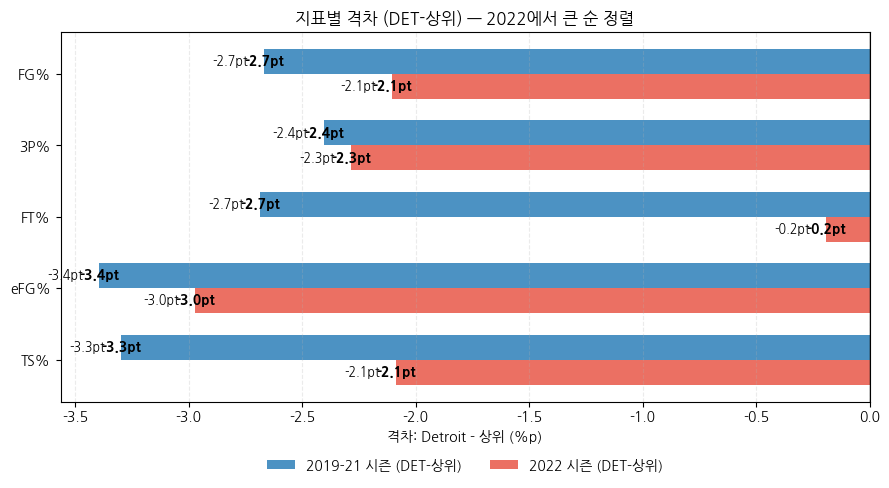

In [30]:
# ── 0) 준비: details를 표준 컬럼으로 정리 ───────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 이미 로드된 details(DataFrame) 사용
# details.columns:
# ['GAME_ID','SEASON','TEAM','TEAM_LVL','PLAYER_ID','START_POSITION','MIN',
#  'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT',
#  'OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']

use_cols = ["TEAM","TEAM_LVL","SEASON","FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]
d = details.loc[:, use_cols].copy()

# 숫자형 안전 변환
for c in ["FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

# ── 1) 합산 → 효율 함수 ─────────────────────────────────────
def _safe_div(a,b): 
    return np.nan if (b is None or pd.isna(b) or b==0) else a/b

def sum_box(x: pd.DataFrame):
    return {
        "FGM": x["FGM"].sum(), "FGA": x["FGA"].sum(),
        "FG3M": x["FG3M"].sum(), "FG3A": x["FG3A"].sum(),
        "FTM": x["FTM"].sum(), "FTA": x["FTA"].sum(),
        "PTS": x["PTS"].sum(),
    }

def calc_rates(s):
    FGM,FGA,FG3M,FG3A,FTM,FTA,PTS = s["FGM"],s["FGA"],s["FG3M"],s["FG3A"],s["FTM"],s["FTA"],s["PTS"]
    FG  = _safe_div(FGM, FGA)
    TP  = _safe_div(FG3M, FG3A)
    FT  = _safe_div(FTM, FTA)
    eFG = _safe_div(FGM + 0.5*FG3M, FGA)
    TS  = _safe_div(PTS, 2*(FGA + 0.44*FTA))
    to_pct = lambda x: None if pd.isna(x) else x*100
    return {"FG%":to_pct(FG), "3P%":to_pct(TP), "FT%":to_pct(FT), "eFG%":to_pct(eFG), "TS%":to_pct(TS)}

# ── 2) 시즌 조건(2019–21 vs 2022) ──────────────────────────
cond_early  = d["SEASON"].isin([2019, 2020, 2021])  # 19–21
cond_recent = (d["SEASON"] == 2022)                  # 22

# ── 3) 상위팀 vs 디트로이트 효율(합산) 계산 ────────────────
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

rate_upper_early  = calc_rates(sum_box(d[(d["TEAM_LVL"]=="상위팀") & cond_early]))
rate_det_early    = calc_rates(sum_box(d[(d["TEAM"]=="Detroit")   & cond_early]))
rate_upper_recent = calc_rates(sum_box(d[(d["TEAM_LVL"]=="상위팀") & cond_recent]))
rate_det_recent   = calc_rates(sum_box(d[(d["TEAM"]=="Detroit")   & cond_recent]))

# ── 4) 격차(DET − 상위) 계산 ───────────────────────────────
diff_early  = {m: (rate_det_early[m]  - rate_upper_early[m])  for m in metrics}
diff_recent = {m: (rate_det_recent[m] - rate_upper_recent[m]) for m in metrics}

# 발표용: 
sorted_metrics = metrics
diff_e = [diff_early[m]  for m in sorted_metrics]
diff_r = [diff_recent[m] for m in sorted_metrics]

# ── 5) 시각화(라벨은 막대 바깥) ────────────────────────────
y = np.arange(len(sorted_metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(9,5))

b1 = ax.barh(y - h/2, diff_e, h, color="#1f77b4", alpha=0.8, label="2019-21 시즌 (DET-상위)")
b2 = ax.barh(y + h/2, diff_r, h, color="#e74c3c", alpha=0.8, label="2022 시즌 (DET-상위)")

ax.axvline(0, color="black", lw=1)
ax.grid(axis="x", linestyle="--", alpha=0.25)
ax.set_yticks(y); ax.set_yticklabels(sorted_metrics)
ax.set_xlabel("격차: Detroit - 상위 (%p)")
ax.set_title("지표별 격차 (DET-상위) — 2022에서 큰 순 정렬")
ax.set_yticks(y); 
ax.set_yticklabels(order)
ax.invert_yaxis()  # ← 위에서 아래로 FG% → … → TS%가 나오도록 반전

# 값 라벨 (막대 안쪽)
for bars in [b1, b2]:
    for bar in bars:
        w = bar.get_width()
        yc = bar.get_y() + bar.get_height()/2
        if np.isnan(w): 
            continue
        ax.annotate(f"{w:+.1f}pt",
                    (w, yc), xytext=(0,0),
                    textcoords="offset points",
                    ha="center", va="center",
                    fontsize=10, fontweight="bold", color="black")

# 막대 바깥에 값 라벨
def annotate_outside(bars):
    xmin, xmax = ax.get_xlim(); pad = 0.02*(xmax-xmin)
    for bar in bars:
        w = bar.get_width(); yc = bar.get_y()+bar.get_height()/2
        if pd.isna(w): continue
        if w >= 0: ax.annotate(f"{w:+.1f}pt", (w+pad, yc), ha="left",  va="center", fontsize=9)
        else:      ax.annotate(f"{w:+.1f}pt", (w-pad, yc), ha="right", va="center", fontsize=9)

annotate_outside(b1)
annotate_outside(b2)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
plt.tight_layout(); plt.show()


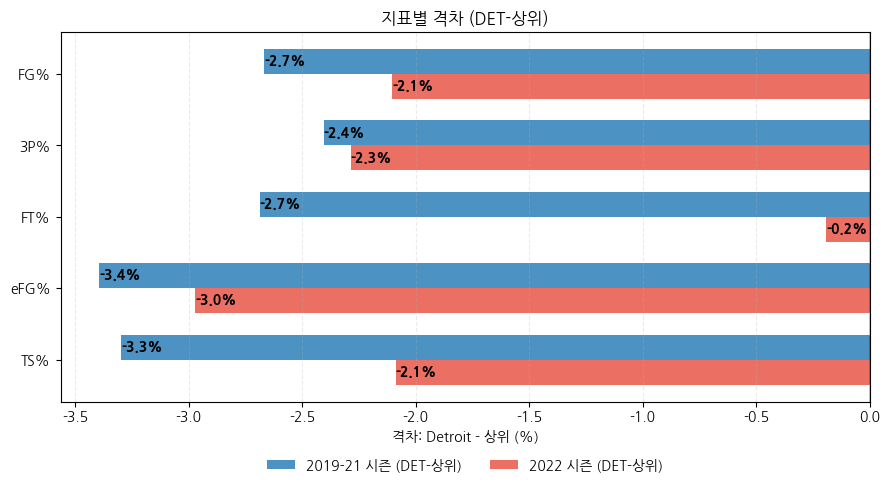

In [31]:
# ── 0) 지표 / 격차 계산은 기존 그대로 ─────────────────────
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

diff_early  = {m: (rate_det_early[m]  - rate_upper_early[m])  for m in metrics}
diff_recent = {m: (rate_det_recent[m] - rate_upper_recent[m]) for m in metrics}

# 기본 순서로 그대로 사용
sorted_metrics = metrics
diff_e = [diff_early[m]  for m in sorted_metrics]
diff_r = [diff_recent[m] for m in sorted_metrics]

# ── 1) 시각화 ───────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

y = np.arange(len(sorted_metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(9,5))

b1 = ax.barh(y - h/2, diff_e, h, color="#1f77b4", alpha=0.8, label="2019-21 시즌 (DET-상위)")
b2 = ax.barh(y + h/2, diff_r, h, color="#e74c3c", alpha=0.8, label="2022 시즌 (DET-상위)")

ax.axvline(0, color="black", lw=1)
ax.grid(axis="x", linestyle="--", alpha=0.25)

ax.set_yticks(y)
ax.set_yticklabels(sorted_metrics)
ax.invert_yaxis()  # 위→아래: FG% → 3P% → FT% → eFG% → TS%

ax.set_xlabel("격차: Detroit - 상위 (%)")
ax.set_title("지표별 격차 (DET-상위)")

# 값 라벨(막대 안쪽, 굵게)
for bars in (b1, b2):
    for bar in bars:
        w  = bar.get_width()
        if np.isnan(w): 
            continue
        yc = bar.get_y() + bar.get_height()/2
        ax.annotate(f"{w:+.1f}%",
                    (w, yc), xytext=(0,0), textcoords="offset points",
                    ha="left", va="center",
                    fontsize=10, fontweight="bold", color="black")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12),
          ncol=2, frameon=False)

plt.tight_layout()
plt.show()


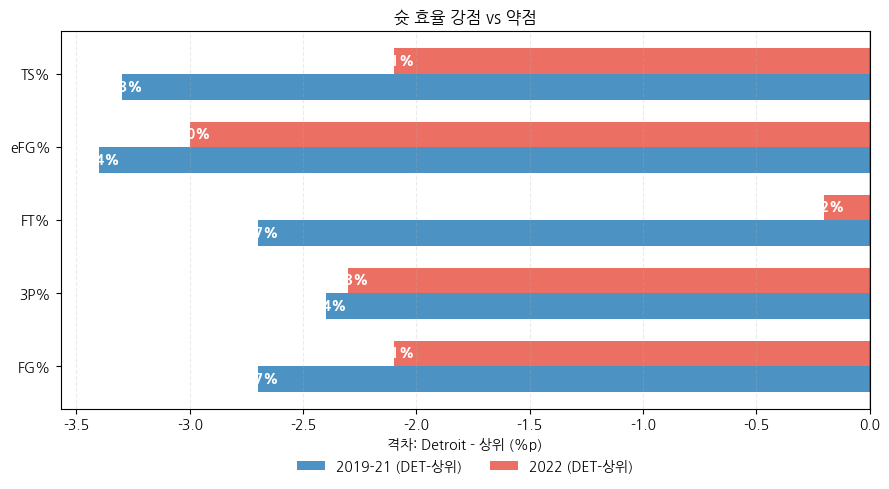

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 지표
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 이전 계산된 값들 예시 (DET - 상위)
diff_19_21 = {"FG%":-2.7, "3P%":-2.4, "FT%":-2.7, "eFG%":-3.4, "TS%":-3.3}
diff_22    = {"FG%":-2.1, "3P%":-2.3, "FT%":-0.2, "eFG%":-3.0, "TS%":-2.1}

vals_19_21 = [diff_19_21[m] for m in metrics]
vals_22    = [diff_22[m]    for m in metrics]

y = np.arange(len(metrics)); h = 0.35
fig, ax = plt.subplots(figsize=(9,5))

# 막대
b1 = ax.barh(y - h/2, vals_19_21, h, color="#1f77b4", alpha=0.8, label="2019-21 (DET-상위)")
b2 = ax.barh(y + h/2, vals_22,    h, color="#e74c3c", alpha=0.8, label="2022 (DET-상위)")

# 기준선
ax.axvline(0, color="black", lw=1)
ax.grid(axis="x", linestyle="--", alpha=0.25)

ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.set_xlabel("격차: Detroit - 상위 (%p)")
ax.set_title("슛 효율 강점 vs 약점")

# 라벨 (막대 안에 굵게)
for bars in [b1,b2]:
    for bar in bars:
        w = bar.get_width()
        yc = bar.get_y() + bar.get_height()/2
        ax.annotate(f"{w:.1f}%",
                    (w, yc), ha="center", va="center",
                    fontsize=10, fontweight="bold", color="white")

ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


/tmp/ipykernel_194227/257683904.py:46: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/yeeun/anaconda3/envs/sparta/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


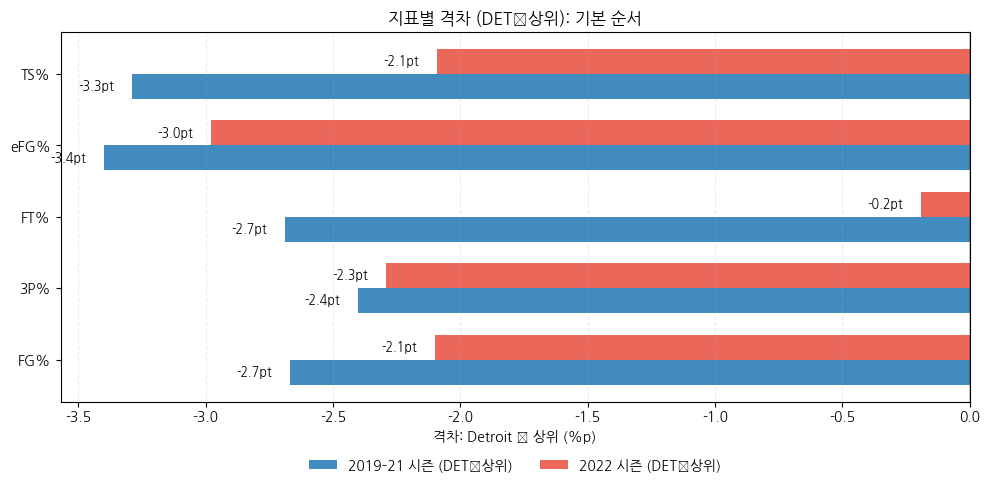

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 지표와 격차(DET − 상위) 계산
metrics = ["FG%","3P%","FT%","eFG%","TS%"]

diff_19_21 = {m: (rate_det_19_21[m] - rate_upper_19_21[m]) for m in metrics}
diff_22     = {m: (rate_det_22[m]   - rate_upper_22[m])    for m in metrics}

# 그냥 정해둔 순서대로
order = metrics

vals_19_21 = [diff_19_21[m] for m in order]
vals_22    = [diff_22[m]    for m in order]

# 2) 시각화
y = np.arange(len(order)); h = 0.35
fig, ax = plt.subplots(figsize=(10,5))

b1 = ax.barh(y - h/2, vals_19_21, h, color="#1f77b4", alpha=0.85, label="2019–21 시즌 (DET−상위)")
b2 = ax.barh(y + h/2, vals_22,    h, color="#e74c3c", alpha=0.85, label="2022 시즌 (DET−상위)")

# 기준선/격자/축
ax.axvline(0, color="black", lw=1)
ax.grid(axis="x", linestyle="--", alpha=0.25)
ax.set_yticks(y); ax.set_yticklabels(order)
ax.set_xlabel("격차: Detroit − 상위 (%p)")
ax.set_title("지표별 격차 (DET−상위): 기본 순서")

# 막대 바깥에 값 라벨
def annotate_outside(bars):
    xmin, xmax = ax.get_xlim(); pad = 0.02*(xmax-xmin or 1)
    for bar in bars:
        w  = bar.get_width()
        yc = bar.get_y() + bar.get_height()/2
        if np.isnan(w): continue
        if w >= 0:
            ax.annotate(f"{w:+.1f}pt", (w+pad, yc), ha="right", va="center", fontsize=9)
        else:
            ax.annotate(f"{w:+.1f}pt", (w-pad, yc), ha="right", va="center", fontsize=9)

annotate_outside(b1)
annotate_outside(b2)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


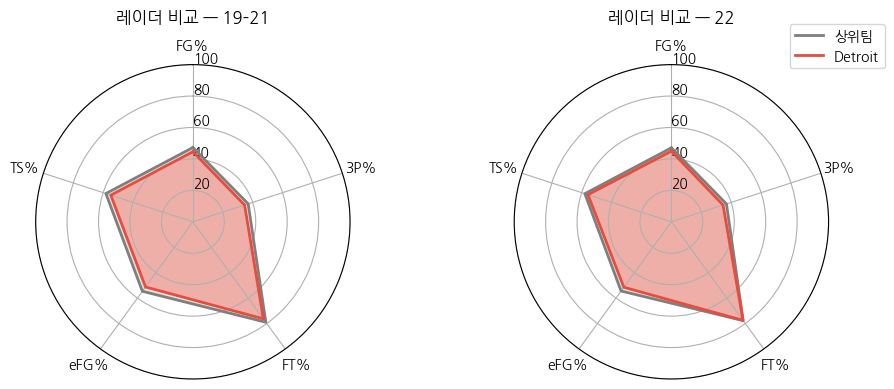

In [34]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["FG%","3P%","FT%","eFG%","TS%"]
N = len(metrics)

# 각도 설정(마지막에 처음 점으로 닫기)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

def radar_vals(d):
    vals = [d[m] for m in metrics]
    vals += vals[:1]
    return vals

det_early   = radar_vals(rate_det_early)
top_early   = radar_vals(rate_upper_early)
det_recent  = radar_vals(rate_det_recent)
top_recent  = radar_vals(rate_upper_recent)

# 축 레이블도 닫기
metrics_closed = metrics + [metrics[0]]

# 두 개의 레이더(19–21, 22)를 나란히
fig = plt.figure(figsize=(10,4))

for i, (title, det, top) in enumerate([
    ("19–21", det_early,  top_early),
    ("22",    det_recent, top_recent)
]):
    ax = plt.subplot(1, 2, i+1, polar=True)
    ax.set_theta_offset(np.pi/2)   # 위에서 시작
    ax.set_theta_direction(-1)     # 시계 방향

    # 눈금 범위(보기 좋게 0~100)
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 100)

    # 축/라벨
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=10)

    # 상위팀(회색), Detroit(빨강)
    ax.plot(angles, top, color="#7f7f7f", linewidth=2, label="상위팀")
    ax.fill(angles, top, color="#c7c7c780")
    ax.plot(angles, det, color="#e74c3c", linewidth=2, label="Detroit")
    ax.fill(angles, det, color="#ff6f6170")

    ax.set_title(f"레이더 비교 — {title}", pad=12)
    if i==1:  # 오른쪽 플롯에만 범례
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.15))

plt.tight_layout()
plt.show()

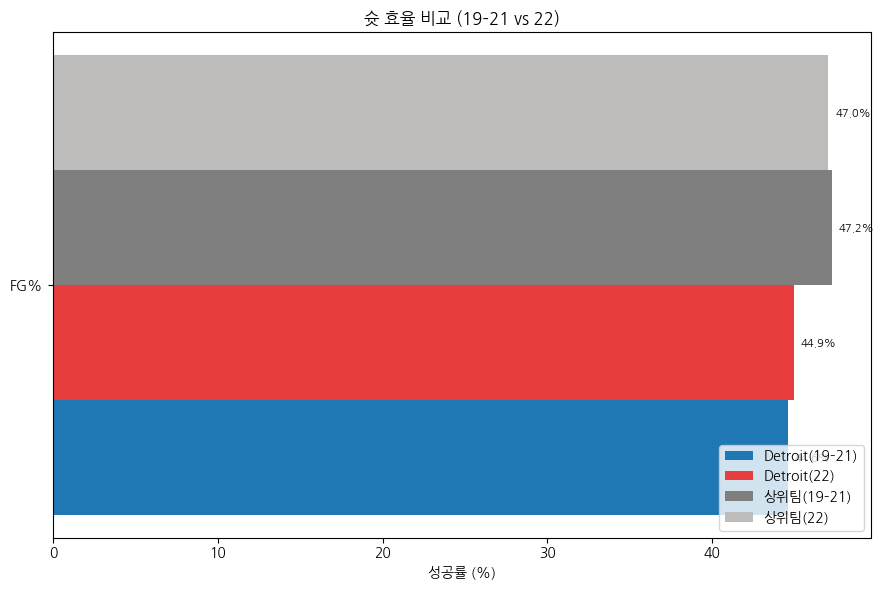

In [35]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["FG%"]

# 네 가지 값 준비
det_early   = [rate_det_early[m]    for m in metrics]   # 디트로이트 19~21
det_recent  = [rate_det_recent[m]   for m in metrics]   # 디트로이트 22
upper_early = [rate_upper_early[m]  for m in metrics]   # 상위팀 19~21
upper_recent= [rate_upper_recent[m] for m in metrics]   # 상위팀 22

y = np.arange(len(metrics))   # 지표 갯수
h = 0.18                      # 막대 두께

fig, ax = plt.subplots(figsize=(9,6))

# 네 가지 막대
bars1 = ax.barh(y - h*1.5, det_early,   h, label="Detroit(19–21)", color="#1f77b4")
bars2 = ax.barh(y - h/2,  det_recent,  h, label="Detroit(22)",     color="#e73d3d")
bars3 = ax.barh(y + h/2,  upper_early, h, label="상위팀(19–21)",  color="#7f7f7f")
bars4 = ax.barh(y + h*1.5,upper_recent,h, label="상위팀(22)",     color="#bebbbb")

# 라벨/제목
ax.set_xlabel("성공률 (%)")
ax.set_title("슛 효율 비교 (19–21 vs 22)")
ax.set_yticks(y)
ax.set_yticklabels(metrics)
ax.legend(loc="lower right")

# 값 표시 함수
def add_labels(bars):
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%",
                    xy=(w, bar.get_y()+bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", fontsize=8)

for b in [bars1,bars2,bars3,bars4]:
    add_labels(b)

plt.tight_layout()
plt.show()


/tmp/ipykernel_194227/2694274303.py:57: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout(); plt.show()
/home/yeeun/anaconda3/envs/sparta/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


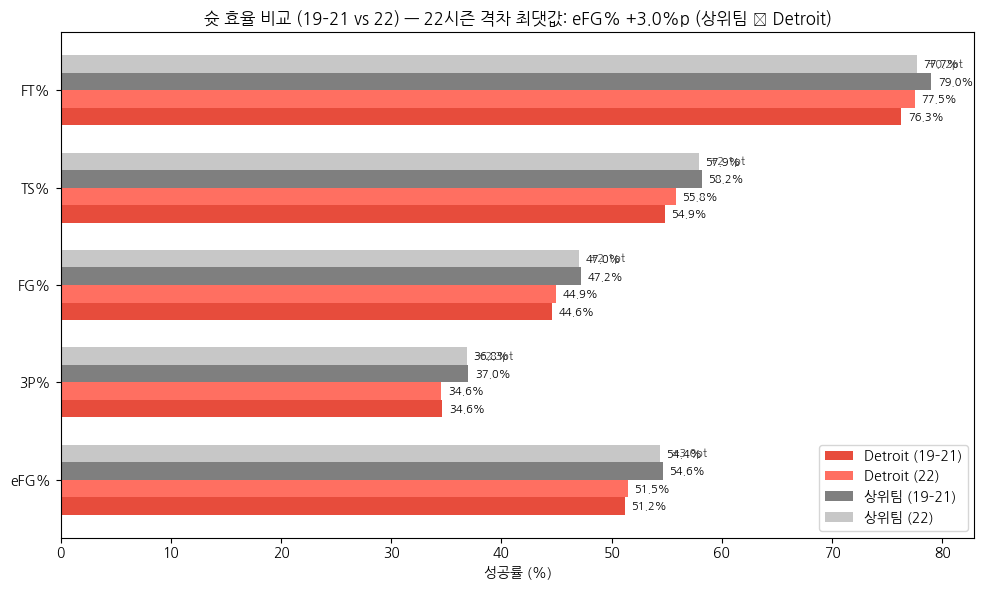

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 격차(상위팀-Detroit)를 22시즌 기준으로 계산 후, 큰 순서 정렬
metrics = ["FG%","3P%","FT%","eFG%","TS%"]
gap_recent = {m: (rate_upper_recent[m] - rate_det_recent[m]) for m in metrics}
sorted_metrics = sorted(metrics, key=lambda m: gap_recent[m], reverse=True)  # 큰 격차 → 위

# 2) 정렬된 값 벡터 생성
det_early_vals    = [rate_det_early[m]    for m in sorted_metrics]
det_recent_vals   = [rate_det_recent[m]   for m in sorted_metrics]
upper_early_vals  = [rate_upper_early[m]  for m in sorted_metrics]
upper_recent_vals = [rate_upper_recent[m] for m in sorted_metrics]
gaps_sorted       = [gap_recent[m]        for m in sorted_metrics]  # 주석용

# 3) 색상 팔레트(디트 빨강 고정, 상위팀 회색)
colors = {
    "det_early":  "#e74c3c",
    "det_recent": "#ff6f61",
    "top_early":  "#7f7f7f",
    "top_recent": "#c7c7c7",
}

# 4) 그래프
y = np.arange(len(sorted_metrics)); h = 0.18
fig, ax = plt.subplots(figsize=(10,6))

b1 = ax.barh(y - 1.5*h, det_early_vals,   h, label="Detroit (19–21)", color=colors["det_early"])
b2 = ax.barh(y - 0.5*h, det_recent_vals,  h, label="Detroit (22)",    color=colors["det_recent"])
b3 = ax.barh(y + 0.5*h, upper_early_vals, h, label="상위팀 (19–21)",  color=colors["top_early"])
b4 = ax.barh(y + 1.5*h, upper_recent_vals,h, label="상위팀 (22)",     color=colors["top_recent"])

# 인사이트 메시지(제목): 격차가 큰 지표명을 자동으로 뽑아 강조
top_gap_metric = sorted_metrics[0]
ax.set_title(f"슛 효율 비교 (19–21 vs 22) — 22시즌 격차 최댓값: {top_gap_metric} "
             f"{gap_recent[top_gap_metric]:+.1f}%p (상위팀 − Detroit)")
ax.set_xlabel("성공률 (%)")
ax.set_yticks(y); ax.set_yticklabels(sorted_metrics)
ax.legend(loc="lower right")

# 값 라벨
def add_labels(bars):
    for bar in bars:
        w = bar.get_width()
        ax.annotate(f"{w:.1f}%",
                    (w, bar.get_y()+bar.get_height()/2),
                    xytext=(5,0), textcoords="offset points",
                    va="center", fontsize=8)
for bars in [b1,b2,b3,b4]:
    add_labels(bars)

# 각 지표 오른쪽에 격차(22시즌)도 같이 표기
for yi, g in zip(y, gaps_sorted):
    ax.annotate(f" {g:+.1f}pt", xy=(max(upper_recent_vals[yi], det_recent_vals[yi]), yi+1.5*h),
                xytext=(6,0), textcoords="offset points", va="center", fontsize=8, color="#444")

plt.tight_layout(); plt.show()


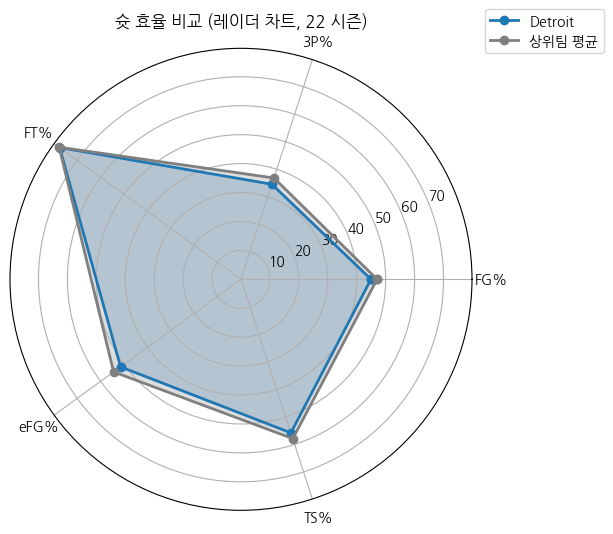

In [37]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 값 뽑기 (최근 시즌 기준)
det_values   = [rate_det_recent[m]   for m in metrics]
upper_values = [rate_upper_recent[m] for m in metrics]

# 레이더 차트는 원형이므로 첫 값 다시 추가
det_values   += [det_values[0]]
upper_values += [upper_values[0]]
metrics_loop  = metrics + [metrics[0]]

angles = np.linspace(0, 2*np.pi, len(metrics_loop), endpoint=True)

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

ax.plot(angles, det_values, 'o-', linewidth=2, label="Detroit", color="#1f77b4")
ax.fill(angles, det_values, alpha=0.25, color="#1f77b4")

ax.plot(angles, upper_values, 'o-', linewidth=2, label="상위팀 평균", color="#7f7f7f")
ax.fill(angles, upper_values, alpha=0.25, color="#7f7f7f")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title("슛 효율 비교 (레이더 차트, 22 시즌)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()


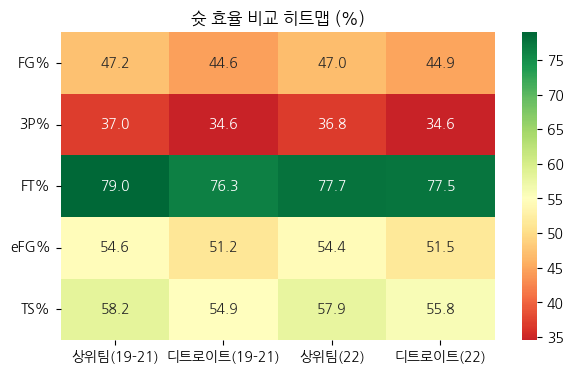

In [38]:
import seaborn as sns
import pandas as pd

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

# 데이터프레임 만들기
heatmap_df = pd.DataFrame({
    "상위팀(19-21)": [rate_upper_early[m] for m in metrics],
    "디트로이트(19-21)": [rate_det_early[m] for m in metrics],
    "상위팀(22)": [rate_upper_recent[m] for m in metrics],
    "디트로이트(22)": [rate_det_recent[m] for m in metrics],
}, index=metrics)

plt.figure(figsize=(7,4))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="RdYlGn", center=55)
plt.title("슛 효율 비교 히트맵 (%)")
plt.yticks(rotation=0)
plt.show()


In [39]:
# ─────────────────────────────────────────────────────────────
# 0) 라이브러리 & 데이터 로드
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# games_regular 불러오기 (예: /data/nba_dataset/games_regular.csv)
g = load_dataset("games_regular", 2022)
print("columns:", list(g.columns)[:20])  # 확인용

# ─────────────────────────────────────────────────────────────
# 1) 컬럼 이름 세팅 (환경마다 다를 수 있어요)
#    - 아래 이름이 다르면, 오른쪽 문자열만 네 컬럼명으로 바꿔주세요.
# ─────────────────────────────────────────────────────────────
COL = {
    "GAME_ID":        "GAME_ID",
    "SEASON":         "SEASON",            # 없으면 생략 가능(전체 합산만 볼 때)
    "HOME_TEAM":      "HOME_TEAM",
    "VISITOR_TEAM":   "VISITOR_TEAM",
    "PTS_HOME":       "PTS_home",
    "PTS_AWAY":       "PTS_away",
    "HOME_TEAM_WINS": "HOME_TEAM_WINS",   # 1/0
}

# ─────────────────────────────────────────────────────────────
# 2) 홈/원정 → 롱(long) 형태로 펼치기 (팀별 한 줄)
#    - 한 경기 → 홈팀 1행, 원정팀 1행 (총 2행)
# ─────────────────────────────────────────────────────────────
home = g[[COL["GAME_ID"], COL.get("SEASON", None), COL["HOME_TEAM"], COL["VISITOR_TEAM"], COL["PTS_HOME"], COL["PTS_AWAY"], COL["HOME_TEAM_WINS"]]].copy()
home.columns = ["GAME_ID","SEASON","TEAM","OPP_TEAM","PTS","OPP_PTS","HOME_TEAM_WINS"]
home["IS_HOME"] = 1
home["WIN"] = home["HOME_TEAM_WINS"]  # 홈이면 그대로

away = g[[COL["GAME_ID"], COL.get("SEASON", None), COL["VISITOR_TEAM"], COL["HOME_TEAM"], COL["PTS_AWAY"], COL["PTS_HOME"], COL["HOME_TEAM_WINS"]]].copy()
away.columns = ["GAME_ID","SEASON","TEAM","OPP_TEAM","PTS","OPP_PTS","HOME_TEAM_WINS"]
away["IS_HOME"] = 0
away["WIN"] = 1 - away["HOME_TEAM_WINS"]  # 원정은 반대로

df = pd.concat([home, away], ignore_index=True)

# 숫자 변환(안전)
for c in ["PTS","OPP_PTS","WIN"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ─────────────────────────────────────────────────────────────
# 3) 점수차 & 클러치 플래그 만들기
#    - 클러치 기준: 최종 점수차 5점 이하 (abs ≤ 5)
# ─────────────────────────────────────────────────────────────
df["MARGIN"] = df["PTS"] - df["OPP_PTS"]
df["IS_CLUTCH"] = (df["MARGIN"].abs() <= 5).astype(int)

# ─────────────────────────────────────────────────────────────
# 4) 승률 계산 함수
# ─────────────────────────────────────────────────────────────
def win_rate(x):
    # x는 팀의 경기 부분집합(DataFrame)
    games = len(x)
    wins  = x["WIN"].sum()
    return np.nan if games == 0 else round(100 * wins / games, 1)

def team_summary(x):
    all_wr     = win_rate(x)
    clutch_wr  = win_rate(x[x["IS_CLUTCH"] == 1])
    clutch_cnt = int((x["IS_CLUTCH"] == 1).sum())
    total_cnt  = int(len(x))
    gap        = None if (np.isnan(all_wr) or np.isnan(clutch_wr)) else round(clutch_wr - all_wr, 1)
    return pd.Series({
        "전체경기수": total_cnt,
        "클러치경기수": clutch_cnt,
        "전체승률(%)": all_wr,
        "클러치승률(%)": clutch_wr,
        "격차(클러치-전체, %p)": gap
    })

# ─────────────────────────────────────────────────────────────
# 5) 팀별 요약표
#    - 시즌별로도 보고 싶으면 groupby(["TEAM","SEASON"]) 으로 바꿔주세요.
# ─────────────────────────────────────────────────────────────
team_table = df.groupby("TEAM").apply(team_summary).reset_index()
team_table = team_table.sort_values(by="격차(클러치-전체, %p)", ascending=True)  # 클러치에 약한 팀이 위로
print(team_table.head(10))  # 상위 10개 확인

# ─────────────────────────────────────────────────────────────
# 6) 디트로이트만 보고 싶을 때
# ─────────────────────────────────────────────────────────────
DET_NAME = "Detroit"  # 데이터에 따라 "Detroit Pistons"일 수도 있음
det = df[df["TEAM"] == DET_NAME]
det_row = team_summary(det)
print(f"\n[{DET_NAME}] 요약")
print(det_row)

# (선택) 시즌별 디트로이트 추이
if "SEASON" in df.columns:
    det_season = det.groupby("SEASON").apply(team_summary)
    print("\n디트로이트 시즌별")
    print(det_season)


columns: ['DATE', 'GAME_ID', 'SEASON', 'HOME_TEAM', 'HOME_TEAM_LVL', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'VISITOR_TEAM', 'VISITOR_TEAM_LVL', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'HOME_TEAM_WINS']
            TEAM  전체경기수  클러치경기수  전체승률(%)  클러치승률(%)  격차(클러치-전체, %p)
1         Boston  305.0    86.0     60.0      41.9           -18.1
16     Milwaukee  303.0    57.0     67.0      56.1           -10.9
22  Philadelphia  285.0    72.0     61.1      51.4            -9.7
9   Golden State  276.0    66.0     50.0      42.4            -7.6
27       Toronto  275.0    86.0     54.9      47.7            -7.2
28          Utah  285.0    66.0     61.4      54.5            -6.9
23       Phoenix  294.0    80.0     64.3      57.5            -6.8
11       Indiana  264.0    74.0     45.5      39.2            -6.3
6         Dallas  292.0    80.0     57.2      51.2            -6.0
18   New Orleans  265.0    73.0     45.3   

/tmp/ipykernel_194227/327963181.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_table = df.groupby("TEAM").apply(team_summary).reset_index()
/tmp/ipykernel_194227/327963181.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_table = df.groupby("TEAM").apply(team_summary).reset_index()
/tmp/ipykernel_194227/327963181.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from

In [40]:
print(team_table.sort_values("전체승률(%)", ascending=False).head(7))


             TEAM  전체경기수  클러치경기수  전체승률(%)  클러치승률(%)  격차(클러치-전체, %p)
16      Milwaukee  303.0    57.0     67.0      56.1           -10.9
23        Phoenix  294.0    80.0     64.3      57.5            -6.8
28           Utah  285.0    66.0     61.4      54.5            -6.9
22   Philadelphia  285.0    72.0     61.1      51.4            -9.7
1          Boston  305.0    86.0     60.0      41.9           -18.1
7          Denver  291.0    79.0     59.8      60.8             1.0
12  L.A. Clippers  293.0    74.0     59.4      55.4            -4.0


In [41]:
# ─────────────────────────────────────────────────────────────
# 0) 다시 로드
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
games   = load_dataset("games_regular" , 2022)
details = load_dataset("games_details_regular", 2022)

# 편의: 자동 컬럼 선택
def pick_col(df, cands, must=True, tag=""):
    for c in cands:
        if c in df.columns: return c
    if must: raise KeyError(f"[{tag}] 후보 {cands} 중 없음. 보유: {list(df.columns)[:40]}")
    return None

G_GAME_ID   = pick_col(games,   ["GAME_ID","GAMEID","GAME KEY","GAMEKEY"], True,  "games.GAME_ID")
G_SEASON    = pick_col(games,   ["SEASON","SEASON_YEAR","SEASON_ID","YEAR"], False,"games.SEASON")
G_HOME_TEAM = pick_col(games,   ["HOME_TEAM","HOME_TEAM_NAME","HOME"],      True,  "games.HOME_TEAM")
G_AWAY_TEAM = pick_col(games,   ["VISITOR_TEAM","AWAY_TEAM","VISITOR","AWAY"],True,"games.VISITOR_TEAM")
G_PTS_HOME  = pick_col(games,   ["PTS_home","PTS_HOME","HOME_PTS"],         True,  "games.PTS_HOME")
G_PTS_AWAY  = pick_col(games,   ["PTS_away","PTS_AWAY","AWAY_PTS"],         True,  "games.PTS_AWAY")
G_HOME_WIN  = pick_col(games,   ["HOME_TEAM_WINS","HOME_WIN","HOME_W"],     True,  "games.HOME_TEAM_WINS")

D_TEAM      = pick_col(details, ["TEAM","TEAM_NAME","TEAM_ABBREVIATION"],   True,  "details.TEAM")
D_TEAM_LVL  = pick_col(details, ["TEAM_LVL","TEAM_LEVEL","TEAM_TIER"],      True,  "details.TEAM_LVL")
D_SEASON    = pick_col(details, ["SEASON","SEASON_YEAR","SEASON_ID","YEAR"], False, "details.SEASON")

# ─────────────────────────────────────────────────────────────
# 1) games → 롱 변환 (TEAM 반드시 포함)
# ─────────────────────────────────────────────────────────────
home = games[[G_GAME_ID, G_SEASON, G_HOME_TEAM, G_AWAY_TEAM, G_PTS_HOME, G_PTS_AWAY, G_HOME_WIN]].copy()
home.columns = ["GAME_ID","SEASON","TEAM","OPP_TEAM","PTS","OPP_PTS","HOME_TEAM_WINS"]
home["IS_HOME"] = 1
home["WIN"]     = home["HOME_TEAM_WINS"]

away = games[[G_GAME_ID, G_SEASON, G_AWAY_TEAM, G_HOME_TEAM, G_PTS_AWAY, G_PTS_HOME, G_HOME_WIN]].copy()
away.columns = ["GAME_ID","SEASON","TEAM","OPP_TEAM","PTS","OPP_PTS","HOME_TEAM_WINS"]
away["IS_HOME"] = 0
away["WIN"]     = 1 - away["HOME_TEAM_WINS"]

df = pd.concat([home, away], ignore_index=True)
for c in ["PTS","OPP_PTS","WIN"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ─────────────────────────────────────────────────────────────
# 2) TEAM_LVL 머지 (suffixes로 충돌 방지, 오른쪽만 정리)
# ─────────────────────────────────────────────────────────────
if ("SEASON" in df.columns) and (D_SEASON is not None):
    level_map = (
        details[[D_TEAM, D_TEAM_LVL, D_SEASON]]
        .dropna(subset=[D_TEAM, D_TEAM_LVL])
        .groupby([D_TEAM, D_SEASON])[D_TEAM_LVL]
        .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
        .reset_index()
    )
    df = df.merge(level_map, how="left",
                  left_on=["TEAM","SEASON"], right_on=[D_TEAM, D_SEASON],
                  suffixes=("", "_r"))
    # 오른쪽 키 컬럼만 제거
    for c in [D_TEAM+"_r", D_SEASON+"_r"]:
        if c in df.columns: df.drop(columns=[c], inplace=True)
else:
    level_map = (
        details[[D_TEAM, D_TEAM_LVL]]
        .dropna(subset=[D_TEAM, D_TEAM_LVL])
        .groupby(D_TEAM)[D_TEAM_LVL]
        .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
        .reset_index()
    )
    df = df.merge(level_map, how="left",
                  left_on="TEAM", right_on=D_TEAM,
                  suffixes=("", "_r"))
    if D_TEAM+"_r" in df.columns:
        df.drop(columns=[D_TEAM+"_r"], inplace=True)

# TEAM_LVL 이름 통일
if D_TEAM_LVL in df.columns:
    df.rename(columns={D_TEAM_LVL: "TEAM_LVL"}, inplace=True)

# ─────────────────────────────────────────────────────────────
# 3) 이후 분석(클러치 등) 계속 진행
# ─────────────────────────────────────────────────────────────
df["MARGIN"]    = df["PTS"] - df["OPP_PTS"]
df["IS_CLUTCH"] = (df["MARGIN"].abs() <= 5).astype(int)

def win_rate(x):
    games = len(x); wins = x["WIN"].sum()
    return np.nan if games == 0 else round(100*wins/games, 1)

def team_summary(x):
    all_wr     = win_rate(x)
    clutch_wr  = win_rate(x[x["IS_CLUTCH"]==1])
    clutch_cnt = int((x["IS_CLUTCH"]==1).sum())
    total_cnt  = int(len(x))
    gap        = None if (np.isnan(all_wr) or np.isnan(clutch_wr)) else round(clutch_wr - all_wr, 1)
    return pd.Series({
        "전체경기수": total_cnt,
        "클러치경기수": clutch_cnt,
        "전체승률(%)": all_wr,
        "클러치승률(%)": clutch_wr,
        "격차(클러치-전체, %p)": gap
    })

team_table = df.groupby("TEAM").apply(team_summary).reset_index()
lvl_table  = df.groupby(["TEAM_LVL","TEAM"]).apply(team_summary).reset_index()

print("\n[레벨별 요약 예시]")
display(lvl_table.sort_values(["TEAM_LVL","전체승률(%)"], ascending=[True,False]).head(7))


/tmp/ipykernel_194227/3997932181.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([D_TEAM, D_SEASON])[D_TEAM_LVL]
/tmp/ipykernel_194227/3997932181.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_table = df.groupby("TEAM").apply(team_summary).reset_index()



[레벨별 요약 예시]


/tmp/ipykernel_194227/3997932181.py:104: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_table = df.groupby("TEAM").apply(team_summary).reset_index()
/tmp/ipykernel_194227/3997932181.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lvl_table  = df.groupby(["TEAM_LVL","TEAM"]).apply(team_summary).reset_index()
/tmp/ipykernel_194227/3997932181.py:105: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns wi

,TEAM_LVL,TEAM,전체경기수,클러치경기수,전체승률(%),클러치승률(%),"격차(클러치-전체, %p)"
16,상위팀,Milwaukee,303.0,57.0,67.0,56.1,-10.9
23,상위팀,Phoenix,294.0,80.0,64.3,57.5,-6.8
28,상위팀,Utah,285.0,66.0,61.4,54.5,-6.9
22,상위팀,Philadelphia,285.0,72.0,61.1,51.4,-9.7
7,상위팀,Denver,291.0,79.0,59.8,60.8,1.0
12,상위팀,L.A. Clippers,293.0,74.0,59.4,55.4,-4.0
15,상위팀,Miami,302.0,82.0,58.9,57.3,-1.6


In [42]:
# TEAM 이름 전체 확인
print(sorted(df["TEAM"].unique())[:50])  # 앞 50개만 보기

# Washington 들어간 이름만 찾기
[w for w in df["TEAM"].unique() if "Wash" in str(w)]


['Atlanta', 'Boston', 'Brooklyn', 'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 'Denver', 'Detroit', 'Golden State', 'Houston', 'Indiana', 'L.A. Clippers', 'L.A. Lakers', 'Memphis', 'Miami', 'Milwaukee', 'Minnesota', 'New Orleans', 'New York', 'Oklahoma City', 'Orlando', 'Philadelphia', 'Phoenix', 'Portland', 'Sacramento', 'San Antonio', 'Toronto', 'Utah', 'Washington']


['Washington']

In [43]:
df[df["TEAM"]=="Cleveland"][["TEAM","TEAM_LVL"]].drop_duplicates()


,TEAM,TEAM_LVL
34,Cleveland,하위팀


/tmp/ipykernel_194227/3532280776.py:18: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/yeeun/anaconda3/envs/sparta/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


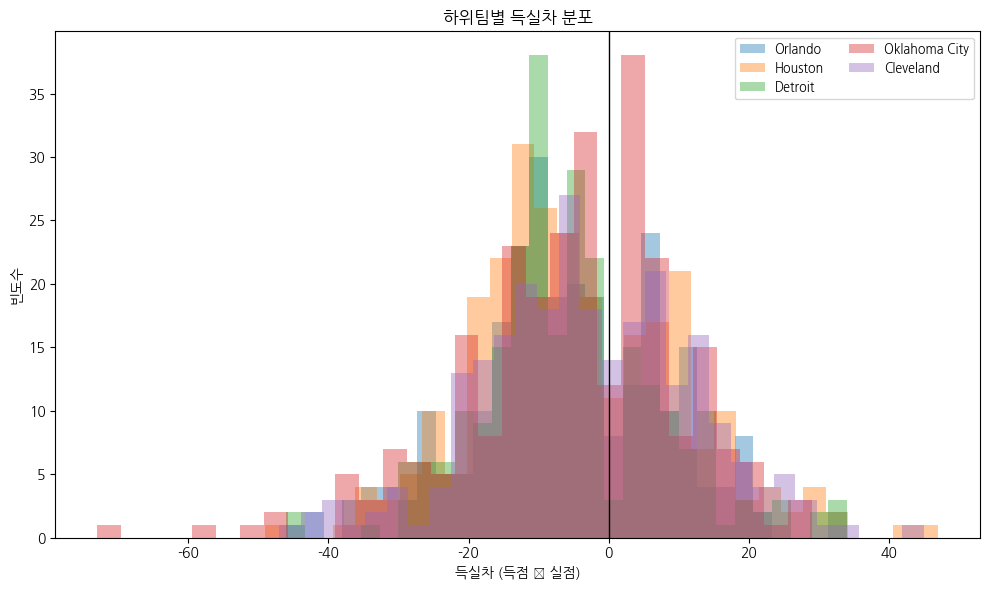

In [44]:
import matplotlib.pyplot as plt

# 하위팀만
low_df = df[df["TEAM_LVL"]=="하위팀"].copy()

plt.figure(figsize=(10,6))

teams = low_df["TEAM"].unique()
for team in teams:
    subset = low_df[low_df["TEAM"]==team]["MARGIN"].dropna()
    plt.hist(subset, bins=30, alpha=0.4, label=team)

plt.axvline(0, color="black", lw=1)
plt.title("하위팀별 득실차 분포")
plt.xlabel("득실차 (득점 − 실점)")
plt.ylabel("빈도수")
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()


In [45]:
# 하위팀만
low_df = df[df["TEAM_LVL"]=="하위팀"].copy()

# 접전(클러치) 경기만
clutch_low = low_df[low_df["IS_CLUTCH"]==1]

# 팀별 승/패 집계
clutch_results = (
    clutch_low.groupby("TEAM")["WIN"]
    .agg(["count","sum"])
    .reset_index()
    .rename(columns={"count":"클러치경기수","sum":"클러치승"})
)
clutch_results["클러치패"] = clutch_results["클러치경기수"] - clutch_results["클러치승"]
clutch_results["클러치승률(%)"] = round(clutch_results["클러치승"]/clutch_results["클러치경기수"]*100,1)

print(clutch_results.sort_values("클러치승률(%)", ascending=False))


/tmp/ipykernel_194227/3597989820.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clutch_low.groupby("TEAM")["WIN"]


             TEAM  클러치경기수  클러치승  클러치패  클러치승률(%)
20  Oklahoma City      82    45    37      54.9
5       Cleveland      59    28    31      47.5
21        Orlando      59    27    32      45.8
10        Houston      53    23    30      43.4
8         Detroit      57    22    35      38.6
0         Atlanta       0     0     0       NaN
1          Boston       0     0     0       NaN
2        Brooklyn       0     0     0       NaN
3       Charlotte       0     0     0       NaN
4         Chicago       0     0     0       NaN
6          Dallas       0     0     0       NaN
7          Denver       0     0     0       NaN
9    Golden State       0     0     0       NaN
11        Indiana       0     0     0       NaN
12  L.A. Clippers       0     0     0       NaN
13    L.A. Lakers       0     0     0       NaN
14        Memphis       0     0     0       NaN
15          Miami       0     0     0       NaN
16      Milwaukee       0     0     0       NaN
17      Minnesota       0     0     0   

/tmp/ipykernel_194227/654794003.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clutch_low.groupby("TEAM")["WIN"]


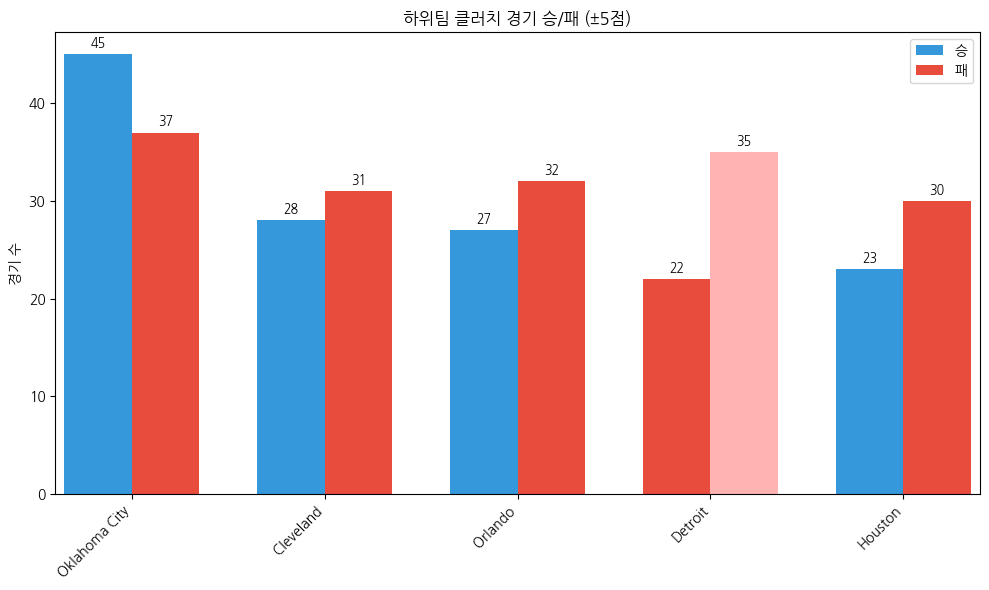

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 하위팀 + 클러치(±5점)만
low_df = df[df["TEAM_LVL"] == "하위팀"].copy()
clutch_low = low_df[low_df["IS_CLUTCH"] == 1].copy()

# 2) 팀별 승/패 집계
tab = (
    clutch_low.groupby("TEAM")["WIN"]
    .agg(["count", "sum"]).reset_index()
    .rename(columns={"count":"클러치경기수", "sum":"클러치승"})
)
tab["클러치패"] = tab["클러치경기수"] - tab["클러치승"]

# (옵션) 클러치 경기 0인 팀 제거 + 정렬
tab = tab[tab["클러치경기수"] > 0].sort_values(["클러치경기수","TEAM"], ascending=[False,True])

# (옵션) 너무 많으면 상위 N개만
# tab = tab.head(10)

# 3) 막대그래프(승/패 나란히) — 하위팀만
x = np.arange(len(tab))
w = 0.35

fig, ax = plt.subplots(figsize=(10,6))
colors_win = ["#e74c3c" if t=="Detroit" else "#3498db" for t in tab["TEAM"]]  # DET 강조(승)
colors_lose= ["#ffb3b3" if t=="Detroit" else "#e74c3c" for t in tab["TEAM"]]  # DET 강조(패 옅게)

b1 = ax.bar(x - w/2, tab["클러치승"],  w, label="승", color=colors_win)
b2 = ax.bar(x + w/2, tab["클러치패"],  w, label="패", color=colors_lose)

# 값 라벨
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.annotate(f"{int(h)}", (bar.get_x()+bar.get_width()/2, h),
                        textcoords="offset points", xytext=(0,3),
                        ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(tab["TEAM"], rotation=45, ha="right")
ax.set_ylabel("경기 수")
ax.set_title("하위팀 클러치 경기 승/패 (±5점)")
ax.legend()
ax.margins(x=0.01)

plt.tight_layout()
plt.show()

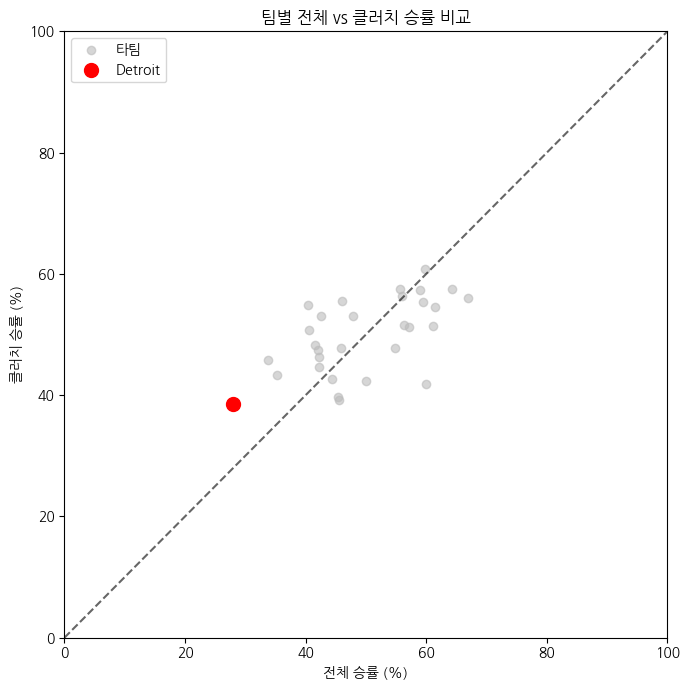

In [47]:
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────
# 1) 팀별 전체승률 vs 클러치승률 테이블 확보
#    (앞에서 team_table 계산한 걸 그대로 씀)
# ─────────────────────────────────────────────
plot_df = team_table.copy()

# 디트로이트 표시용
DET_NAME = "Detroit"  # 필요시 "Detroit Pistons"
plot_df["IS_DET"] = (plot_df["TEAM"] == DET_NAME)

# ─────────────────────────────────────────────
# 2) 시각화: 전체승률 vs 클러치승률 산점도
# ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7,7))

# 다른 팀들(회색)
ax.scatter(plot_df.loc[~plot_df["IS_DET"], "전체승률(%)"],
           plot_df.loc[~plot_df["IS_DET"], "클러치승률(%)"],
           color="#bbbbbb", alpha=0.6, label="타팀")

# 디트로이트(빨강)
ax.scatter(plot_df.loc[plot_df["IS_DET"], "전체승률(%)"],
           plot_df.loc[plot_df["IS_DET"], "클러치승률(%)"],
           color="red", s=100, label=DET_NAME)

# ─────────────────────────────────────────────
# 3) 보조선 & 라벨
# ─────────────────────────────────────────────
lims = [0, 100]
ax.plot(lims, lims, "--", color="black", alpha=0.6)  # y=x 참고선
ax.set_xlim(lims); ax.set_ylim(lims)

ax.set_xlabel("전체 승률 (%)")
ax.set_ylabel("클러치 승률 (%)")
ax.set_title("팀별 전체 vs 클러치 승률 비교")
ax.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_194227/2880034400.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_season = df.groupby(["SEASON","TEAM"]).agg({


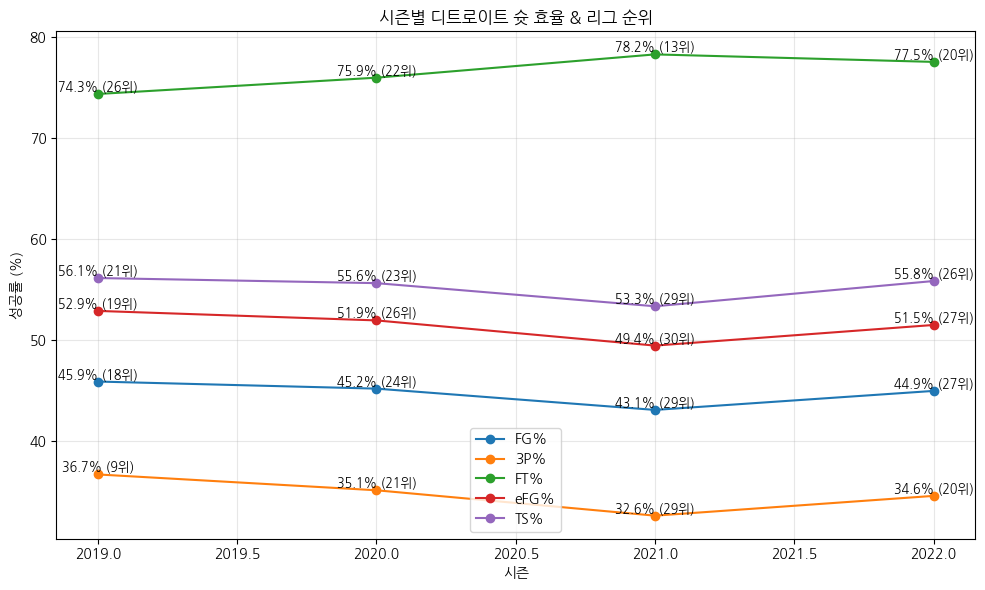

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── 1) 필요한 컬럼만 추출
use_cols = ["SEASON","TEAM","FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]
df = details.loc[:, use_cols].copy()

for c in ["FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ── 2) 시즌+팀별 합산
team_season = df.groupby(["SEASON","TEAM"]).agg({
    "FGM":"sum","FGA":"sum",
    "FG3M":"sum","FG3A":"sum",
    "FTM":"sum","FTA":"sum",
    "PTS":"sum"
}).reset_index()

# ── 3) 지표 계산 함수
def _safe_div(a,b): return np.nan if b==0 else a/b

def calc_rates(r):
    FGM,FGA,FG3M,FG3A,FTM,FTA,PTS = r
    FG  = _safe_div(FGM,FGA)
    TP  = _safe_div(FG3M,FG3A)
    FT  = _safe_div(FTM,FTA)
    eFG = _safe_div(FGM+0.5*FG3M,FGA)
    TS  = _safe_div(PTS, 2*(FGA+0.44*FTA))
    return pd.Series({
        "FG%":FG*100,"3P%":TP*100,"FT%":FT*100,"eFG%":eFG*100,"TS%":TS*100
    })

rates = team_season.apply(lambda row: calc_rates(row[2:]), axis=1)
team_season = pd.concat([team_season, rates], axis=1)

# ── 4) 시즌별 랭킹
metrics = ["FG%","3P%","FT%","eFG%","TS%"]
for m in metrics:
    team_season[m+"_RANK"] = team_season.groupby("SEASON")[m].rank(method="min", ascending=False)

# ── 5) 디트로이트만 추출
DET_NAME = "Detroit"  # 필요시 "Detroit Pistons"
det = team_season[team_season["TEAM"]==DET_NAME]

# ── 6) 시각화
plt.figure(figsize=(10,6))
for m in metrics:
    plt.plot(det["SEASON"], det[m], marker="o", label=m)
    # 각 점 위에 값 + 순위 표기
    for x,y,rk in zip(det["SEASON"], det[m], det[m+"_RANK"]):
        plt.text(x, y, f"{y:.1f}% ({int(rk)}위)", fontsize=9,
                 ha="center", va="bottom")

plt.title("시즌별 디트로이트 슛 효율 & 리그 순위")
plt.xlabel("시즌")
plt.ylabel("성공률 (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


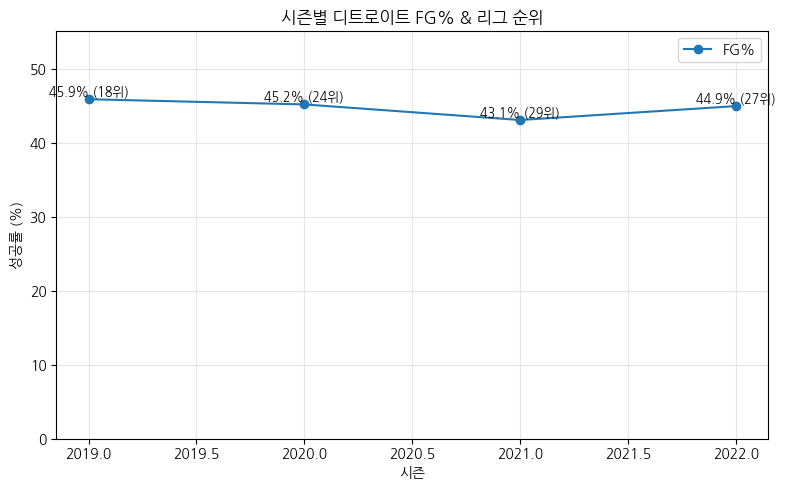

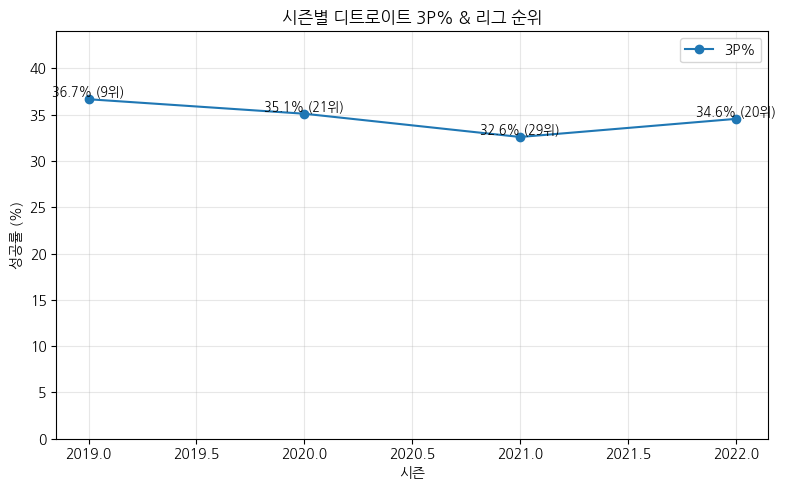

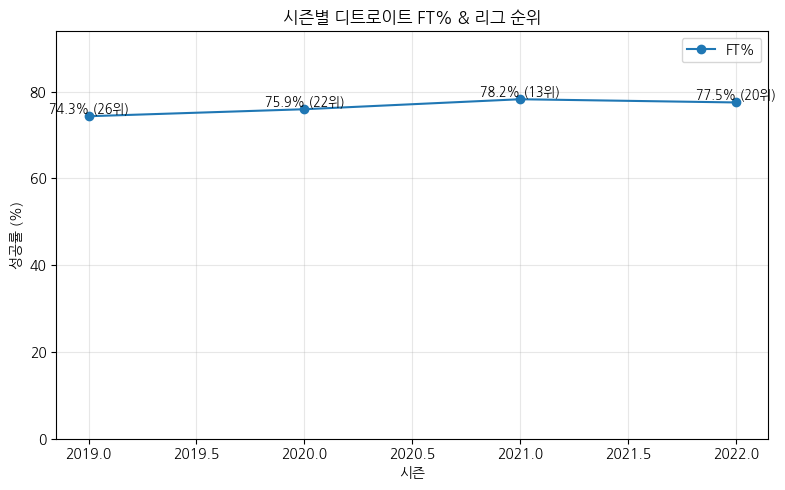

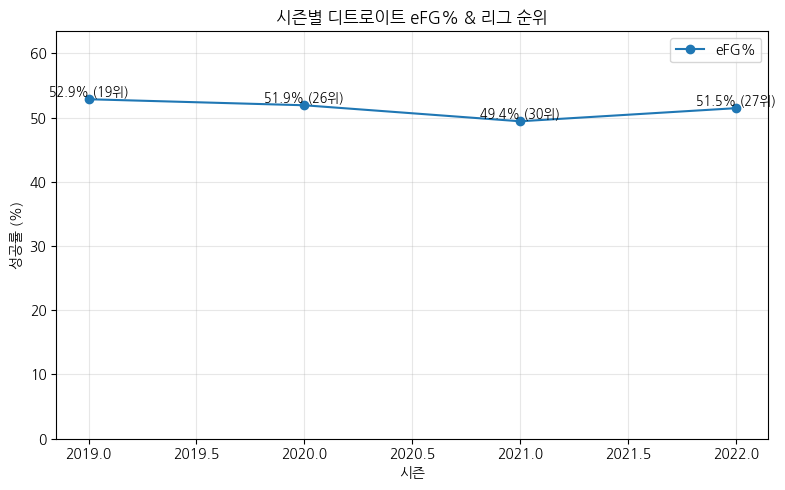

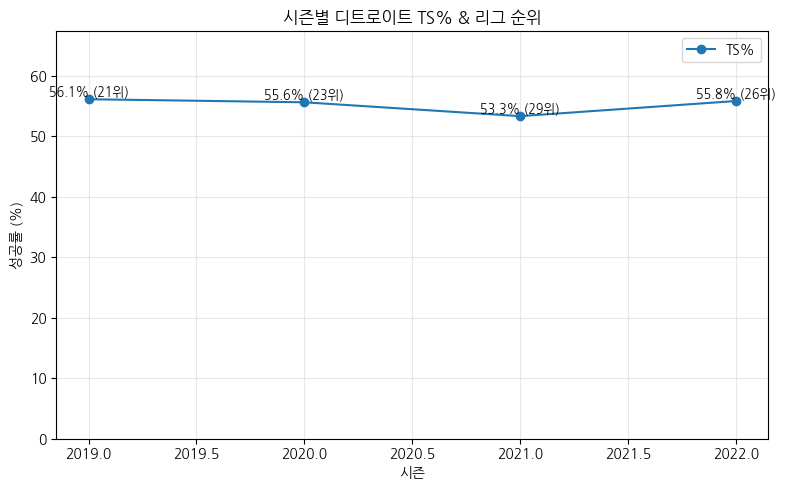

In [49]:
import matplotlib.pyplot as plt

metrics = ["FG%","3P%","FT%","eFG%","TS%"]

for m in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(det["SEASON"], det[m], marker="o", color="tab:blue", label=m)

    # 각 시즌 점 위에 값 + 순위 표기
    for x,y,rk in zip(det["SEASON"], det[m], det[m+"_RANK"]):
        plt.text(x, y, f"{y:.1f}% ({int(rk)}위)", fontsize=9,
                 ha="center", va="bottom")

    plt.title(f"시즌별 디트로이트 {m} & 리그 순위")
    plt.xlabel("시즌")
    plt.ylabel("성공률 (%)")
    plt.ylim(0, max(det[m])*1.2)  # y축 범위 살짝 여유
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



=== 2022-23 Detroit 패배 경기: 슛효율 차이 요약 ===
     Metric    Mean  Median  Games
0   FG_DIFF -0.0562  -0.053     26
1  FG3_DIFF -0.0318  -0.025     26
2   FT_DIFF -0.0164  -0.008     26

[힌트] 평균 차이가 가장 낮은(음수 큰) 지표: FG_DIFF


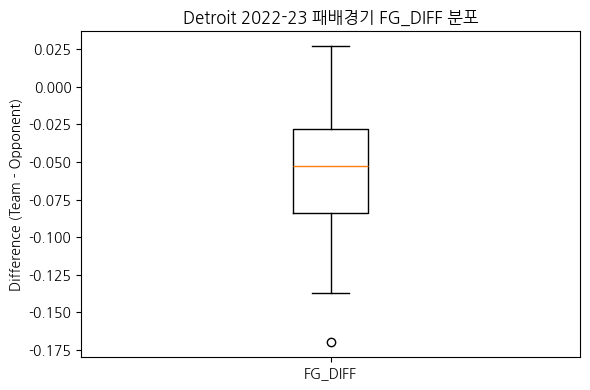

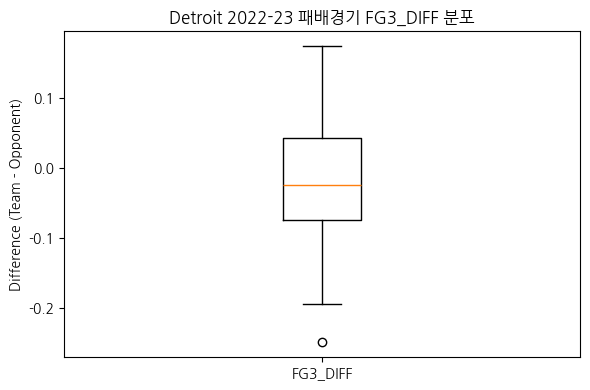

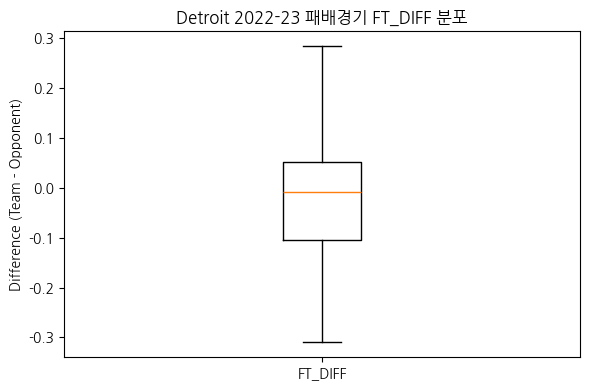

In [50]:

# "팀-상대 슛 효율 차이(FG/3P/FT) → 패배 경기만 분석" 코드

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 사용자 설정
# =========================
TEAM_NAME = "Detroit"   # 분석할 팀 이름 (예: "Detroit")
SEASON = 2022           # 2019=2019-20, 2020=2020-21, 2021=2021-22, 2022=2022-23


# =========================
# 1) 데이터 로드
# =========================
g = load_dataset('games_regular', 2022)

# 필수 컬럼 체크
need = [
    "SEASON","GAME_ID","HOME_TEAM","VISITOR_TEAM","HOME_TEAM_WINS",
    "FG_PCT_home","FG3_PCT_home","FT_PCT_home",
    "FG_PCT_away","FG3_PCT_away","FT_PCT_away"
]
missing = [c for c in need if c not in g.columns]
if missing:
    raise AssertionError(f"필요 컬럼 누락: {missing}")

# 시즌 필터 (예: 2022 → 2022-23)
g = g[g["SEASON"] == SEASON].copy()
if g.empty:
    raise ValueError(f"{SEASON} 시즌 데이터가 비어 있습니다.")


# =========================
# 2) 롱 형태로 변환 (팀 관점의 한 줄, 상대/결과 포함)
# =========================
home_cols = {
    "TEAM": "HOME_TEAM",
    "OPP": "VISITOR_TEAM",
    "FG_PCT": "FG_PCT_home",
    "FG3_PCT": "FG3_PCT_home",
    "FT_PCT": "FT_PCT_home",
}
away_cols = {
    "TEAM": "VISITOR_TEAM",
    "OPP": "HOME_TEAM",
    "FG_PCT": "FG_PCT_away",
    "FG3_PCT": "FG3_PCT_away",
    "FT_PCT": "FT_PCT_away",
}

def build_side(df, side_cols, is_home=True):
    out = pd.DataFrame({
        "SEASON": df["SEASON"],
        "GAME_ID": df["GAME_ID"],
        "TEAM": df[side_cols["TEAM"]],
        "OPP": df[side_cols["OPP"]],
        "FG_PCT": df[side_cols["FG_PCT"]],
        "FG3_PCT": df[side_cols["FG3_PCT"]],
        "FT_PCT": df[side_cols["FT_PCT"]],
    })
    # 승패: 홈이면 HOME_TEAM_WINS=1 → 승, 원정이면 0 → 승
    if is_home:
        out["WIN"] = (df["HOME_TEAM_WINS"] == 1).astype(int)
    else:
        out["WIN"] = (df["HOME_TEAM_WINS"] == 0).astype(int)
    return out

home_long = build_side(g, home_cols, is_home=True)
away_long = build_side(g, away_cols, is_home=False)
long_df = pd.concat([home_long, away_long], ignore_index=True)

# 상대(opp) 슛 효율 가져오기: 같은 경기에서 반대편의 효율을 join
# (간단히: 같은 GAME_ID에서 OPP팀이 TEAM인 행을 매칭)
opp_cols = ["GAME_ID","TEAM","FG_PCT","FG3_PCT","FT_PCT"]
opp_df = long_df[["GAME_ID","TEAM","FG_PCT","FG3_PCT","FT_PCT"]].rename(
    columns={
        "TEAM":"OPP",
        "FG_PCT":"OPP_FG_PCT",
        "FG3_PCT":"OPP_FG3_PCT",
        "FT_PCT":"OPP_FT_PCT"
    }
)

long_df = long_df.merge(opp_df, on=["GAME_ID","OPP"], how="left", validate="m:1")

# =========================
# 3) 차이값(Diff) 계산
# =========================
for a, b, outc in [
    ("FG_PCT","OPP_FG_PCT","FG_DIFF"),
    ("FG3_PCT","OPP_FG3_PCT","FG3_DIFF"),
    ("FT_PCT","OPP_FT_PCT","FT_DIFF"),
]:
    long_df[outc] = long_df[a] - long_df[b]

# =========================
# 4) 분석 대상 팀 + 패배 경기만 필터
# =========================
team_losses = long_df[(long_df["TEAM"] == TEAM_NAME) & (long_df["WIN"] == 0)].copy()
if team_losses.empty:
    raise ValueError(f"{SEASON} 시즌 {TEAM_NAME} 패배 경기가 없습니다(또는 팀명이 다릅니다). "
                     f"팀명 후보: {sorted(long_df['TEAM'].unique())[:15]} ...")

# =========================
# 5) 요약 통계 (평균/중앙값/경기수)
# =========================
summary = {
    "Metric": ["FG_DIFF","FG3_DIFF","FT_DIFF"],
    "Mean":   [team_losses["FG_DIFF"].mean(), team_losses["FG3_DIFF"].mean(), team_losses["FT_DIFF"].mean()],
    "Median": [team_losses["FG_DIFF"].median(), team_losses["FG3_DIFF"].median(), team_losses["FT_DIFF"].median()],
    "Games":  [team_losses["FG_DIFF"].notna().sum(), team_losses["FG3_DIFF"].notna().sum(), team_losses["FT_DIFF"].notna().sum()],
}
summary_df = pd.DataFrame(summary)
print(f"\n=== {SEASON}-{str(SEASON+1)[-2:]} {TEAM_NAME} 패배 경기: 슛효율 차이 요약 ===")
print(summary_df.round(4))

# 어떤 지표가 가장 ‘반복적으로 크게 음수’인지 간단 판정(평균값 기준)
most_negative = summary_df.sort_values("Mean").iloc[0]["Metric"]
print(f"\n[힌트] 평균 차이가 가장 낮은(음수 큰) 지표: {most_negative}")

# =========================
# 6) 분포 시각화 (지표별 박스플롯: 한 그림에 하나씩)
# =========================
def boxplot_diff(series, title):
    fig = plt.figure(figsize=(6,4))
    plt.boxplot(series.dropna())
    plt.xticks([1],[title])
    plt.ylabel("Difference (Team - Opponent)")
    plt.title(f"{TEAM_NAME} {SEASON}-{str(SEASON+1)[-2:]} 패배경기 {title} 분포")
    plt.tight_layout()
    plt.show()

boxplot_diff(team_losses["FG_DIFF"],  "FG_DIFF")
boxplot_diff(team_losses["FG3_DIFF"], "FG3_DIFF")
boxplot_diff(team_losses["FT_DIFF"],  "FT_DIFF")


[TEAM] 사용 팀명: Detroit

=== 시즌별 패배경기: 팀-상대 슛효율 차이 요약 ===
       FG_DIFF               FG3_DIFF               FT_DIFF              
          mean  median count     mean  median count    mean  median count
SEASON                                                                   
2019   -0.0570 -0.0585    46  -0.0247 -0.0205    46 -0.0500 -0.0535    46
2020   -0.0520 -0.0550    52  -0.0615 -0.0510    52 -0.0251 -0.0385    52
2021   -0.0652 -0.0620    59  -0.0663 -0.0700    59 -0.0128 -0.0150    59
2022   -0.0562 -0.0530    26  -0.0318 -0.0250    26 -0.0164 -0.0080    26

[힌트] 시즌별 평균 차이가 가장 낮은(음수 큰) 지표:
SEASON
2019     FG_DIFF
2020    FG3_DIFF
2021    FG3_DIFF
2022     FG_DIFF
dtype: object


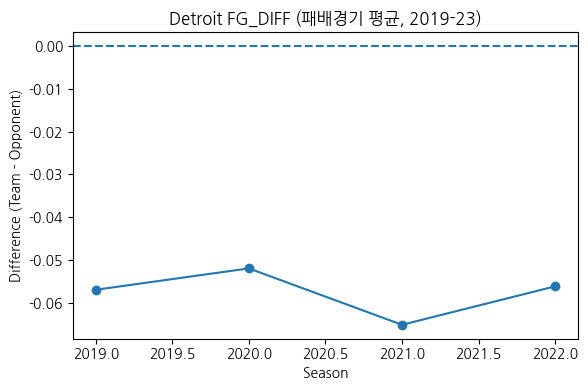

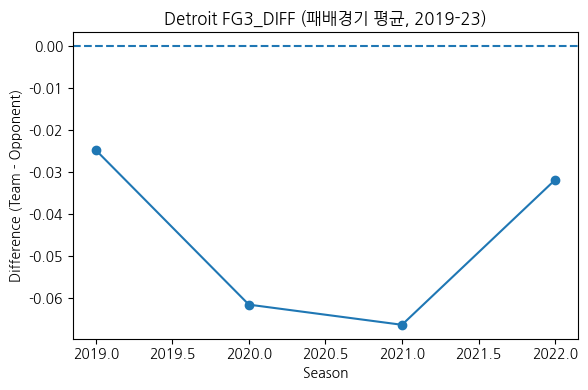

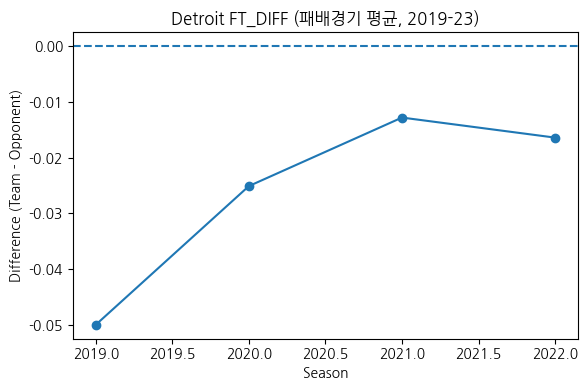

<Figure size 600x400 with 0 Axes>

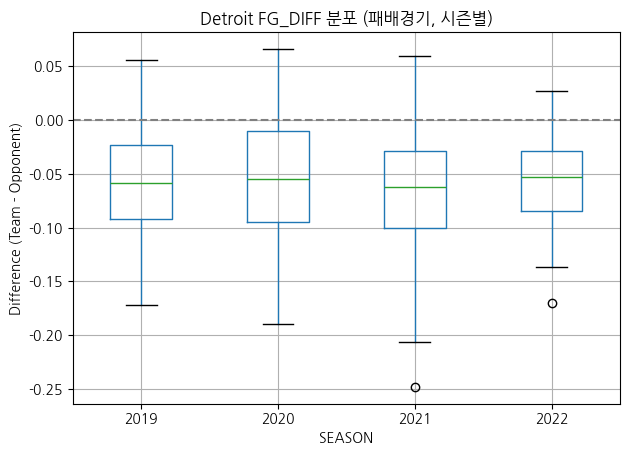

<Figure size 600x400 with 0 Axes>

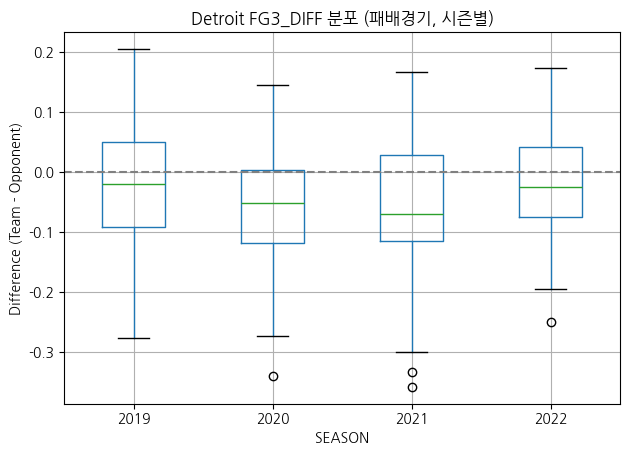

<Figure size 600x400 with 0 Axes>

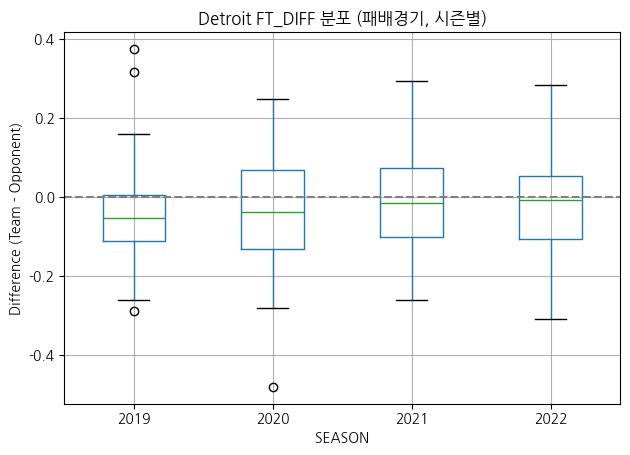

In [51]:

# 전체 시즌(2019~2022) 패배경기에서 팀 vs 상대 슛효율 차이(FG/3P/FT)

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) 사용자 설정
# =========================
TEAM_NAME_CANDIDATES = ["Detroit", "Detroit Pistons"]  # 데이터 표기 상이 대비
SEASONS = [2019, 2020, 2021, 2022]  # 2019-20 ~ 2022-23


# =========================
# 1) 데이터 로드
# =========================
g = load_dataset('games_regular', 2022)

# 필수 컬럼 체크
need = [
    "SEASON","GAME_ID","HOME_TEAM","VISITOR_TEAM","HOME_TEAM_WINS",
    "FG_PCT_home","FG3_PCT_home","FT_PCT_home",
    "FG_PCT_away","FG3_PCT_away","FT_PCT_away"
]
missing = [c for c in need if c not in g.columns]
if missing:
    raise AssertionError(f"필요 컬럼 누락: {missing}")

# 대상 시즌만 필터 (2019~2022)
g = g[g["SEASON"].isin(SEASONS)].copy()
if g.empty:
    raise ValueError(f"{SEASONS} 시즌 데이터가 비어 있습니다.")

# =========================
# 2) 롱 형태로 변환 (팀 관점 1행) - 네가 쓰던 방식 유지
# =========================
home_cols = {
    "TEAM": "HOME_TEAM",
    "OPP": "VISITOR_TEAM",
    "FG_PCT": "FG_PCT_home",
    "FG3_PCT": "FG3_PCT_home",
    "FT_PCT": "FT_PCT_home",
}
away_cols = {
    "TEAM": "VISITOR_TEAM",
    "OPP": "HOME_TEAM",
    "FG_PCT": "FG_PCT_away",
    "FG3_PCT": "FG3_PCT_away",
    "FT_PCT": "FT_PCT_away",
}

def build_side(df, side_cols, is_home=True):
    out = pd.DataFrame({
        "SEASON": df["SEASON"],
        "GAME_ID": df["GAME_ID"],
        "TEAM": df[side_cols["TEAM"]],
        "OPP": df[side_cols["OPP"]],
        "FG_PCT": df[side_cols["FG_PCT"]],
        "FG3_PCT": df[side_cols["FG3_PCT"]],
        "FT_PCT": df[side_cols["FT_PCT"]],
    })
    # 승패 플래그: 홈이면 HOME_TEAM_WINS=1 → 승, 원정이면 0 → 승
    if is_home:
        out["WIN"] = (df["HOME_TEAM_WINS"] == 1).astype(int)
    else:
        out["WIN"] = (df["HOME_TEAM_WINS"] == 0).astype(int)
    return out

home_long = build_side(g, home_cols, is_home=True)
away_long = build_side(g, away_cols, is_home=False)
long_df = pd.concat([home_long, away_long], ignore_index=True)

# 같은 경기에서 상대 효율 붙이기
opp_df = long_df[["GAME_ID","TEAM","FG_PCT","FG3_PCT","FT_PCT"]].rename(
    columns={
        "TEAM":"OPP",
        "FG_PCT":"OPP_FG_PCT",
        "FG3_PCT":"OPP_FG3_PCT",
        "FT_PCT":"OPP_FT_PCT"
    }
)
long_df = long_df.merge(opp_df, on=["GAME_ID","OPP"], how="left", validate="m:1")

# =========================
# 3) 팀명 자동 선택 (Detroit / Detroit Pistons)
# =========================
team_unique = set(long_df["TEAM"].unique().tolist())
TEAM_NAME = next((t for t in TEAM_NAME_CANDIDATES if t in team_unique), None)
if TEAM_NAME is None:
    raise ValueError(f"팀명을 찾지 못했습니다. 후보={TEAM_NAME_CANDIDATES}, 실제예시={sorted(list(team_unique))[:15]}")
print(f"[TEAM] 사용 팀명: {TEAM_NAME}")

# =========================
# 4) 차이값(Diff) 계산
# =========================
long_df["FG_DIFF"]  = long_df["FG_PCT"]  - long_df["OPP_FG_PCT"]
long_df["FG3_DIFF"] = long_df["FG3_PCT"] - long_df["OPP_FG3_PCT"]
long_df["FT_DIFF"]  = long_df["FT_PCT"]  - long_df["OPP_FT_PCT"]

# =========================
# 5) 대상 팀 + 패배 경기만
# =========================
team_losses = long_df[(long_df["TEAM"]==TEAM_NAME) & (long_df["WIN"]==0)].copy()
if team_losses.empty:
    raise ValueError(f"{TEAM_NAME} 패배 경기 데이터가 없습니다.")

# =========================
# 6) 시즌별 요약 (평균/중앙값/경기수)
# =========================
summary = (team_losses
           .groupby("SEASON")[["FG_DIFF","FG3_DIFF","FT_DIFF"]]
           .agg(["mean","median","count"])
           .round(4))

print("\n=== 시즌별 패배경기: 팀-상대 슛효율 차이 요약 ===")
print(summary)

# 시즌별 평균에서 가장 음수(열세)인 지표
most_negative_by_season = (
    summary.xs("mean", axis=1, level=1).idxmin(axis=1)
)
print("\n[힌트] 시즌별 평균 차이가 가장 낮은(음수 큰) 지표:")
print(most_negative_by_season)

# =========================
# 7) 시즌별 추세 그래프 (평균값 라인)
# =========================
means = summary.xs("mean", axis=1, level=1)
for col in ["FG_DIFF","FG3_DIFF","FT_DIFF"]:
    plt.figure(figsize=(6,4))
    plt.plot(means.index, means[col], marker="o")
    plt.axhline(0, linestyle="--")
    plt.title(f"{TEAM_NAME} {col} (패배경기 평균, {SEASONS[0]}-{str(SEASONS[-1]+1)[-2:]})")
    plt.xlabel("Season")
    plt.ylabel("Difference (Team - Opponent)")
    plt.tight_layout()
    plt.show()

# =========================
# 8) 시즌별 박스플롯 (분포 비교)
# =========================
# 지표 목록
metrics = ["FG_DIFF", "FG3_DIFF", "FT_DIFF"]

# 시즌별 박스플롯을 지표별로 따로 그리기
for col in metrics:
    plt.figure(figsize=(6,4))
    team_losses.boxplot(column=col, by="SEASON")
    plt.suptitle("")  # 위쪽 자동 타이틀 제거
    plt.title(f"{TEAM_NAME} {col} 분포 (패배경기, 시즌별)")
    plt.axhline(0, linestyle="--", color="gray")
    plt.ylabel("Difference (Team - Opponent)")
    plt.tight_layout()
    plt.show()

# (선택) CSV로 저장하고 싶으면 주석 해제
# summary.to_csv("detroit_losses_shooting_diff_by_season.csv")


[OK] games_details_regular loaded (season=2022) shape=(87378, 27)
[OK] ranking_regular loaded (season=2022) shape=(19830, 11)


/tmp/ipykernel_194227/1614943252.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tg = (games_details[need_det]


[TEAM] Detroit


'\n=== Top7 (All Seasons) 데이터 샘플 ==='

,SEASON,TEAM,GAME_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS,FG%,3P%,FT%,eFG%,TS%
0,2019,Denver,21900001,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2019,Denver,21900002,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2019,Denver,21900003,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,2019,Denver,21900004,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,2019,Denver,21900005,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


'\nTop7 평균:'

{'FG%': 0.4730276280062908,
 '3P%': 0.36902512806152843,
 'FT%': 0.7884896709554594,
 'eFG%': 0.5473337365932355,
 'TS%': 0.5827004560569818}

'\n=== Detroit (2022-23) 데이터 샘플 ==='

,SEASON,TEAM,GAME_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS,FG%,3P%,FT%,eFG%,TS%
403172,2022,Detroit,21900001,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
403173,2022,Detroit,21900002,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
403174,2022,Detroit,21900003,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
403175,2022,Detroit,21900004,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
403176,2022,Detroit,21900005,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


'\nDetroit 평균:'

{'FG%': 0.44932521556002464,
 '3P%': 0.34205174308490743,
 'FT%': 0.781199326535046,
 'eFG%': 0.5143245108492285,
 'TS%': 0.5578339743848121}

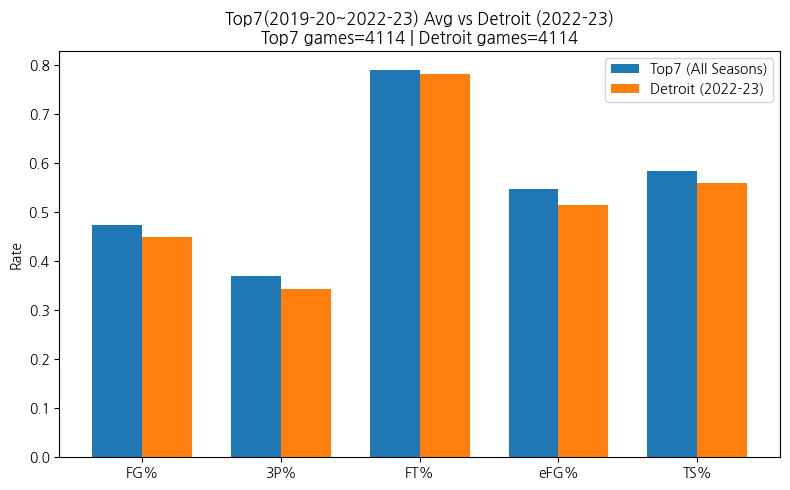

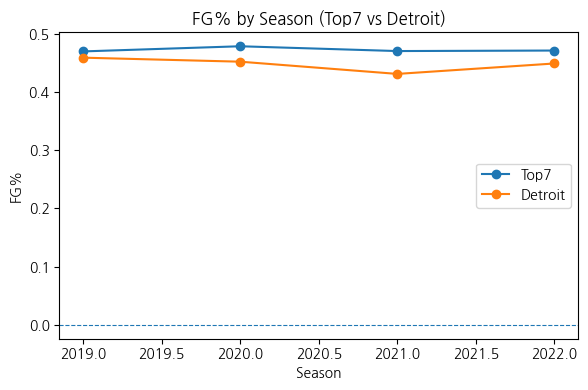

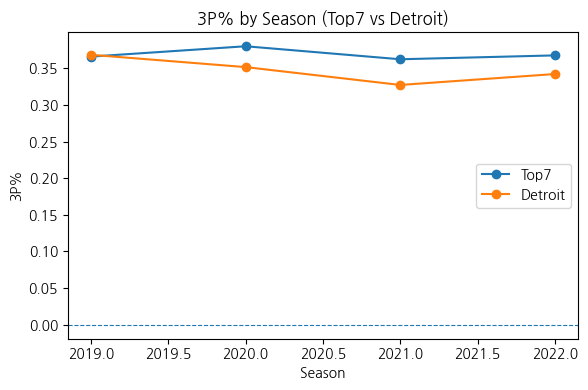

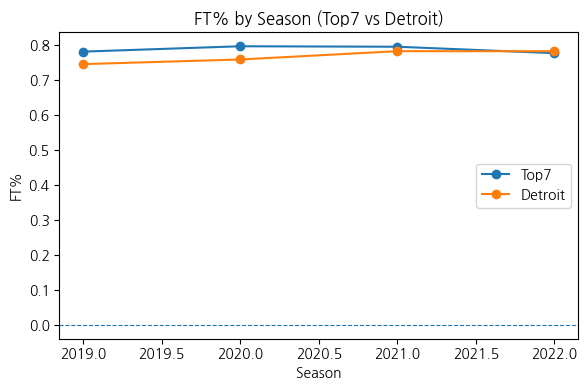

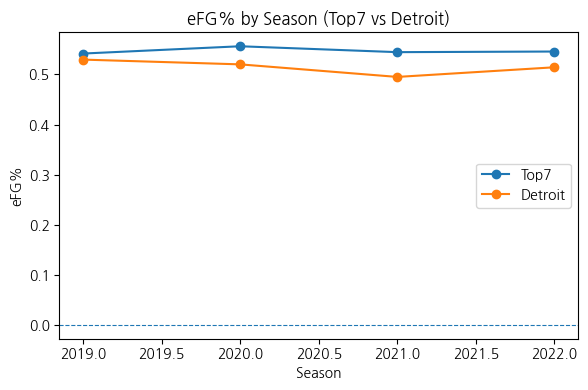

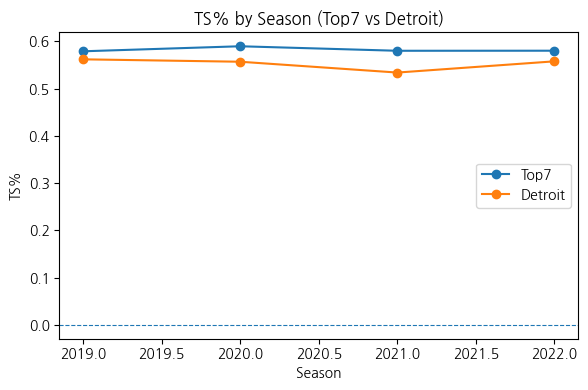

/tmp/ipykernel_194227/1614943252.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


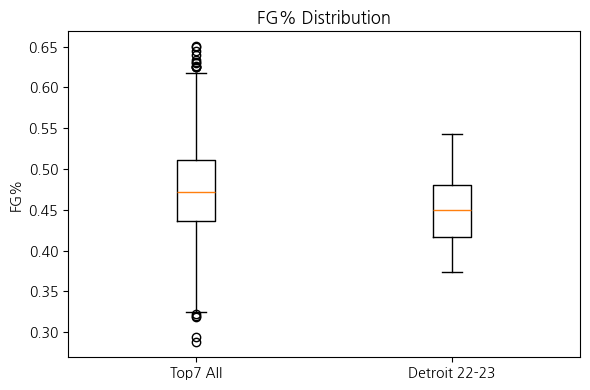

/tmp/ipykernel_194227/1614943252.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


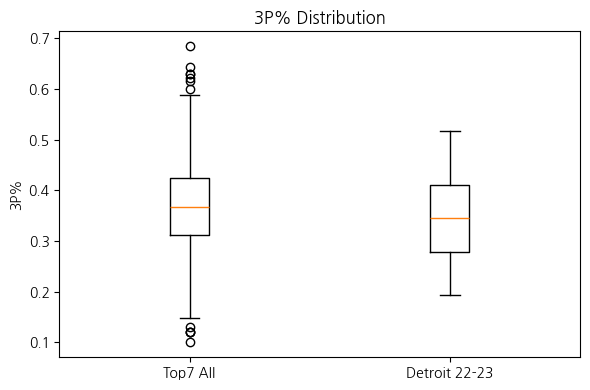

/tmp/ipykernel_194227/1614943252.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


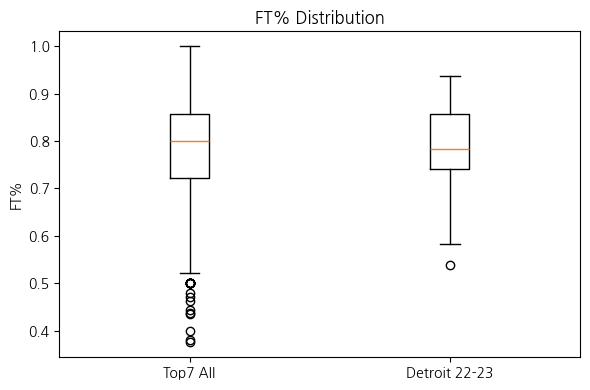

/tmp/ipykernel_194227/1614943252.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


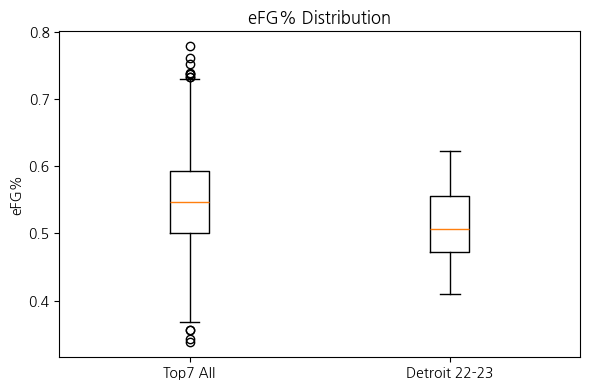

/tmp/ipykernel_194227/1614943252.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


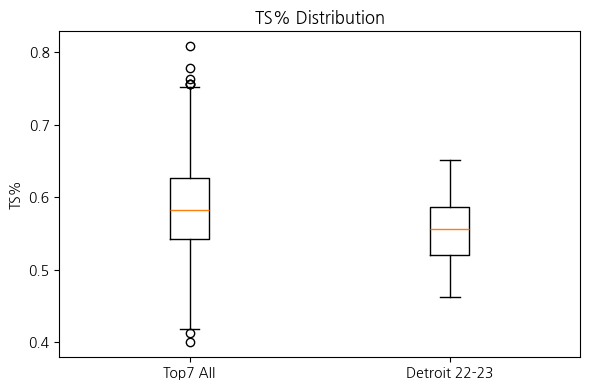


=== 요약(막대그래프 기준 값) ===
  Metric  Top7_AllSeasons  Detroit_2022_23
0    FG%           0.4730           0.4493
1    3P%           0.3690           0.3421
2    FT%           0.7885           0.7812
3   eFG%           0.5473           0.5143
4    TS%           0.5827           0.5578


In [52]:
# Detroit vs 상위 7팀 슛 효율 비교 + 그래프(막대/라인/박스플롯)

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) 프로젝트 루트 보정(필요 시)
# -----------------------------

SEASONS = [2019, 2020, 2021, 2022]  # 2019-20 ~ 2022-23
METRICS = ["FG%", "3P%", "FT%", "eFG%", "TS%"]
DET_CANDIDATES = ["Detroit", "Detroit Pistons"]

# -----------------------------
# 1) 안전 로더: load_dataset 우선, 시즌 자동 시도
# -----------------------------
def load_auto(name, seasons=(2022, 2021, 2020, 2019, None)):
    errors = []
    for s in seasons:
        try:
            df = load_dataset(name, season=s) if s is not None else load_dataset(name)
            if isinstance(df, pd.DataFrame) and not df.empty:
                print(f"[OK] {name} loaded (season={s}) shape={df.shape}")
                return df
        except Exception as e:
            errors.append((s, str(e)))
    raise FileNotFoundError("[FAIL] " + name + ":\n" + "\n".join(f"- season={s}: {e}" for s, e in errors))

# ---- 데이터 로드
games_details = load_auto("games_details_regular")
ranking       = load_auto("ranking_regular")

# -----------------------------
# 2) 시즌별 상위 7팀 목록
# -----------------------------
need_rank = {"SEASON_ID","TEAM","TEAM_LVL"}
miss = need_rank - set(ranking.columns)
if miss:
    raise AssertionError(f"ranking_regular 누락 컬럼: {sorted(miss)}")

top7_by_season = (
    ranking.query("TEAM_LVL == '상위팀'")[["SEASON_ID","TEAM"]]
           .drop_duplicates()
           .groupby("SEASON_ID")["TEAM"]
           .apply(list).to_dict()
)

# -----------------------------
# 3) 선수 → 팀-경기 집계 + 슛 효율
# -----------------------------
need_det = ["GAME_ID","SEASON","TEAM","FGM","FGA","FG3M","FG3A","FTM","FTA","PTS"]
miss2 = set(need_det) - set(games_details.columns)
if miss2:
    raise AssertionError(f"games_details_regular 누락 컬럼: {sorted(miss2)}")

tg = (games_details[need_det]
      .groupby(["SEASON","TEAM","GAME_ID"], as_index=False).sum())

tg["FG%"]  = np.where(tg["FGA"]>0, tg["FGM"]/tg["FGA"], np.nan)
tg["3P%"]  = np.where(tg["FG3A"]>0, tg["FG3M"]/tg["FG3A"], np.nan)
tg["FT%"]  = np.where(tg["FTA"]>0, tg["FTM"]/tg["FTA"], np.nan)
tg["eFG%"] = np.where(tg["FGA"]>0, (tg["FGM"] + 0.5*tg["FG3M"])/tg["FGA"], np.nan)
tg["TS%"]  = np.where((tg["FGA"] + 0.44*tg["FTA"])>0, tg["PTS"]/(2*(tg["FGA"] + 0.44*tg["FTA"])), np.nan)

# Detroit 팀명 자동 인식
team_names = set(tg["TEAM"].unique())
DET = next((t for t in DET_CANDIDATES if t in team_names), None)
if DET is None:
    raise ValueError(f"Detroit 팀명을 찾지 못했습니다. 후보={DET_CANDIDATES}, 예시={sorted(list(team_names))[:15]}")
print("[TEAM]", DET)

# -----------------------------
# 4) 시즌별 평균: Top7 vs Detroit
# -----------------------------
rows = []
top_all_parts = []
for s in SEASONS:
    top_list = top7_by_season.get(s, [])
    top_df   = tg[(tg["SEASON"]==s) & (tg["TEAM"].isin(top_list))]
    det_df   = tg[(tg["SEASON"]==s) & (tg["TEAM"]==DET)]
    row = {"SEASON": s,
           "Top7_games": top_df["GAME_ID"].nunique(),
           "DET_games": det_df["GAME_ID"].nunique()}
    for m in METRICS:
        row[f"Top7_{m}"] = float(top_df[m].mean()) if not top_df.empty else np.nan
        row[f"DET_{m}"]  = float(det_df[m].mean()) if not det_df.empty else np.nan
    rows.append(row)
    if not top_df.empty:
        top_all_parts.append(top_df)

season_cmp = pd.DataFrame(rows)
season_means_top = season_cmp[[f"Top7_{m}" for m in METRICS]].copy()
season_means_det = season_cmp[[f"DET_{m}"  for m in METRICS]].copy()

# Top7 모든 시즌 합산 평균 vs DET 22-23
top_all = pd.concat(top_all_parts, ignore_index=True) if top_all_parts else pd.DataFrame(columns=METRICS)
det_2223 = tg[(tg["SEASON"]==2022) & (tg["TEAM"]==DET)]
top_all_avg = {m: float(top_all[m].mean()) if not top_all.empty else np.nan for m in METRICS}
det_2223_avg = {m: float(det_2223[m].mean()) if not det_2223.empty else np.nan for m in METRICS}

# Top7 모든 시즌 데이터 일부 미리보기 + 평균값
display("\n=== Top7 (All Seasons) 데이터 샘플 ===")
display(top_all.head())
display("\nTop7 평균:")
display(top_all_avg)

# Detroit 22-23 데이터 일부 미리보기 + 평균값
display(f"\n=== {DET} (2022-23) 데이터 샘플 ===")
display(det_2223.head())
display(f"\n{DET} 평균:")
display(det_2223_avg)

# -----------------------------
# 5) 그래프 ① 막대: Top7(모든 시즌) vs DET(22-23)
# -----------------------------
metrics = METRICS
x = np.arange(len(metrics)); width = 0.36

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [top_all_avg[m] for m in metrics], width, label="Top7 (All Seasons)")
plt.bar(x + width/2, [det_2223_avg[m] for m in metrics], width, label=f"{DET} (2022-23)")
plt.xticks(x, metrics)
plt.ylabel("Rate")
plt.title(f"Top7(2019-20~2022-23) Avg vs {DET} (2022-23)\n"
          f"Top7 games={top_all['GAME_ID'].nunique()} | {DET} games={det_2223['GAME_ID'].nunique()}")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6) 그래프 ② 라인: 시즌별 평균 추세 (Top7 vs DET)
# -----------------------------
for m in METRICS:
    plt.figure(figsize=(6,4))
    plt.plot(season_cmp["SEASON"], season_cmp[f"Top7_{m}"], marker="o", label="Top7")
    plt.plot(season_cmp["SEASON"], season_cmp[f"DET_{m}"],  marker="o", label=DET)
    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.title(f"{m} by Season (Top7 vs {DET})")
    plt.xlabel("Season")
    plt.ylabel(m)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7) 그래프 ③ 박스플롯: 분포 비교 (Top7 All vs DET 22-23)
# -----------------------------
# 각 지표별로 Top7 전체(2019~22)와 DET(22-23) 분포를 나란히 비교
for m in METRICS:
    data = []
    labels = []
    if not top_all.empty:
        data.append(top_all[m].dropna().values)
        labels.append("Top7 All")
    if not det_2223.empty:
        data.append(det_2223[m].dropna().values)
        labels.append(f"{DET} 22-23")
    if len(data) >= 1:
        plt.figure(figsize=(6,4))
        plt.boxplot(data, labels=labels)
        plt.title(f"{m} Distribution")
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

# (선택) 표도 확인하고 싶다면:
summary_bar = pd.DataFrame({
    "Metric": METRICS,
    "Top7_AllSeasons": [top_all_avg[m] for m in METRICS],
    f"{DET}_2022_23":   [det_2223_avg[m] for m in METRICS],
}).round(4)
print("\n=== 요약(막대그래프 기준 값) ===")
print(summary_bar)


## 하경님 시각화

In [69]:
df = load_dataset('games_details_regular', 2022)

In [109]:
season = 2022
season_cond = df['SEASON'] == season

df = df[season_cond]

In [129]:
team_stats=(df
            .groupby(['TEAM','GAME_ID'], observed=True)[['FGM','FGA','FTA','OREB','TO','MIN']]
            .sum()
            .reset_index())

team_stats['team_poss']=(
    team_stats['FGA']+
    (0.44*team_stats['FTA'])-
    team_stats['OREB']+
    team_stats['TO']
).round(2)

team_stats=team_stats.rename(columns={'MIN':'team_minutes'})
team_stats=team_stats.rename(columns={'FGM':'team_FGM'})
team_stats['team_minutes']=team_stats['team_minutes'].round(2)

In [130]:
df['MIN']=df['MIN'].round(2)
details = df.merge(
    team_stats[['GAME_ID','TEAM','team_poss','team_minutes','team_FGM']],
    on=['GAME_ID','TEAM'],
    how='left'
)


# 3. USG% 계산
details['USG%'] = 100 * (
    (details['FGA'] + 0.44 * details['FTA'] + details['TO']) * (details['team_minutes'] / 5)
) / (details['MIN'] * details['team_poss'])

details['USG%'] = details['USG%'].round(2)


/tmp/ipykernel_194227/3467790889.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
details['player_poss'] = (
    details['FGA'] + (0.44*details['FTA']) + details['TO']
)

details['PTS_per_poss'] = (details['PTS'] / details['player_poss']).round(2)

In [132]:
details['TS%']=details['PTS']/(2*(details['FGA']+0.44*details['FTA']))
details['TS%']=details['TS%'].round(2)

In [133]:
details['TO%']=details['TO']/(details['FGA']+0.44*details['FTA']+details['TO'])
details['TO%']=details['TO%'].round(2)

In [134]:
import numpy as np
# BBR 공식: AST% = 100 * AST / [ ((MIN / (team_minutes/5)) * team_FGM) - FGM ]
den = ((details['MIN'] / (details['team_minutes'] / 5.0)) * details['team_FGM']) - details['FGM']
details['AST%'] = (100.0 * details['AST'] / den.replace(0, np.nan)).clip(0, 100)
details['AST%']=details['AST%'].round(2)

In [135]:
details

,DATE,GAME_ID,SEASON,TEAM,TEAM_LVL,PLAYER_ID,START_POSITION,MIN,FGM,FGA,...,PLUS_MINUS,team_poss,team_minutes,team_FGM,USG%,player_poss,PTS_per_poss,TS%,TO%,AST%
0,2022-10-18,22200001,2022,Boston,중위팀,1630573,SUB,3.32,0,0,...,3,98.32,239.99,46,0.00,0.00,NaN,NaN,NaN,0.00
1,2022-10-18,22200001,2022,Boston,중위팀,1628369,F,38.62,13,20,...,10,98.32,239.99,46,34.08,26.96,1.30,0.73,0.11,16.66
2,2022-10-18,22200001,2022,Boston,중위팀,201933,SUB,8.28,0,2,...,-5,98.32,239.99,46,16.98,2.88,0.35,0.17,0.00,12.60
3,2022-10-18,22200001,2022,Boston,중위팀,1629684,SUB,23.95,5,5,...,-3,98.32,239.99,46,12.88,6.32,2.37,1.19,0.00,5.57
4,2022-10-18,22200001,2022,Boston,중위팀,203943,SUB,20.17,1,2,...,7,98.32,239.99,46,4.84,2.00,1.00,0.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178,2022-12-22,22200478,2022,Washington,중위팀,201959,SUB,25.03,3,3,...,-3,96.48,239.98,46,5.96,3.00,2.00,1.00,0.00,4.76
10179,2022-12-22,22200478,2022,Washington,중위팀,1628420,G,30.27,2,5,...,3,96.48,239.98,46,12.23,7.44,0.67,0.46,0.27,14.81
10180,2022-12-22,22200478,2022,Washington,중위팀,203078,G,31.08,13,20,...,4,96.48,239.98,46,38.03,23.76,1.26,0.69,0.08,29.78
10181,2022-12-22,22200478,2022,Utah,상위팀,1631117,C,32.38,5,7,...,16,98.24,240.02,42,13.40,8.88,1.35,0.76,0.11,4.29


In [136]:
players=load_dataset('games_details')

In [137]:
games_details = load_dataset('games_details').astype({'PLAYER_ID': str}).drop_duplicates(subset=['PLAYER_ID', 'PLAYER_NAME'])

player_map = games_details.set_index('PLAYER_ID')['PLAYER_NAME'].to_dict()

In [138]:
df1 = details.copy()
df1['PLAYER_NAME'] = df1['PLAYER_ID'].map(player_map)

In [148]:
pos = ['F','G','C']

# 1. DET + 선발 포지션만 뽑기
det_details = df1[
    (df1['TEAM'] == 'Detroit') & 
    (df1['START_POSITION'].isin(pos))
].copy()

# 2. USG% × MIN 계산
det_details['USG_x_MIN'] = det_details['USG%'] * det_details['MIN']

# 3. 포지션별 합계
det_pos = (
    det_details.groupby('START_POSITION', observed=True)['USG_x_MIN']
    .sum()
    .reset_index()
)

# 4. 전체 합 대비 비중
total = det_pos['USG_x_MIN'].sum()
det_pos['POS_share'] = det_pos['USG_x_MIN'] / total

print(det_pos)


  START_POSITION   USG_x_MIN  POS_share
0              C  16905.4125   0.143870
1              F  48617.0843   0.413747
2              G  51981.9242   0.442383


In [149]:
player_pos_usg = (
    det_details
      .groupby(['PLAYER_ID','PLAYER_NAME','START_POSITION'], observed=True)
      .agg(
          USG_minutes_sum = ('USG_x_MIN','sum'),    # Σ(USG% × MIN)
          MIN_sum         = ('MIN','sum'),          # Σ MIN
          games           = ('GAME_ID','nunique')   # 경기 수
      )
      .assign(
          USG_wavg = lambda d: np.where(d['MIN_sum']>0,
                                        d['USG_minutes_sum']/d['MIN_sum'],
                                        np.nan)
      )
      .reset_index()
      .sort_values(['START_POSITION','USG_wavg'], ascending=[True, False])
)

# 보기 좋게 반올림
player_pos_usg['USG_wavg'] = player_pos_usg['USG_wavg'].round(2)
player_pos_usg['USG_minutes_sum'] = player_pos_usg['USG_minutes_sum'].round(2)

print(player_pos_usg.head(10))

   PLAYER_ID        PLAYER_NAME START_POSITION  USG_minutes_sum  MIN_sum  \
0    1628963  Marvin Bagley III              C          6869.67   314.58   
3    1630191     Isaiah Stewart              C          7317.93   392.64   
9    1631105        Jalen Duren              C          2717.81   205.36   
11    202711   Bojan Bogdanovic              F         28639.68  1018.55   
2    1630180         Saddiq Bey              F         11851.47   531.43   
4    1630191     Isaiah Stewart              F          6746.47   358.18   
5    1630587      Isaiah Livers              F          1379.46   117.55   
7    1630595    Cade Cunningham              G         13199.55   400.18   
8    1631093         Jaden Ivey              G         24111.45   875.72   
1    1630165      Killian Hayes              G         13461.93   605.83   

    games  USG_wavg  
0      13     21.84  
3      14     18.64  
9       7     13.23  
11     33     28.12  
2      17     22.30  
4      13     18.84  
5       5

In [150]:
import plotly.express as px

# 포지션별 파이차트 (하나씩 그려도 됨)
for pos in ['C', 'F', 'G']:
    subdf = player_pos_usg[player_pos_usg['START_POSITION'] == pos].copy()
    if subdf.empty:
        continue  # 해당 포지션 데이터 없으면 건너뛰기

    fig = px.pie(
        subdf,
        names='PLAYER_NAME',
        values='USG_minutes_sum',
        title=f"DET {pos} 포지션: 선수별 공격권 비중 (USG%×MIN)",
        hole=0.3  # 도넛형 (원하면 제거)
    )
    fig.update_traces(textinfo="percent+label", textposition="inside", showlegend=True)
    fig.update_layout(legend_title="선수")
    fig.show()




In [151]:
import plotly.express as px

# 디트로이트 팀만
det = df1[df1['TEAM'] == 'Detroit'].copy()

# 선수별 평균 PPP 구하기
det_player = det.groupby('PLAYER_NAME')['PTS_per_poss'].mean().round(2).reset_index()
print(det_player.info())
det_player['PLAYER_NAME'] = det_player['PLAYER_NAME'].astype(str)
det1=det_player.sort_values('PTS_per_poss', ascending=False)
# 막대그래프 그리기
fig = px.bar(det1,
             x='PLAYER_NAME',
             y='PTS_per_poss',
             title="Detroit 선수별 평균 PTS per Poss",
            )
fig.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER_NAME   17 non-null     object 
 1   PTS_per_poss  16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 400.0+ bytes
None


In [152]:
pos = ['C','F','G']
top_starters = df1[(df1['TEAM_LVL'] == '상위팀') &
                   (df1['START_POSITION'].isin(pos))].copy()

# 2) 선수별 + 포지션별 TS% 평균 계산
player_pos_ts = top_starters.groupby(['PLAYER_NAME','START_POSITION'], as_index=False)['TS%'].mean()

/tmp/ipykernel_194227/2235638684.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [153]:
# 1) 상위팀 + 선발(C/F/G)만 필터
pos = ['C','F','G']
top_starters = df1[(df1['TEAM_LVL'] == '상위팀') &
                   (df1['START_POSITION'].isin(pos))].copy()

# 2) 상위팀 선발 전체의 TS% 평균
top_starters_ts = top_starters['TS%'].mean()

print("상위팀 선발 평균 TS%:", round(top_starters_ts, 3))

상위팀 선발 평균 TS%: 0.588


In [154]:
# 1) 선발 포지션 정의
pos = ['C','F','G']

# 2) 디트로이트 팀 + 선발만 필터
det_starters = df1[
    (df1['TEAM']=="Detroit") &
    (df1['START_POSITION'].isin(pos))
].copy()

# 3) TS% 평균 계산
det_starters_ts = det_starters['TS%'].mean()

print("디트로이트 선발 평균 TS%:", round(det_starters_ts, 3))

디트로이트 선발 평균 TS%: 0.561


In [156]:
import plotly.express as px

# 디트로이트 선발만 필터
pos = ['C','F','G']
det_starters = df1[
    (df1['TEAM']=="Detroit") &
    (df1['START_POSITION'].isin(pos))
].copy()

# 선수별 TS% 평균 (포지션 포함)
det_player_ts = det_starters.groupby(['PLAYER_NAME','START_POSITION'], as_index=False, observed=True)['TS%'].mean()

# 산점도 (TS% 크기로 반영)
fig = px.scatter(
    det_player_ts,
    x='PLAYER_NAME',
    y='TS%',
    color='START_POSITION',   # 포지션별 색 구분
    size='TS%',
    title="디트로이트 선발 선수별 TS% 분포 (포지션별 구분)",
    labels={'START_POSITION': 'Position'},   # 범례 제목 바꾸기
    category_orders={'START_POSITION': ['C','F','G']}  # 범례 순서 고정
)

# 범례 항목별 레이블 직접 바꾸기
fig.for_each_trace(lambda t: t.update(
    name = t.name.replace("C","Center").replace("F","Forward").replace("G","Guard")
))
fig.show()

In [157]:
import plotly.express as px

# 선발 포지션 정의
pos = ['C','F','G']

# 상위팀 + 선발만 필터
top_starters = df1[
    (df1['TEAM_LVL'] == '상위팀') &
    (df1['START_POSITION'].isin(pos))
].copy()

# 선수별 평균 TS% 계산
top_player_ts = top_starters.groupby(['PLAYER_NAME','START_POSITION'], as_index=False, observed=True)['TS%'].mean()


# 산점도
fig = px.scatter(
    top_player_ts,
    x='PLAYER_NAME',
    y='TS%',
    color='START_POSITION',   # 포지션별 색 구분
    size='TS%',               # TS% 크기 반영 (시각적 강조)
    hover_data=['START_POSITION'],
    title="상위팀 선발 선수별 TS% 분포"
)

fig.for_each_trace(lambda t: t.update(name = t.name.replace("C","Center").replace("F","Forward").replace("G","Guard")))
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(xaxis_tickangle=45, yaxis_title="TS%", width=1000, height=600)
fig.show()

In [158]:
det = df1[df1['TEAM'].str.contains("Detroit", case=False, na=False)].copy()

# 상위팀만 필터
top = df1[df1['TEAM_LVL'] == '상위팀'].copy()

# 평균 TO% 계산
det_to_mean = det['TO%'].mean()
top_to_mean = top['TO%'].mean()

print("디트로이트 평균 TO%:", round(det_to_mean, 3))
print("상위팀 평균 TO%:", round(top_to_mean, 3))

data = {
    '팀': ['디트로이트', '상위팀'],
    'TO% 평균': [det_to_mean, top_to_mean]
}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot,
             x='팀',
             y='TO% 평균',
             title="디트로이트 vs 상위팀 TO% 평균 비교",
             text='TO% 평균')

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_yaxes(range=[0,0.15])
fig.show()

디트로이트 평균 TO%: 0.127
상위팀 평균 TO%: 0.134


In [162]:
pos = ['C','F','G']

# 디트로이트 선발 선수만
det_starters = df1[
    (df1['TEAM']=="Detroit") &
    (df1['START_POSITION'].isin(pos))
]

# 선수별 평균 TO%
det_starters_to = det_starters.groupby('PLAYER_NAME', as_index=False, observed=True)['TO%'].mean()

# 시각화
fig = px.bar(det_starters_to,
             x='PLAYER_NAME',
             y='TO%',
             title="디트로이트 선발 선수별 평균 TO%",
             text='TO%')
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(xaxis_tickangle=45)
fig.update_yaxes(range=[0,0.25])
fig.show()


In [163]:
# 디트로이트 팀만 필터
det = df1[df1['TEAM']=="Detroit"].copy()

# 상위팀만 필터
top = df1[df1['TEAM_LVL'] == '상위팀'].copy()

# 평균 AST% 계산
det_ast_mean = det['AST%'].mean()
top_ast_mean = top['AST%'].mean()

print("디트로이트 평균 AST%:", round(det_ast_mean, 3))
print("상위팀 평균 AST%:", round(top_ast_mean, 3))

# 시각화
data = {
    '팀': ['디트로이트', '상위팀'],
    'AST% 평균': [det_ast_mean, top_ast_mean]
}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot,
             x='팀',
             y='AST% 평균',
             title="디트로이트 vs 상위팀 AST% 평균 비교",
             text='AST% 평균')

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_yaxes(range=[0,17])
fig.show()

디트로이트 평균 AST%: 13.585
상위팀 평균 AST%: 13.698


In [165]:
# 디트로이트 선수만 추출
pos = ['C','F','G']

# 디트로이트 선발 선수만
det= df1[
    (df1['TEAM']=="Detroit") &
    (df1['START_POSITION'].isin(pos))
]
# 선수별 평균 AST%
det_ast = det.groupby(['PLAYER_NAME','START_POSITION'], as_index=False, observed=True)['AST%'].mean()

# 산점도
fig = px.scatter(det_ast,
                 x='PLAYER_NAME',
                 y='AST%',
                 color='START_POSITION',  # 포지션별 색 구분
                 title="디트로이트 선수별 AST% 분포 (포지션별)",
                 size='AST%',             # 점 크기로 기여도 표현
                 hover_data=['START_POSITION'])

fig.update_layout(
    xaxis_tickangle=45,
    yaxis=dict(title="AST%"),
    width=950,
    height=600
)

fig.show()

In [166]:
import plotly.express as px

# 선발 포지션 정의
pos = ['C','F','G']

# 상위팀 + 선발만 필터
top_starters = df1[
    (df1
['TEAM_LVL'] == '상위팀') &
    (df1
['START_POSITION'].isin(pos))
].copy()

# 선수별 평균 AST% 계산
top_player_ast = top_starters.groupby(['PLAYER_NAME','START_POSITION'], as_index=False, observed=True)['AST%'].mean()

# 산점도
fig = px.scatter(
    top_player_ast,
    x='PLAYER_NAME',
    y='AST%',
    color='START_POSITION',   # 포지션별 색 구분
    size='AST%',              # AST% 크기 반영
    hover_data=['START_POSITION'],
    title="상위팀 선발 선수별 AST% 분포"
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(xaxis_tickangle=45, yaxis_title="AST%", width=1000, height=600)
fig.show()